# 1. Introduction

Voir le notebook de description

# 2. Démarche méthodologique

Voir le notebook de description

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles et options<a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from haversine import Unit
from sklearn import metrics
import plotly.express as px
from datetime import datetime
from haversine import haversine
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import kmeans_plusplus
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
# Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

### <a name="C312">3.1.2 Les fonctions</a>

#### <a name="C3121">3.1.2.1 Standardisation</a>

In [3]:
def standardisation(
    X, i_std_scaled, switch=True
):  # true = Systématiquement dans le cas de Train.
    # Séparation des dataframe en numérique et catégrorielle pour la standardisation
    X_num = X.select_dtypes(include=["int64", "float64"])
    X_obj = X.select_dtypes(include=["object"])

    l_std_scaled = i_std_scaled

    if switch:
        # Standardisation des variables numériques
        l_std_scaled = preprocessing.StandardScaler().fit(X_num)

    X_num_std = pd.DataFrame(l_std_scaled.transform(X_num))

    # Renommage des colonnes suite à la perte des noms lors de la standardisation
    X_num_std.columns = X_num.columns

    # Récupération des numéro d'index du dataframe objet pour le dataframe num
    X_num_std.index = X_obj.index

    # Rassemblement de Xtrain puis de  X_test par l'index
    X = pd.merge(X_num_std, X_obj, left_index=True, right_index=True)
    print(f"Nous avons X de forme {X.shape}")

    return X, l_std_scaled

#### <a name="C3122">3.1.2.2 Equilibrage Target</a>

In [4]:
def reequilibrage_target_smotenc(X, y):
    print("Avant équilibrage :")
    print(f"Nous avons X de forme {X.shape} et y de forme {y.shape}")
    print("TARGET :")
    print(Counter(y).keys())
    print(Counter(y).values())
    print("--------------")
    # Définition de l'instance SMOTE ; sampling strategy =1 (pour équilibrer à 50/50)
    # sm = SMOTENC(categorical_features=[24,25,26,27,28,29,30,31,32,33,34,35], sampling_strategy=1, k_neighbors=2)

    # df_app_train de base :
    sm = SMOTENC(
        categorical_features=[0, 1, 2, 3, 9, 10, 11, 12, 17, 19, 20, 21],
        sampling_strategy=1,
        k_neighbors=2,
    )

    # df_app_train réduite ACP:
    # sm = SMOTENC(categorical_features=[0,1,2,3,6,7,8,9,14,16,17,18], sampling_strategy=1, k_neighbors=2)

    # df_app_train polynomiale feature
    # sm = SMOTENC(categorical_features=[0,1,2,3,4,9,10,11,12,17,19,20,21], sampling_strategy=1, k_neighbors=2)

    # df_app_train KMeans
    # sm = SMOTENC(categorical_features=[0,1,2,3,9,10,11,12,17,19,20,21,35], sampling_strategy=1, k_neighbors=2)

    # Application du SMOTE aux données
    X, y = sm.fit_resample(X, y)
    print("Après équilibrage :")
    print(f"Nous avons X de forme {X.shape} et y de forme {y.shape}")
    print("TARGET :")
    print(Counter(y).keys())
    print(Counter(y).values())

    return X, y

In [5]:
# df_app_train.info()

#### <a name="C3123">3.1.2.3 Encodage objet</a>

In [6]:
def encodage_objet(X):
    # Création de l'objet laber encoder
    le = LabelEncoder()
    le_count = 0
    # Selection des colonnes "objet" qui ne contiennent que 2 valeurs uniques
    for col in X:
        if X[col].dtype == "object":
            # Si 2 valeurs uniques ou moins
            if len(list(X[col].unique())) <= 2:
                # On entraine
                le.fit(X[col])
                # Transformation des données d'entrainement et de test
                X[col] = le.transform(X[col])
                # Surveillance de combien de colonne ont été encodées
                le_count += 1

    print('%d colonnes ont étés "label encodée.' % le_count)

    # one-hot encoding pour les variables catégorielles ayant plus de 2 valeurs uniques
    X = pd.get_dummies(X)
    print(
        "Après label encoding et one hot encoding, nous avons maintenant X ayant cette forme :",
        X.shape,
    )

    return X

#### <a name="C3124">3.1.2.4 Rapport Corrélation - ANOVA </a>

In [7]:
def eta_squared(x, y):
    moyenne_x = x.mean()
    classes = []
    for classe in y.unique():
        xi_classe = x[y == classe]
        classes.append({"ni": len(xi_classe), "moyenne_classe": xi_classe.mean()})
    SCT = sum([(xj - moyenne_x) ** 2 for xj in x])
    SCE = sum([c["ni"] * (c["moyenne_classe"] - moyenne_x) ** 2 for c in classes])
    return SCE / SCT

#### <a name="C3125">3.1.2.5  Corrélation  </a>

In [8]:
def correlation(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.subplots(figsize=(30, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    );

#### <a name="C3126">3.1.2.6  Affichage des manquants   </a>

In [9]:
def affichage_manquants(df):
    nb_na = df.isnull().sum()
    nb_na = nb_na[nb_na > 0]

    # Création d'un dataframe avec les manquants
    df_miss = pd.DataFrame(nb_na).reset_index()
    df_miss.columns = ["colonne", "quantite_manquante"]
    df_miss.sort_values("quantite_manquante", ascending=False, inplace=True)

    # Ajout du % de manquants
    df_miss["% manquant"] = round(
        (df_miss["quantite_manquante"] / df.shape[0]) * 100, 2
    )
    df_miss.reset_index(drop=True, inplace=True)
    display(df_miss)

#### <a name="C3127">3.1.2.7  chi02  </a>

In [10]:
def chi02(df, X, Y):
    cont = df[[X, Y]].pivot_table(
        index=X, columns=Y, aggfunc=len, margins=True, margins_name="Total"
    )
    display(cont)
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0)  # On remplace les valeurs nulles par 0
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = round(measure / xi_n, 2)
    # sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
    # plt.show()
    sns.heatmap(table.iloc[:-1, :-1], annot=True)
    plt.show()

#### <a name="C3128">3.1.2.8 Cercle des corrélations  </a>

In [11]:
def correlation_graph(pca, x_y, features):
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):
        # Les flèches
        ax.arrow(
            0,
            0,
            pca.components_[0, i],
            pca.components_[1, i],
            head_width=0.07,
            head_length=0.07,
            width=0.02,
        )

        # Les labels
        plt.text(
            pca.components_[0, i] + 0.05, pca.components_[1, i] + 0.05, features[i]
        )

    display(np.round(pca.explained_variance_ratio_, 2))

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color="grey", ls="--")
    plt.plot([0, 0], [-1, 1], color="grey", ls="--")

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel(
        "F{} ({}%)".format(x + 1, round(100 * pca.explained_variance_ratio_[x], 1))
    )
    plt.ylabel(
        "F{} ({}%)".format(y + 1, round(100 * pca.explained_variance_ratio_[y], 1))
    )

    plt.title("Cercle des corrélations (F{} et F{})".format(x + 1, y + 1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis("equal")
    plt.show(block=False)

#### <a name="C3129">3.1.2.9 Projection plan factoriel  </a>

In [12]:
def display_factorial_planes(
    X_projected,
    x_y,
    pca=None,
    labels=None,
    clusters=None,
    alpha=1,
    figsize=[10, 8],
    marker=".",
):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7, 6)

    # On gère les labels
    if labels is None:
        labels = []
    try:
        len(labels)
    except Exception as e:
        raise e

    # On vérifie la variable axis
    if not len(x_y) == 2:
        raise AttributeError("2 axes sont demandées")
    if max(x_y) >= X_.shape[1]:
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    plt.scatter(X_[:, x], X_[:, y], alpha=alpha, c=c, cmap="Set1", marker=marker)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca:
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else:
        v1 = v2 = ""

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f"F{x+1} {v1}")
    ax.set_ylabel(f"F{y+1} {v2}")

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom=-y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color="grey", alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color="grey", alpha=0.8)

    # Affichage des labels des points
    if len(labels):
        # j'ai copié collé la fonction sans la lire
        for i, (_x, _y) in enumerate(X_[:, [x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize="14", ha="center", va="center")

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

#### <a name="C31210">3.1.2.10 Harvesine  </a>

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = (
        np.sin(delta_phi / 2) ** 2
        + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    )
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

#### <a name="C31211">3.1.2.11 ACP  </a>

In [14]:
def ACP(df_list_num, n_components, c1, c2):
    x_y = (c1, c2)
    # Séparation des données
    X = df_list_num.values

    # Récupération des index
    names = df_list_num.index

    # récupération des noms de colonnes
    features = df_list_num.columns

    # Opération de centrage réduction
    scaler = preprocessing.StandardScaler()

    # scaler.fit(X)
    # X_scaled = scaler.transform(X)
    # X_scaled[:5]

    X_scaled = scaler.fit_transform(X)

    # Affichage de la moyenne =0 et ecart-type=1
    idx = ["mean", "std"]
    pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

    # ACP
    # instanciation de l'ACP
    pca = PCA(n_components=n_components)
    # Entrainement sur les données scalées
    pca.fit(X_scaled)

    # Interception de la variance captée
    pca.explained_variance_ratio_

    # Enregistrement des variances dans une variable :
    scree = (pca.explained_variance_ratio_ * 100).round(2)

    # Calcul et enregistrement des sommes cumulées
    scree_cum = scree.cumsum().round()

    # Création de la liste des composantes
    x_list = range(1, n_components + 1)
    list(x_list)

    # Affichage de l'éboulis des valeurs propres
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker="o")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

    # Calcul des composantes
    pcs = pca.components_

    # Création du dataframe associé
    pcs = pd.DataFrame(pcs)

    # Renommage des index et colonnes
    pcs.columns = features
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)

    # Affichage du heatmap
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(
        pcs.T, vmin=-1, vmax=1, annot=False, square=True, cmap="coolwarm", fmt="0.2f"
    )

    # Affichage du graph des corrélations
    correlation_graph(pca, x_y, features)

    # projection des individus
    X_proj = pca.transform(X_scaled)
    X_proj[:5]
    x_y = [c1, c2]
    display_factorial_planes(X_proj, x_y)

    # Affichage amélioré
    # display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o")

    return pcs

#### <a name="C31212">3.1.2.12 Affichage 3D  </a>

In [15]:
def affichage3D(df, x, y, z, color):
    fig = px.scatter_3d(
        df, x=x, y=y, z=z, color=color, title="Représentation des clusters"
    )
    fig.show(renderer="browser")

#### <a name="C31213">3.1.2.13 visualisation coude  </a>

In [16]:
def visualisation_coude(df, metric):
    model = KMeans(init="k-means++", n_init="auto", random_state=55)
    visualizer = KElbowVisualizer(model, k=(2, 9), metric=metric, timings=True)
    visualizer.fit(df)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

#### <a name="C31214">3.1.2.14 visualisation silhouette  </a>

In [17]:
def visualisation_silhouette(df, nb_cluster):
    # Utilisaton de SilhouetteVisualizer pour observer la silhouette des clusters

    model = KMeans(nb_cluster, init="k-means++", n_init="auto", random_state=55)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(df)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

    # score = silhouette_score(df_model_scaled_encoded, model.labels_, metric='euclidean')
    # print('Silhouette Score: %.3f' % score)

#### <a name="C31215">3.1.2.15 kmeans++  </a>

In [18]:
def cluster_kmeanspp(df, nb_clusters):
    kmspp = KMeans(
        n_clusters=nb_clusters, init="k-means++", n_init="auto", random_state=55
    )
    kmspp.fit(df)
    return kmspp

#### <a name="C31216">3.1.2.16 Analyse univariée  </a>

In [19]:
def univarie(df, col, bins):
    print("---------------------------------")
    print(df[col].name)
    # Mesures de tendances centrales
    print("moy:\n", df[col].mean())
    print("med:\n", df[col].median())
    print("mod:\n", df[col].mode())

    # Mesures de dispersion :
    print("Ecart type:\n", df[col].std(ddof=0))  # Ecart type empirique
    print(
        "Var:\n", df[col].var(ddof=0)
    )  # Variance empirique --> var non supporter par datetime type
    print("Coefficient de variation CV :", df[col].std() / df[col].mean())

    print(df[col].describe())

    # Visualisation de la distribution
    plt.figure()
    plt.style.use("fivethirtyeight")
    plt.hist(df[col], edgecolor="k", bins=bins)
    plt.title("Répartition")
    plt.xlabel(col)
    plt.ylabel("Count")

    print("---------------------------------")

### <a name="C313">3.1.3 Chargement des données provenant du fichier CSV</a>

In [20]:
olist_customers_dataset = pd.read_csv("INPUT/archive/olist_customers_dataset.csv")
olist_geolocation_dataset = pd.read_csv("INPUT/archive/olist_geolocation_dataset.csv")
olist_order_items_dataset = pd.read_csv("INPUT/archive/olist_order_items_dataset.csv")
olist_order_payments_dataset = pd.read_csv(
    "INPUT/archive/olist_order_payments_dataset.csv"
)
olist_order_reviews_dataset = pd.read_csv(
    "INPUT/archive/olist_order_reviews_dataset.csv"
)
olist_orders_dataset = pd.read_csv("INPUT/archive/olist_orders_dataset.csv")
olist_products_dataset = pd.read_csv("INPUT/archive/olist_products_dataset.csv")
olist_sellers_dataset = pd.read_csv("INPUT/archive/olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv(
    "INPUT/archive/product_category_name_translation.csv"
)

In [21]:
# Création d'une copie pour récupérer les informations d'origines si necessaire\n"
df_customers = olist_customers_dataset.copy()
df_geolocation = olist_geolocation_dataset.copy()
df_order_items = olist_order_items_dataset.copy()
df_order_payments = olist_order_payments_dataset.copy()
df_order_reviews = olist_order_reviews_dataset.copy()
df_orders = olist_orders_dataset.copy()
df_products = olist_products_dataset.copy()
df_sellers = olist_sellers_dataset.copy()
df_product_category_name_translation = product_category_name_translation.copy()

## 3.2 Présentation de la structure

### <a name="C321">3.2.1 Nombre de lignes/colonnes et types</a>

#### <a name="C3211">3.2.1.1 df_customers</a>

In [22]:
print("df_customers")
df_customers.info()
display(df_customers.head())

df_customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


#### <a name="C3212">3.2.1.2 df_geolocation</a>

In [23]:
print("df_geolocation")
df_geolocation.info()
display(df_geolocation.head())

df_geolocation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


#### <a name="C3213">3.2.1.3 df_order_items</a>

In [24]:
print("df_order_items")
df_order_items.info()
display(df_order_items.head())

df_order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


#### <a name="C3214">3.2.1.4 df_order_payments</a>

In [25]:
print("df_order_payments")
df_order_payments.info()
display(df_order_payments.head())

df_order_payments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


#### <a name="C3215">3.2.1.5 df_order_reviews</a>

In [26]:
print("df_order_reviews")
df_order_reviews.info()
display(df_order_reviews.head())

df_order_reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


#### <a name="C3216">3.2.1.6 df_orders</a>

In [27]:
print("df_orders")
df_orders.info()
display(df_orders.head())

df_orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### <a name="C3217">3.2.1.7 df_products</a>

In [28]:
print("df_products")
df_products.info()
display(df_products.head())

df_products
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


#### <a name="C3218">3.2.1.8 df_sellers</a>

In [29]:
print("df_sellers")
df_sellers.info()
display(df_sellers.head())

df_sellers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


#### <a name="C3219">3.2.1.9 df_product_category_name_translation</a>

In [30]:
print("df_product_category_name_translation")
df_product_category_name_translation.info()
display(df_product_category_name_translation.head())

df_product_category_name_translation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


### <a name="C322">3.2.2 Liens entre les dataframes</a>

Voir notebook description

## 3.3 Nettoyage

### <a name="C331"> 3.3.1 Les manquants</a> 

#### <a name="C3311"> 3.3.1.1 df_customers</a> 

In [31]:
affichage_manquants(df_customers)

,colonne,quantite_manquante,% manquant


#### <a name="C3312"> 3.3.1.2 df_geolocation</a> 

In [32]:
affichage_manquants(df_geolocation)

,colonne,quantite_manquante,% manquant


#### <a name="C3313"> 3.3.1.3 df_order_items</a> 

In [33]:
affichage_manquants(df_order_items)

,colonne,quantite_manquante,% manquant


#### <a name="C3314"> 3.3.1.4 df_order_payments</a> 

In [34]:
affichage_manquants(df_order_payments)

,colonne,quantite_manquante,% manquant


#### <a name="C3315"> 3.3.1.5 df_order_reviews</a> 

In [35]:
affichage_manquants(df_order_reviews)

,colonne,quantite_manquante,% manquant
0,review_comment_title,87656,88.34
1,review_comment_message,58247,58.70


In [36]:
df_tmp = df_order_reviews.loc[df_order_reviews["review_comment_title"].isnull(), :]
print("Il y a", df_tmp.shape[0], "valeur null")
print(
    "Ce qui représente",
    round((df_tmp.shape[0] / (len(df_order_reviews)) * 100), 2),
    "% de df_order_reviews",
)

# Remplacement des valeurs null par "not provided"
i = 0
for index in df_tmp.index:
    df_order_reviews.loc[index, "review_comment_title"] = "not provided"
    i += 1
print(i, "remplacements ont étés fait pour review_comment_title")

Il y a 87656 valeur null
Ce qui représente 88.34 % de df_order_reviews
87656 remplacements ont étés fait pour review_comment_title


In [37]:
df_tmp = df_order_reviews.loc[df_order_reviews["review_comment_message"].isnull(), :]
print("Il y a", df_tmp.shape[0], "valeur null")
print(
    "Ce qui représente",
    round((df_tmp.shape[0] / (len(df_order_reviews)) * 100), 2),
    "% de review_comment_message",
)

# Remplacement des valeurs null par "not provided"
i = 0
for index in df_tmp.index:
    df_order_reviews.loc[index, "review_comment_message"] = "not provided"
    i += 1
print(i, "remplacements ont étés fait pour review_comment_message")

Il y a 58247 valeur null
Ce qui représente 58.7 % de review_comment_message
58247 remplacements ont étés fait pour review_comment_message


#### <a name="C3316"> 3.3.1.6 df_orders</a> 

In [38]:
affichage_manquants(df_orders)

,colonne,quantite_manquante,% manquant
0,order_delivered_customer_date,2965,2.98
1,order_delivered_carrier_date,1783,1.79
2,order_approved_at,160,0.16


In [39]:
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_orders.loc[
    df_orders["order_delivered_customer_date"].isnull()
    & df_orders["order_delivered_carrier_date"].isnull()
    & df_orders["order_approved_at"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'order_delivered_customer_date', 'order_delivered_carrier_date','order_approved_at' :",
    len(df_tmp),
)
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_orders.loc[
    df_orders["order_delivered_customer_date"].isnull()
    & df_orders["order_delivered_carrier_date"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'order_delivered_customer_date', 'order_delivered_carrier_date' :",
    len(df_tmp),
)
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_orders.loc[
    df_orders["order_delivered_customer_date"].isnull()
    & df_orders["order_approved_at"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'order_delivered_customer_date', 'order_approved_at' :",
    len(df_tmp),
)
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_orders.loc[
    df_orders["order_delivered_carrier_date"].isnull()
    & df_orders["order_approved_at"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'order_delivered_carrier_date', 'order_approved_at' :",
    len(df_tmp),
)

Lignes nulls en commun entre 'order_delivered_customer_date', 'order_delivered_carrier_date','order_approved_at' : 146
Lignes nulls en commun entre 'order_delivered_customer_date', 'order_delivered_carrier_date' : 1782
Lignes nulls en commun entre 'order_delivered_customer_date', 'order_approved_at' : 146
Lignes nulls en commun entre 'order_delivered_carrier_date', 'order_approved_at' : 146


In [40]:
# Au vu des faibles quantités et du sujet "date" difficilement définisable sans l'expert logistique, suppression des lignes ayant des valeurs nulls
tmp = df_orders.shape[0]

df_orders = df_orders.dropna(axis=0)
print("Il y a eu ", tmp - df_orders.shape[0], "lignes supprimées")
print("Soit", round(((tmp - df_orders.shape[0]) / tmp) * 100, 2), "%")
print("Il reste", df_orders.shape[0], "lignes")

Il y a eu  2980 lignes supprimées
Soit 3.0 %
Il reste 96461 lignes


#### <a name="C3317"> 3.3.1.7 df_products</a> 

In [41]:
affichage_manquants(df_products)

,colonne,quantite_manquante,% manquant
0,product_category_name,610,1.85
1,product_name_lenght,610,1.85
2,product_description_lenght,610,1.85
3,product_photos_qty,610,1.85
4,product_weight_g,2,0.01
5,product_length_cm,2,0.01
6,product_height_cm,2,0.01
7,product_width_cm,2,0.01


In [42]:
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_products.loc[
    df_products["product_category_name"].isnull()
    & df_products["product_name_lenght"].isnull()
    & df_products["product_description_lenght"].isnull()
    & df_products["product_photos_qty"].isnull()
    & df_products["product_weight_g"].isnull()
    & df_products["product_length_cm"].isnull()
    & df_products["product_height_cm"].isnull()
    & df_products["product_width_cm"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'product_category_name','product_name_lenght' , 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm' et 'product_width_cm' :",
    len(df_tmp),
)
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_products.loc[
    df_products["product_category_name"].isnull()
    & df_products["product_name_lenght"].isnull()
    & df_products["product_description_lenght"].isnull()
    & df_products["product_photos_qty"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'product_category_name','product_name_lenght' , 'product_description_lenght' et 'product_photos_qty' :",
    len(df_tmp),
)
# Est ce que les manquants sont sur les mêmes lignes ?
df_tmp = df_products.loc[
    df_products["product_weight_g"].isnull()
    & df_products["product_length_cm"].isnull()
    & df_products["product_height_cm"].isnull()
    & df_products["product_width_cm"].isnull(),
    :,
]
print(
    "Lignes nulls en commun entre 'product_weight_g', 'product_length_cm', 'product_height_cm' et 'product_width_cm' :",
    len(df_tmp),
)

Lignes nulls en commun entre 'product_category_name','product_name_lenght' , 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm' et 'product_width_cm' : 1
Lignes nulls en commun entre 'product_category_name','product_name_lenght' , 'product_description_lenght' et 'product_photos_qty' : 610
Lignes nulls en commun entre 'product_weight_g', 'product_length_cm', 'product_height_cm' et 'product_width_cm' : 2


In [43]:
# Au vu des faibles quantités  suppression des lignes ayant des valeurs nulls
tmp = df_products.shape[0]

df_products = df_products.dropna(axis=0)
print("Il y a eu ", tmp - df_products.shape[0], "lignes supprimées")
print("Soit", round(((tmp - df_products.shape[0]) / tmp) * 100, 2), "%")
print("Il reste", df_products.shape[0], "lignes")

Il y a eu  611 lignes supprimées
Soit 1.85 %
Il reste 32340 lignes


#### <a name="C3318"> 3.3.1.8 df_sellers</a> 

In [44]:
affichage_manquants(df_sellers)

,colonne,quantite_manquante,% manquant


#### <a name="C3319"> 3.3.1.9 df_product_category_name_translation</a> 

In [45]:
affichage_manquants(df_product_category_name_translation)

,colonne,quantite_manquante,% manquant


### <a name="C332"> 3.3.2 Les types</a> 

In [46]:
# Changement de type
df_customers["customer_zip_code_prefix"] = df_customers[
    "customer_zip_code_prefix"
].astype("object")

In [47]:
# Changement de type
df_geolocation["geolocation_zip_code_prefix"] = df_geolocation[
    "geolocation_zip_code_prefix"
].astype("object")

In [48]:
# Changement de type
df_order_items["order_item_id"] = df_order_items["order_item_id"].astype("object")
df_order_items["shipping_limit_date"] = pd.to_datetime(
    df_order_items["shipping_limit_date"], format="%Y/%m/%d %H:%M:%S"
)

In [49]:
df_order_reviews["review_creation_date"] = pd.to_datetime(
    df_order_reviews["review_creation_date"], format="%Y/%m/%d %H:%M:%S"
)
df_order_reviews["review_answer_timestamp"] = pd.to_datetime(
    df_order_reviews["review_answer_timestamp"], format="%Y/%m/%d %H:%M:%S"
)
# df_order_reviews['review_score'] = df_order_reviews['review_score'].astype('object')

In [50]:
df_orders["order_purchase_timestamp"] = pd.to_datetime(
    df_orders["order_purchase_timestamp"], format="%Y/%m/%d %H:%M:%S"
)
df_orders["order_approved_at"] = pd.to_datetime(
    df_orders["order_approved_at"], format="%Y/%m/%d %H:%M:%S"
)
df_orders["order_delivered_carrier_date"] = pd.to_datetime(
    df_orders["order_delivered_carrier_date"], format="%Y/%m/%d %H:%M:%S"
)
df_orders["order_delivered_customer_date"] = pd.to_datetime(
    df_orders["order_delivered_customer_date"], format="%Y/%m/%d %H:%M:%S"
)
df_orders["order_estimated_delivery_date"] = pd.to_datetime(
    df_orders["order_estimated_delivery_date"], format="%Y/%m/%d %H:%M:%S"
)

In [51]:
df_sellers["seller_zip_code_prefix"] = df_sellers["seller_zip_code_prefix"].astype(
    "object"
)

In [52]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     99224 non-null  object        
 4   review_comment_message   99224 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


### <a name="C333">3.3.3 Les doublons </a>

#### <a name="C3331">3.3.3.1 Détection </a>

In [53]:
# Détection des doublons sur toutes les lignes

df_tmp = df_customers[df_customers.duplicated()]
df_tmp.info()


df_tmp = df_geolocation[df_geolocation.duplicated()]
df_tmp.info()

df_tmp = df_order_items[df_order_items.duplicated()]
df_tmp.info()

df_tmp = df_order_payments[df_order_payments.duplicated()]
df_tmp.info()

df_tmp = df_order_reviews[df_order_reviews.duplicated()]
df_tmp.info()

df_tmp = df_orders[df_orders.duplicated()]
df_tmp.info()

df_tmp = df_products[df_products.duplicated()]
df_tmp.info()

df_tmp = df_sellers[df_sellers.duplicated()]
df_tmp.info()

df_tmp = df_product_category_name_translation[
    df_product_category_name_translation.duplicated()
]
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               0 non-null      object
 1   customer_unique_id        0 non-null      object
 2   customer_zip_code_prefix  0 non-null      object
 3   customer_city             0 non-null      object
 4   customer_state            0 non-null      object
dtypes: object(5)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 261831 entries, 15 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  261831 non-null  object 
 1   geolocation_lat              261831 non-null  float64
 2   geolocation_lng              261831 non-null  float64
 3   geolocation_city             261831 non-null  object 
 4   geolocation_stat

In [54]:
# Détection des valeurs uniques des "objets" sur chaque dataframe

In [55]:
df_customers.select_dtypes("object").apply(pd.Series.nunique, axis=0)

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [56]:
df_geolocation.select_dtypes("float64").apply(pd.Series.nunique, axis=0)

geolocation_lat    717360
geolocation_lng    717613
dtype: int64

In [57]:
df_order_items.select_dtypes("object").apply(pd.Series.nunique, axis=0)

order_id         98666
order_item_id       21
product_id       32951
seller_id         3095
dtype: int64

In [58]:
df_order_payments.select_dtypes("object").apply(pd.Series.nunique, axis=0)

order_id        99440
payment_type        5
dtype: int64

In [59]:
df_order_reviews.select_dtypes("object").apply(pd.Series.nunique, axis=0)

review_id                 98410
order_id                  98673
review_comment_title       4528
review_comment_message    36160
dtype: int64

In [60]:
df_orders.select_dtypes("object").apply(pd.Series.nunique, axis=0)

order_id        96461
customer_id     96461
order_status        2
dtype: int64

In [61]:
df_products.select_dtypes("object").apply(pd.Series.nunique, axis=0)

product_id               32340
product_category_name       73
dtype: int64

In [62]:
df_sellers.select_dtypes("object").apply(pd.Series.nunique, axis=0)

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

In [63]:
df_product_category_name_translation.select_dtypes("object").apply(
    pd.Series.nunique, axis=0
)

product_category_name            71
product_category_name_english    71
dtype: int64

#### <a name="C3332">3.3.3.2 Opération sur les doublons </a>

##### <a name="C33421">3.3.3.2.1 df_geolocation </a>

In [64]:
# Traitement des répétition sur geolocation
print("Il y a", df_geolocation.shape[0], "lignes  dans df_geolocation")
df_tmp = df_geolocation[df_geolocation.duplicated()]
print("Il y a", df_tmp.shape[0], "lignes 100% identiques dans df_geolocation")
print(
    "Il y a",
    round((df_tmp.shape[0] / df_geolocation.shape[0]) * 100, 2),
    "% de lignes 100% identiques dans df_geolocation",
)
print(
    "En supprimant les lignes 100% identiques, il devrait rester :",
    df_geolocation.shape[0] - df_tmp.shape[0],
    " lignes dans le dataframe",
)

Il y a 1000163 lignes  dans df_geolocation
Il y a 261831 lignes 100% identiques dans df_geolocation
Il y a 26.18 % de lignes 100% identiques dans df_geolocation
En supprimant les lignes 100% identiques, il devrait rester : 738332  lignes dans le dataframe


In [65]:
# 1.Suppression des lignes 100% identiques
df_geolocation = df_geolocation.drop_duplicates()
df_geolocation.info()
print("Il reste", df_geolocation.shape[0], " dans df_geolocation")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738332 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  object 
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   geolocation_city             738332 non-null  object 
 4   geolocation_state            738332 non-null  object 
dtypes: float64(2), object(3)
memory usage: 33.8+ MB
Il reste 738332  dans df_geolocation


In [66]:
# 2.Réalignement des caractères et suppression des nouvelles répétitions :
df_geolocation["geolocation_city"].replace("à", "a", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ã", "a", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("â", "a", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("á", "a", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ç", "c", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("é", "e", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("í", "i", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ó", "o", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("õ", "o", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ô", "o", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ú", "u", inplace=True, regex=True)
df_geolocation["geolocation_city"].replace("ü", "u", inplace=True, regex=True)

In [67]:
# Traitement des répétition sur geolocation due au réaligement des caractères
print("Il y a", df_geolocation.shape[0], "lignes  dans df_geolocation")
df_tmp = df_geolocation[df_geolocation.duplicated()]
print("Il y a", df_tmp.shape[0], "lignes 100% identiques dans df_geolocation")
print(
    "Il y a",
    round((df_tmp.shape[0] / df_geolocation.shape[0]) * 100, 2),
    "% de lignes 100% identiques dans df_geolocation",
)
print(
    "En supprimant les lignes 100% identiques, il devrait rester :",
    df_geolocation.shape[0] - df_tmp.shape[0],
    " lignes dans le dataframe",
)

Il y a 738332 lignes  dans df_geolocation
Il y a 17694 lignes 100% identiques dans df_geolocation
Il y a 2.4 % de lignes 100% identiques dans df_geolocation
En supprimant les lignes 100% identiques, il devrait rester : 720638  lignes dans le dataframe


In [68]:
# Suppression des lignes 100% identiques suite au réalignement des caractères
df_geolocation = df_geolocation.drop_duplicates()
df_geolocation.info()
print("Il reste", df_geolocation.shape[0], " dans df_geolocation")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720638 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  720638 non-null  object 
 1   geolocation_lat              720638 non-null  float64
 2   geolocation_lng              720638 non-null  float64
 3   geolocation_city             720638 non-null  object 
 4   geolocation_state            720638 non-null  object 
dtypes: float64(2), object(3)
memory usage: 33.0+ MB
Il reste 720638  dans df_geolocation


In [69]:
# 3. Supprimons les répétitions en ne considérant pas la position GPS
df_geolocation = df_geolocation.drop_duplicates(
    subset=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"]
)
df_geolocation.info()
print(
    "En ne considérant que les répétitions sur geolocation_zip_code_prefix, il reste",
    df_geolocation.shape[0],
    "lignes",
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19729 entries, 0 to 999846
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19729 non-null  object 
 1   geolocation_lat              19729 non-null  float64
 2   geolocation_lng              19729 non-null  float64
 3   geolocation_city             19729 non-null  object 
 4   geolocation_state            19729 non-null  object 
dtypes: float64(2), object(3)
memory usage: 924.8+ KB
En ne considérant que les répétitions sur geolocation_zip_code_prefix, il reste 19729 lignes


In [70]:
# 4. Gardons qu'un seul code postale unique
df_geolocation = df_geolocation.drop_duplicates(subset=["geolocation_zip_code_prefix"])
df_geolocation.info()
print(
    "En ne considérant que les répétitions sur geolocation_zip_code_prefix, il reste",
    df_geolocation.shape[0],
    "lignes",
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  object 
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), object(3)
memory usage: 891.3+ KB
En ne considérant que les répétitions sur geolocation_zip_code_prefix, il reste 19015 lignes


##### <a name="C33422">3.3.3.2.2 df_order_reviews </a>

In [71]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,not provided,not provided,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,not provided,not provided,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,not provided,not provided,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,not provided,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,not provided,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [72]:
# Détection des répétition sur order id

print("Il y a", df_order_reviews.shape[0], "lignes  dans df_order_reviews")
df_tmp = df_order_reviews[df_order_reviews.duplicated(subset=["order_id"])]
print(
    "Il y a", df_tmp.shape[0], "lignes ayant le même 'order_id' dans df_order_reviews"
)
print(
    "Il y a",
    round((df_tmp.shape[0] / df_order_reviews.shape[0]) * 100, 2),
    "% de lignes concernées dans df_order_reviews",
)
print(
    "En supprimant les lignes, il devrait rester :",
    df_order_reviews.shape[0] - df_tmp.shape[0],
    " lignes dans le dataframe",
)

Il y a 99224 lignes  dans df_order_reviews
Il y a 551 lignes ayant le même 'order_id' dans df_order_reviews
Il y a 0.56 % de lignes concernées dans df_order_reviews
En supprimant les lignes, il devrait rester : 98673  lignes dans le dataframe


In [73]:
# Trie de la dataframe par ordre croissant sur "review answer"
df_order_reviews.sort_values(
    by=["review_answer_timestamp"], inplace=True, ascending=False
)
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
80582,13548d0f62b03a0d3cb6efc00877fa13,30a2f24dd6770c91faa6b3481319204b,5,not provided,not provided,2018-08-14,2018-10-29 12:27:35
49615,728d5cfdc7283cfd0a8061d7581a19f8,7e8072dc0f35ebb0c1b2a4743e0f179a,5,not provided,not provided,2018-07-12,2018-10-26 21:36:41
92802,6c883909cf53725a13caf477a70f00a4,7ce4e38f4eadd993bb5b2e60bb7f7bec,5,Muito bonita,"Amei a mesinha, que pena que me confundir na c...",2018-08-16,2018-10-24 21:34:38
14687,abf08328d2f1f0e8a33eee9f52f502f6,99e4a1f9377bf28f08f54a2eecccbf0d,5,not provided,not provided,2018-02-02,2018-10-24 18:26:25
46904,6c50d16eb583d5db7e841b77e89b7045,0b223d92c27432930dfe407c6aea3041,5,not provided,not provided,2018-08-31,2018-10-24 16:27:36


In [74]:
# Suppression des lignes concernées en ne gardant que la date la plus récente
df_order_reviews = df_order_reviews.drop_duplicates(subset=["order_id"], keep="first")
df_order_reviews.info()
print("Il reste", df_order_reviews.shape[0], " dans df_order_reviews")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 80582 to 37547
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                98673 non-null  object        
 1   order_id                 98673 non-null  object        
 2   review_score             98673 non-null  int64         
 3   review_comment_title     98673 non-null  object        
 4   review_comment_message   98673 non-null  object        
 5   review_creation_date     98673 non-null  datetime64[ns]
 6   review_answer_timestamp  98673 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 6.0+ MB
Il reste 98673  dans df_order_reviews


### <a name="C334">3.3.4 Outliers </a>

#### <a name="C3341">3.3.4.1 df_customers </a>

In [75]:
df_customers.describe(include="object")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,22790,sao paulo,SP
freq,1,17,142,15540,41746


#### <a name="C3342">3.3.4.2 df_geolocation </a>

In [76]:
df_geolocation.describe(include="float64")

,geolocation_lat,geolocation_lng
count,19015.000000,19015.000000
mean,-19.062087,-46.058008
std,7.319402,5.380751
min,-36.605374,-72.927296
25%,-23.564386,-49.000445
50%,-22.429252,-46.632544
75%,-15.615448,-43.255324
max,42.184003,121.105394


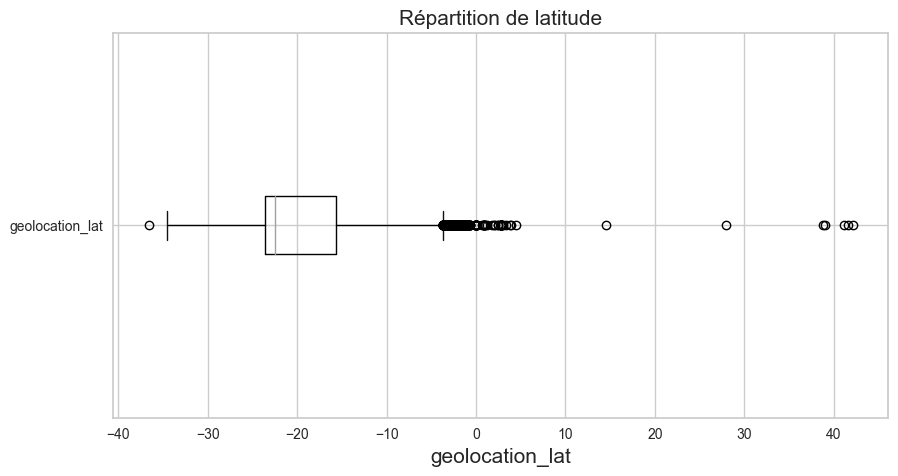

In [77]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de latitude", fontsize=15)
df_geolocation.boxplot(column="geolocation_lat", vert=False, notch=False)
plt.xlabel("geolocation_lat", fontsize=15)
plt.show()

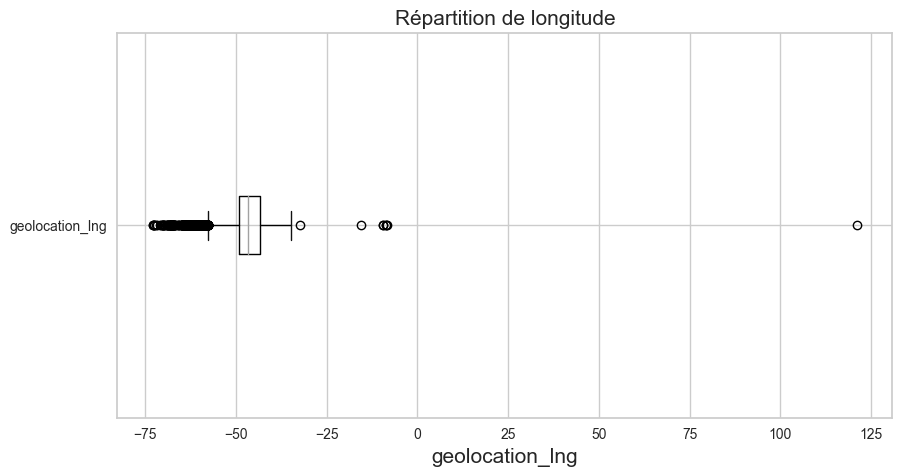

In [78]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de longitude", fontsize=15)
df_geolocation.boxplot(column="geolocation_lng", vert=False, notch=False)
plt.xlabel("geolocation_lng", fontsize=15)
plt.show()

In [79]:
df_geolocation.describe(include="object")

,geolocation_zip_code_prefix,geolocation_city,geolocation_state
count,19015,19015,19015
unique,19015,5776,27
top,1037,sao paulo,SP
freq,1,3180,6349


#### <a name="C3343">3.3.4.3 df_order_items </a>

In [80]:
df_order_items.describe(include="float64")

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


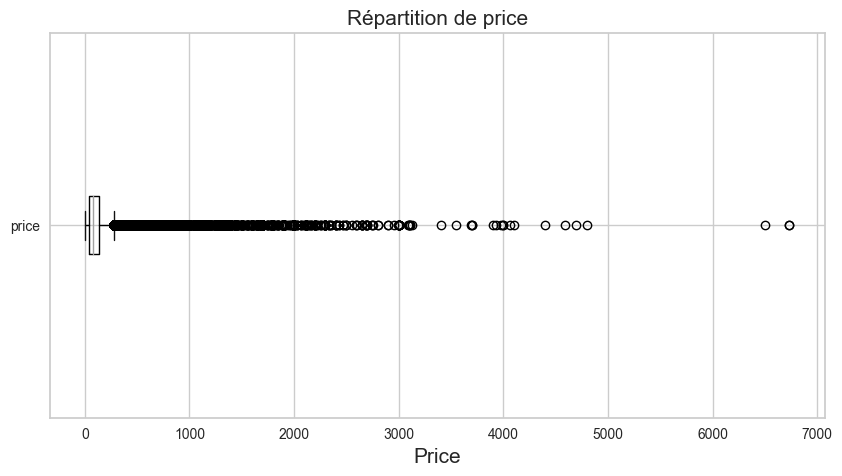

In [81]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de price", fontsize=15)
df_order_items.boxplot(column="price", vert=False, notch=False)
plt.xlabel("Price", fontsize=15)
plt.show()

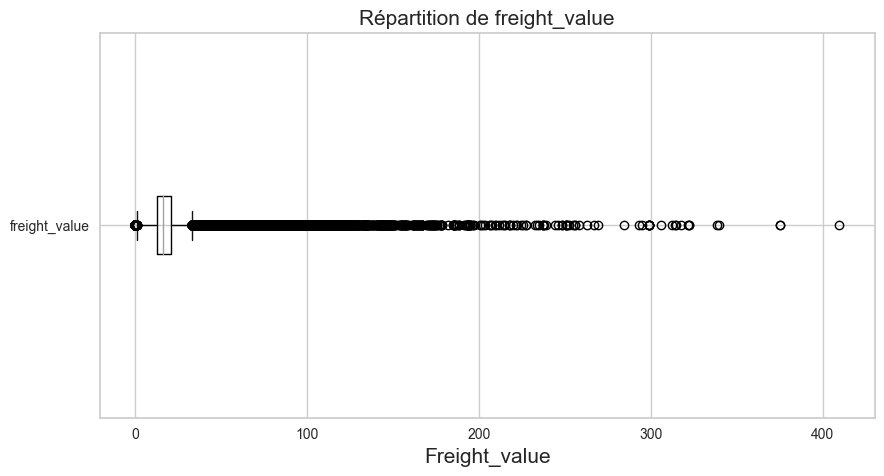

In [82]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de freight_value", fontsize=15)
df_order_items.boxplot(column="freight_value", vert=False, notch=False)
plt.xlabel("Freight_value", fontsize=15)
plt.show()

In [83]:
df_order_items.describe(include="datetime", datetime_is_numeric=True)

,shipping_limit_date
count,112650
mean,2018-01-07 15:36:52.192685312
min,2016-09-19 00:15:34
25%,2017-09-20 20:57:27.500000
50%,2018-01-26 13:59:35
75%,2018-05-10 14:34:00.750000128
max,2020-04-09 22:35:08


In [84]:
df_order_items.describe(include="object")

,order_id,order_item_id,product_id,seller_id
count,112650,112650,112650,112650
unique,98666,21,32951,3095
top,8272b63d03f5f79c56e9e4120aec44ef,1,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0
freq,21,98666,527,2033


#### <a name="C3344">3.3.4.4 df_order_payments </a>

In [85]:
df_order_payments.describe(include="int64")

,payment_sequential,payment_installments
count,103886.000000,103886.000000
mean,1.092679,2.853349
std,0.706584,2.687051
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,4.000000
max,29.000000,24.000000


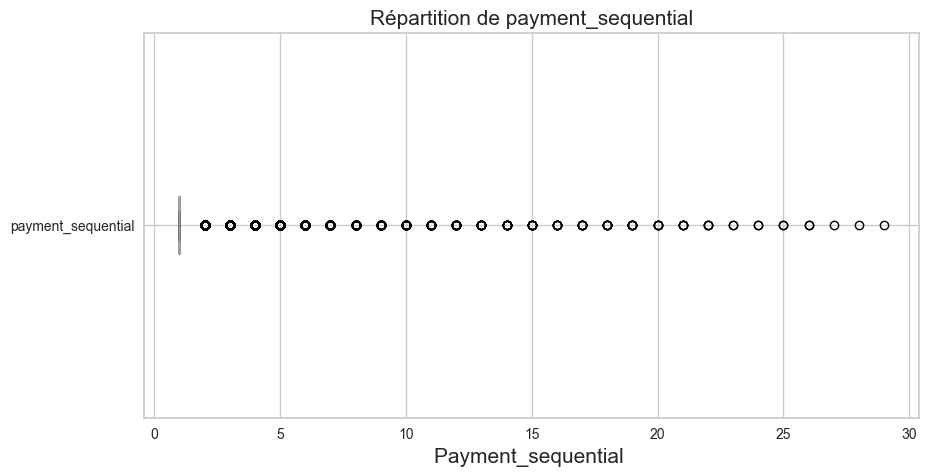

In [86]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de payment_sequential", fontsize=15)
df_order_payments.boxplot(column="payment_sequential", vert=False, notch=False)
plt.xlabel("Payment_sequential ", fontsize=15)
plt.show()

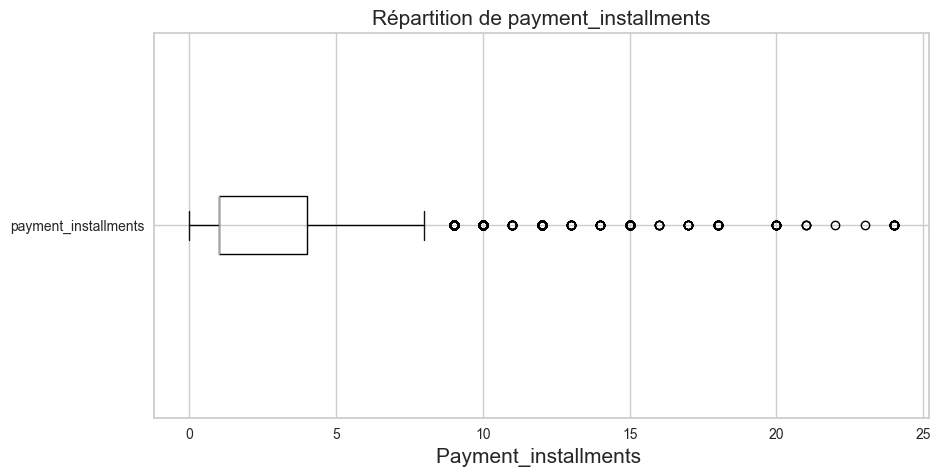

In [87]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de payment_installments", fontsize=15)
df_order_payments.boxplot(column="payment_installments", vert=False, notch=False)
plt.xlabel("Payment_installments ", fontsize=15)
plt.show()

In [88]:
df_order_payments.describe(include="float64")

,payment_value
count,103886.000000
mean,154.100380
std,217.494064
min,0.000000
25%,56.790000
50%,100.000000
75%,171.837500
max,13664.080000


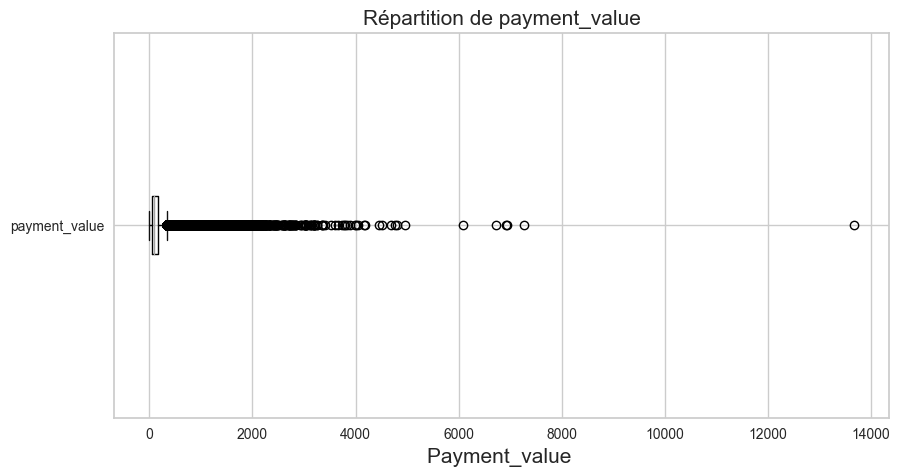

In [89]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de payment_value", fontsize=15)
df_order_payments.boxplot(column="payment_value", vert=False, notch=False)
plt.xlabel("Payment_value ", fontsize=15)
plt.show()

In [90]:
df_order_payments.describe(include="object")

,order_id,payment_type
count,103886,103886
unique,99440,5
top,fa65dad1b0e818e3ccc5cb0e39231352,credit_card
freq,29,76795


#### <a name="C3345">3.3.4.5 df_order_reviews </a>

In [91]:
df_order_reviews.describe()

,review_score
count,98673.000000
mean,4.086386
std,1.347618
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


#### <a name="C3346">3.3.4.6 df_orders </a>

In [92]:
df_orders.describe(include="datetime", datetime_is_numeric=True)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,96461,96461,96461,96461,96461
mean,2018-01-01 23:53:26.642249216,2018-01-02 10:10:06.480142336,2018-01-05 05:21:04.508827392,2018-01-14 13:17:13.228102400,2018-01-25 17:33:14.236012544
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00
25%,2017-09-14 09:28:28,2017-09-14 14:30:14,2017-09-18 16:52:19,2017-09-25 22:31:59,2017-10-05 00:00:00
50%,2018-01-20 19:59:42,2018-01-22 13:49:00,2018-01-24 16:19:03,2018-02-02 19:50:56,2018-02-16 00:00:00
75%,2018-05-05 18:33:24,2018-05-06 10:30:49,2018-05-08 14:33:00,2018-05-15 23:08:54,2018-05-28 00:00:00
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00


In [93]:
df_orders.describe(include="object")

,order_id,customer_id,order_status
count,96461,96461,96461
unique,96461,96461,2
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
freq,1,1,96455


#### <a name="C3347">3.3.4.7 df_products </a>

In [94]:
df_products.describe(include="float64")

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,30.854545,16.958813,23.208596
std,10.245699,635.124831,1.736787,4279.291845,16.955965,13.636115,12.078762
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


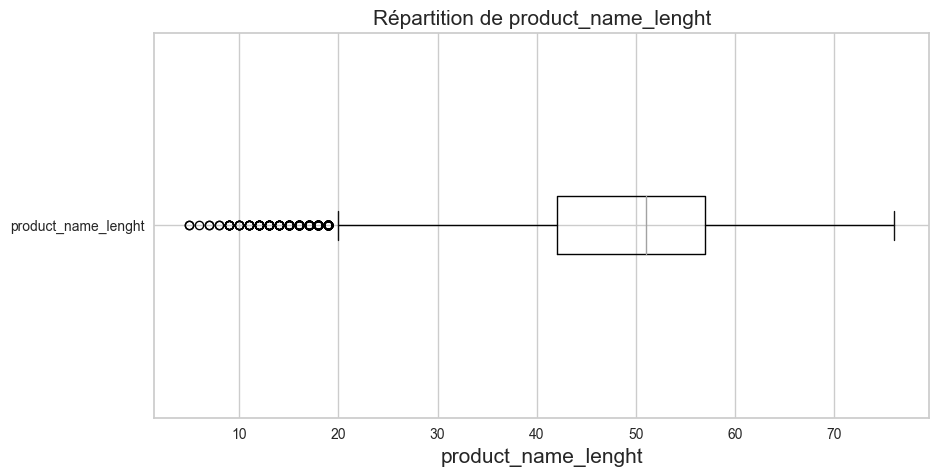

In [95]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_name_lenght", fontsize=15)
df_products.boxplot(column="product_name_lenght", vert=False, notch=False)
plt.xlabel("product_name_lenght", fontsize=15)
plt.show()

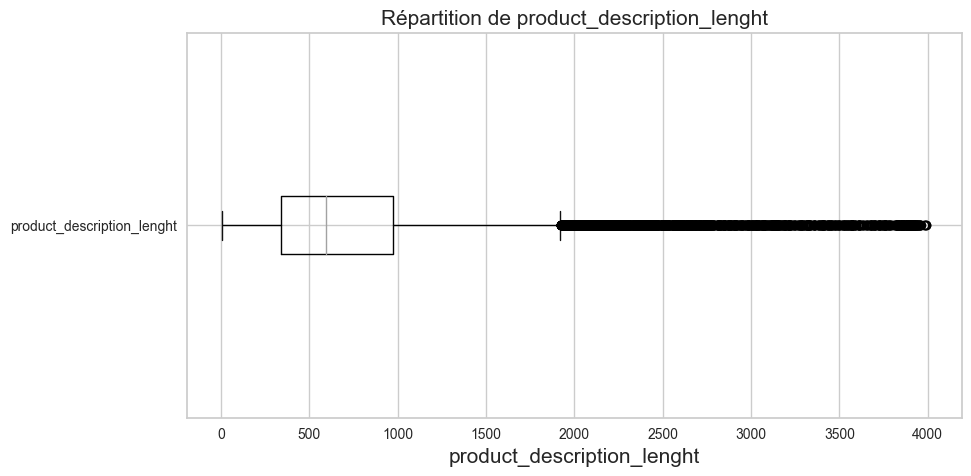

In [96]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_description_lenght", fontsize=15)
df_products.boxplot(column="product_description_lenght", vert=False, notch=False)
plt.xlabel("product_description_lenght", fontsize=15)
plt.show()

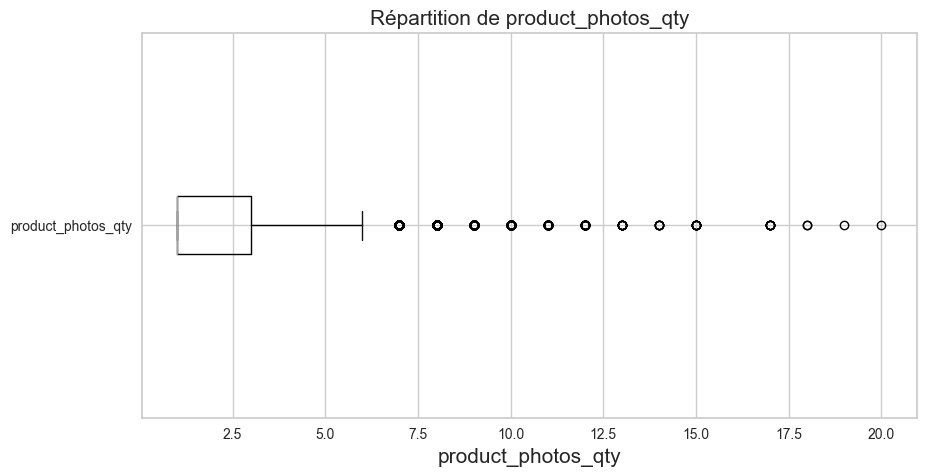

In [97]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_photos_qty", fontsize=15)
df_products.boxplot(column="product_photos_qty", vert=False, notch=False)
plt.xlabel("product_photos_qty", fontsize=15)
plt.show()

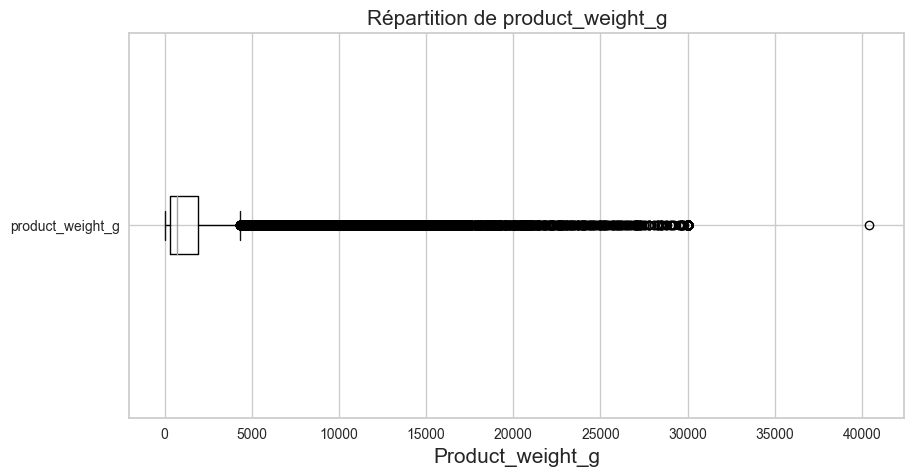

In [98]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_weight_g", fontsize=15)
df_products.boxplot(column="product_weight_g", vert=False, notch=False)
plt.xlabel("Product_weight_g", fontsize=15)
plt.show()

C:\Users\Utilisateur\anaconda3\envs\projet5\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


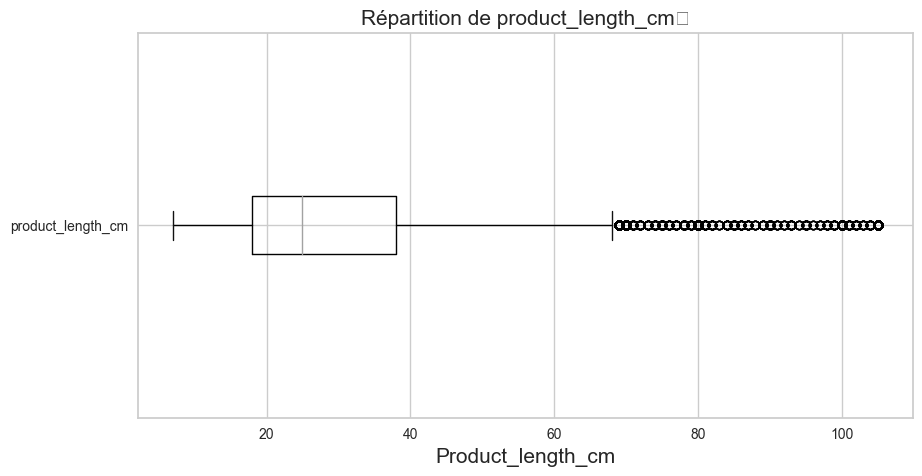

In [99]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_length_cm	", fontsize=15)
df_products.boxplot(column="product_length_cm", vert=False, notch=False)
plt.xlabel("Product_length_cm", fontsize=15)
plt.show()

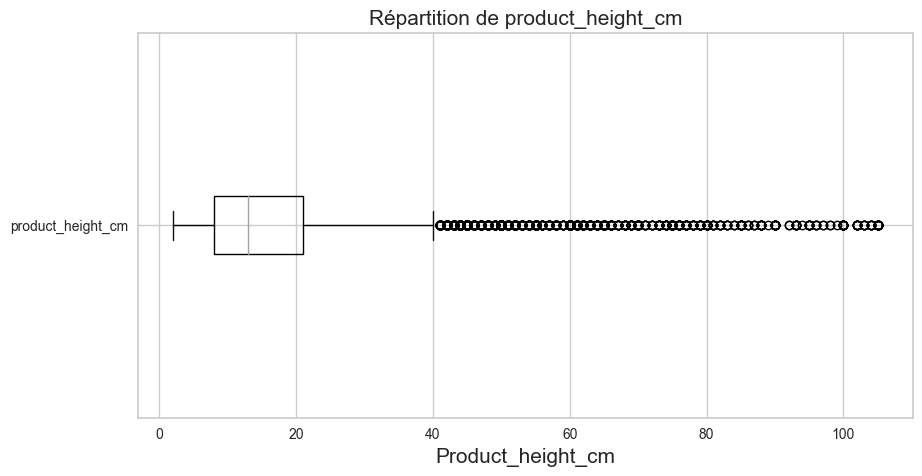

In [100]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_height_cm", fontsize=15)
df_products.boxplot(column="product_height_cm", vert=False, notch=False)
plt.xlabel("Product_height_cm", fontsize=15)
plt.show()

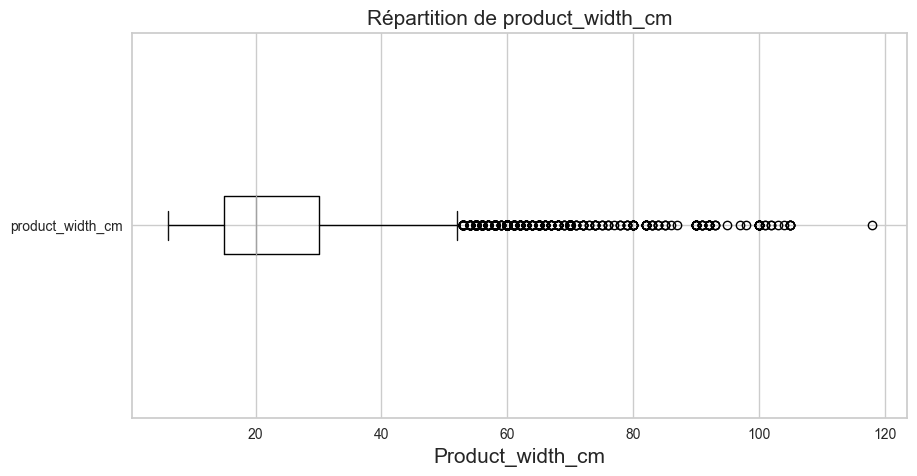

In [101]:
# Affichage de la répartition avec boxplot
plt.figure(figsize=(10, 5))
plt.title("Répartition de product_width_cm", fontsize=15)
df_products.boxplot(column="product_width_cm", vert=False, notch=False)
plt.xlabel("Product_width_cm", fontsize=15)
plt.show()

In [102]:
df_products.describe(include="object")

,product_id,product_category_name
count,32340,32340
unique,32340,73
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho
freq,1,3029


#### <a name="C3348">3.3.4.8 df_sellers </a>

In [103]:
df_sellers.describe(include="object")

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,3442f8959a84dea7ee197c632cb2df15,14940,sao paulo,SP
freq,1,49,694,1849


#### <a name="C3349">3.3.4.9 df_product_category_name_translation </a>

In [104]:
df_product_category_name_translation.describe(include="object")

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


### <a name="C335"> 3.3.5 Bilan du nettoyage</a> 

In [105]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [106]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  object 
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), object(3)
memory usage: 891.3+ KB


In [107]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  object        
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.0+ MB


In [108]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [109]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 80582 to 37547
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                98673 non-null  object        
 1   order_id                 98673 non-null  object        
 2   review_score             98673 non-null  int64         
 3   review_comment_title     98673 non-null  object        
 4   review_comment_message   98673 non-null  object        
 5   review_creation_date     98673 non-null  datetime64[ns]
 6   review_answer_timestamp  98673 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 6.0+ MB


In [110]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


In [111]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [112]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   object
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB


In [113]:
df_product_category_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [114]:
# from preprocessing import *
# df_app_train=pd.read_csv('application_train.csv')
# df_app_train=fct_preprocessing(df_app_train)

# <a name="C4"> 4. Création de features </a> 

In [115]:
df_order_items["total_unit_price"] = (
    df_order_items["price"] + df_order_items["freight_value"]
)
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_unit_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


In [116]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [117]:
df_orders["s1_duree_approbation"] = (
    df_orders["order_approved_at"] - df_orders["order_purchase_timestamp"]
)
df_orders["s2_attente_prise_transport"] = (
    df_orders["order_delivered_carrier_date"] - df_orders["order_approved_at"]
)
df_orders["s3_duree_transport"] = (
    df_orders["order_delivered_customer_date"]
    - df_orders["order_delivered_carrier_date"]
)
df_orders["s123_duree_attente_client"] = (
    df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]
)
df_orders["retard_livraison"] = (
    df_orders["order_delivered_customer_date"]
    - df_orders["order_estimated_delivery_date"]
)


# Ajout de la class retard
df_orders["retard_livraison_class"] = np.nan
df_orders = df_orders.astype({"retard_livraison_class": object})


df_tmp = df_orders.loc[
    df_orders["order_delivered_customer_date"]
    <= df_orders["order_estimated_delivery_date"],
    :,
]
for index in df_tmp.index:
    df_orders.loc[index, "retard_livraison_class"] = "NON"

df_tmp = df_orders.loc[
    df_orders["order_delivered_customer_date"]
    > df_orders["order_estimated_delivery_date"],
    :,
]
for index in df_tmp.index:
    df_orders.loc[index, "retard_livraison_class"] = "OUI"

df_orders.head()


# Suppression des colonnes sources (sauf "order_purchase_timestamp" qui servira au calcul RFM)
df_orders.drop(columns="order_approved_at", axis=1, inplace=True)
df_orders.drop(columns="order_delivered_carrier_date", axis=1, inplace=True)
df_orders.drop(columns="order_delivered_customer_date", axis=1, inplace=True)
df_orders.drop(columns="order_estimated_delivery_date", axis=1, inplace=True)

# <a name="C5"> 5. Rassemblement des dataframes/features</a> 

## <a name="C51"> 5.1 df_customers et df_orders</a> 

In [118]:
# Rassemblement de df_customer et df_orders
df_customers_orders = pd.merge(
    df_customers, df_orders, left_on="customer_id", right_on="customer_id", how="left"
)
df_customers_orders.info()


# Passage des types "timedelta64[ns]" en ""secondes" pour passer en float64

df_customers_orders["s1_duree_approbation"] = df_customers_orders[
    "s1_duree_approbation"
] / pd.Timedelta("1s")
df_customers_orders["s2_attente_prise_transport"] = df_customers_orders[
    "s2_attente_prise_transport"
] / pd.Timedelta("1s")
df_customers_orders["s3_duree_transport"] = df_customers_orders[
    "s3_duree_transport"
] / pd.Timedelta("1s")
df_customers_orders["s123_duree_attente_client"] = df_customers_orders[
    "s123_duree_attente_client"
] / pd.Timedelta("1s")
df_customers_orders["retard_livraison"] = df_customers_orders[
    "retard_livraison"
] / pd.Timedelta("1s")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   customer_id                 99441 non-null  object         
 1   customer_unique_id          99441 non-null  object         
 2   customer_zip_code_prefix    99441 non-null  object         
 3   customer_city               99441 non-null  object         
 4   customer_state              99441 non-null  object         
 5   order_id                    96461 non-null  object         
 6   order_status                96461 non-null  object         
 7   order_purchase_timestamp    96461 non-null  datetime64[ns] 
 8   s1_duree_approbation        96461 non-null  timedelta64[ns]
 9   s2_attente_prise_transport  96461 non-null  timedelta64[ns]
 10  s3_duree_transport          96461 non-null  timedelta64[ns]
 11  s123_duree_attente_client   96461 non-nul

## <a name="C52"> 5.2 df_customer_orders et df_orders_reviews</a> 

In [119]:
# Rassemblement de df_customer_orders et df_orders_reviews
df_customers_orders_reviews = pd.merge(
    df_customers_orders,
    df_order_reviews,
    left_on="order_id",
    right_on="order_id",
    how="left",
)
df_customers_orders_reviews.drop(columns="review_comment_title", axis=1, inplace=True)
df_customers_orders_reviews.drop(columns="review_comment_message", axis=1, inplace=True)
df_customers_orders_reviews.drop(columns="review_creation_date", axis=1, inplace=True)
df_customers_orders_reviews.drop(
    columns="review_answer_timestamp", axis=1, inplace=True
)
df_customers_orders_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 99441 non-null  object        
 1   customer_unique_id          99441 non-null  object        
 2   customer_zip_code_prefix    99441 non-null  object        
 3   customer_city               99441 non-null  object        
 4   customer_state              99441 non-null  object        
 5   order_id                    96461 non-null  object        
 6   order_status                96461 non-null  object        
 7   order_purchase_timestamp    96461 non-null  datetime64[ns]
 8   s1_duree_approbation        96461 non-null  float64       
 9   s2_attente_prise_transport  96461 non-null  float64       
 10  s3_duree_transport          96461 non-null  float64       
 11  s123_duree_attente_client   96461 non-null  float64   

## <a name="C53"> 5.3 df_customer_orders_reviews et df_order_items(total price)</a> 

In [120]:
# Calcul de la somme totale par order id
df_tmp = (
    df_order_items.groupby(["order_id"])["total_unit_price"].sum().reset_index()
)  # agrégation
df_tmp.columns = ["order_id", "total_price"]

# Rassemblement df_tmp et df_customers_orders_reviews
df_customers_orders_reviews_items = pd.merge(
    df_customers_orders_reviews,
    df_tmp,
    left_on="order_id",
    right_on="order_id",
    how="left",
)
df_customers_orders_reviews_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 99441 non-null  object        
 1   customer_unique_id          99441 non-null  object        
 2   customer_zip_code_prefix    99441 non-null  object        
 3   customer_city               99441 non-null  object        
 4   customer_state              99441 non-null  object        
 5   order_id                    96461 non-null  object        
 6   order_status                96461 non-null  object        
 7   order_purchase_timestamp    96461 non-null  datetime64[ns]
 8   s1_duree_approbation        96461 non-null  float64       
 9   s2_attente_prise_transport  96461 non-null  float64       
 10  s3_duree_transport          96461 non-null  float64       
 11  s123_duree_attente_client   96461 non-null  float64   

## <a name="C54"> 5.4 df_customers_orders_reviews_items et df_geolocation</a> 

In [121]:
# Rassemblement df_geolocation et df_customers_orders_reviews_items
df_customers_orders_reviews_items_geolocation = pd.merge(
    df_customers_orders_reviews_items,
    df_geolocation,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)
df_customers_orders_reviews_items_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  99441 non-null  object        
 1   customer_unique_id           99441 non-null  object        
 2   customer_zip_code_prefix     99441 non-null  object        
 3   customer_city                99441 non-null  object        
 4   customer_state               99441 non-null  object        
 5   order_id                     96461 non-null  object        
 6   order_status                 96461 non-null  object        
 7   order_purchase_timestamp     96461 non-null  datetime64[ns]
 8   s1_duree_approbation         96461 non-null  float64       
 9   s2_attente_prise_transport   96461 non-null  float64       
 10  s3_duree_transport           96461 non-null  float64       
 11  s123_duree_attente_client    96461 non-nu

## <a name="C55"> 5.5 df_customers_orders_reviews_items_geolocation et df_order_items(seller id - unique)</a> 

In [122]:
# Intégration des vendeurs id dans df_customers_orders_reviews_items_geolocation (pour les commandes ayant qu'un unique venedeur

df_tmp = df_order_items[["order_id", "seller_id"]]

# Suppression des "order_id" + "seller id" identiques
df_tmp = df_tmp.drop_duplicates()

# Suppression des "order_id" identiques pour ne garder qu'un seller_id par order_id
# df_tmp=df_tmp.drop_duplicates(subset=['order_id'], keep='last')
# df_tmp.describe()


# Détection des commandes ayant plus de 1 vendeur
tmp = df_tmp.groupby(["order_id"]).size().reset_index()  # agrégation
tmp.columns = ["order_id", "quantite_seller"]  # renommage des colonnes
tmp_sort = tmp.sort_values(
    "quantite_seller", ascending=False
)  # trie de la quantité par ordre croissant

# Selection des commandes n'ayant qu'un seul vendeur
tmp_sort = tmp_sort.loc[tmp_sort["quantite_seller"] == 1]
tmp_sort.head()

# Rassemblement des commandes et vendeurs ayant qu'un seul vendeur unique
df_order_sellers = pd.merge(
    tmp_sort, df_tmp, left_on="order_id", right_on="order_id", how="left"
)
df_order_sellers.head()

df_customers_orders_reviews_items_geolocation_sellers = pd.merge(
    df_customers_orders_reviews_items_geolocation,
    df_order_sellers,
    left_on="order_id",
    right_on="order_id",
    how="left",
)
df_customers_orders_reviews_items_geolocation_sellers.drop(
    columns="quantite_seller", axis=1, inplace=True
)
df_customers_orders_reviews_items_geolocation_sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  99441 non-null  object        
 1   customer_unique_id           99441 non-null  object        
 2   customer_zip_code_prefix     99441 non-null  object        
 3   customer_city                99441 non-null  object        
 4   customer_state               99441 non-null  object        
 5   order_id                     96461 non-null  object        
 6   order_status                 96461 non-null  object        
 7   order_purchase_timestamp     96461 non-null  datetime64[ns]
 8   s1_duree_approbation         96461 non-null  float64       
 9   s2_attente_prise_transport   96461 non-null  float64       
 10  s3_duree_transport           96461 non-null  float64       
 11  s123_duree_attente_client    96461 non-nu

In [123]:
# Test pour observer si le seller_id n'est pas remonté pour une commande multivendeurs
tmp = df_customers_orders_reviews_items_geolocation_sellers.loc[
    df_customers_orders_reviews_items_geolocation_sellers["order_id"]
    == "1c11d0f4353b31ac3417fbfa5f0f2a8a"
]
tmp.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,s1_duree_approbation,s2_attente_prise_transport,s3_duree_transport,s123_duree_attente_client,retard_livraison,retard_livraison_class,review_id,review_score,total_price,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,seller_id
32375,50920f8cd0681fd86ebe93670c8fe52e,41a3b256cc497dc952a815b848345cbc,98700,ijui,RS,1c11d0f4353b31ac3417fbfa5f0f2a8a,delivered,2018-01-27 11:28:32,173211.0,37038.0,1535652.0,1745901.0,-1409587.0,NON,6fe49ee0a2b00dddf7ebddb5847f9283,1.0,421.7,98700,-28.389228,-53.929676,ijui,RS,NaN


## <a name="C56"> 5.6 df_customers_orders_reviews_items_geolocation_sellers et df_sellers</a> 

In [124]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   object
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB


In [125]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  object 
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), object(3)
memory usage: 891.3+ KB


In [126]:
df_sellers_geolocation = pd.merge(
    df_sellers,
    df_geolocation,
    left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
)
df_sellers_geolocation.columns = [
    "seller_id",
    "seller_zip_code_prefix",
    "seller_city",
    "seller_state",
    "geolocation_zip_code_prefix_seller",
    "geolocation_lat_seller",
    "geolocation_lng_seller",
    "geolocation_city_seller",
    "geolocation_state_seller",
]  # renommage des colonnes
df_sellers_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   seller_id                           3095 non-null   object 
 1   seller_zip_code_prefix              3095 non-null   object 
 2   seller_city                         3095 non-null   object 
 3   seller_state                        3095 non-null   object 
 4   geolocation_zip_code_prefix_seller  3088 non-null   object 
 5   geolocation_lat_seller              3088 non-null   float64
 6   geolocation_lng_seller              3088 non-null   float64
 7   geolocation_city_seller             3088 non-null   object 
 8   geolocation_state_seller            3088 non-null   object 
dtypes: float64(2), object(7)
memory usage: 241.8+ KB


In [127]:
df_customers_orders_reviews_items_geolocation_sellers = pd.merge(
    df_customers_orders_reviews_items_geolocation_sellers,
    df_sellers_geolocation,
    left_on="seller_id",
    right_on="seller_id",
    how="left",
)
df_customers_orders_reviews_items_geolocation_sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   customer_id                         99441 non-null  object        
 1   customer_unique_id                  99441 non-null  object        
 2   customer_zip_code_prefix            99441 non-null  object        
 3   customer_city                       99441 non-null  object        
 4   customer_state                      99441 non-null  object        
 5   order_id                            96461 non-null  object        
 6   order_status                        96461 non-null  object        
 7   order_purchase_timestamp            96461 non-null  datetime64[ns]
 8   s1_duree_approbation                96461 non-null  float64       
 9   s2_attente_prise_transport          96461 non-null  float64       
 10  s3_duree_transport    

## <a name="C57"> 5.7 Calcul distance entre vendeurs et clients (ajout d'une colonne)</a> 

In [128]:
df_tmp = df_customers_orders_reviews_items_geolocation_sellers[
    [
        "customer_id",
        "geolocation_lat",
        "geolocation_lng",
        "geolocation_lat_seller",
        "geolocation_lng_seller",
    ]
]
df_tmp = df_tmp.dropna(axis=0)
df_tmp.head()

,customer_id,geolocation_lat,geolocation_lng,geolocation_lat_seller,geolocation_lng_seller
0,06b8999e2fba1a1fbc88172c00ba8bc7,-20.509897,-47.397866,-23.482623,-46.374490
1,18955e83d337fd6b2def6b18a428ac77,-23.726853,-46.545746,-26.912429,-48.677381
2,4e7b3e00288586ebd08712fdd0374a03,-23.527788,-46.660310,-23.482623,-46.374490
3,b2b6027bc5c5109e529d4dc6358b12c3,-23.496930,-46.185352,-23.482623,-46.374490
4,4f2d8ab171c80ec8364f7c12e35b23ad,-22.987222,-47.151073,-21.766477,-48.831547


In [129]:
df_tmp["distance_customer_seller_km"] = haversine_distance(
    df_tmp["geolocation_lat"],
    df_tmp["geolocation_lng"],
    df_tmp["geolocation_lat_seller"],
    df_tmp["geolocation_lng_seller"],
)
df_tmp.head()

,customer_id,geolocation_lat,geolocation_lng,geolocation_lat_seller,geolocation_lng_seller,distance_customer_seller_km
0,06b8999e2fba1a1fbc88172c00ba8bc7,-20.509897,-47.397866,-23.482623,-46.374490,346.98
1,18955e83d337fd6b2def6b18a428ac77,-23.726853,-46.545746,-26.912429,-48.677381,413.95
2,4e7b3e00288586ebd08712fdd0374a03,-23.527788,-46.660310,-23.482623,-46.374490,29.57
3,b2b6027bc5c5109e529d4dc6358b12c3,-23.496930,-46.185352,-23.482623,-46.374490,19.35
4,4f2d8ab171c80ec8364f7c12e35b23ad,-22.987222,-47.151073,-21.766477,-48.831547,219.73


In [130]:
# Suppression des colonnes sources
df_tmp.drop(columns="geolocation_lat", axis=1, inplace=True)
df_tmp.drop(columns="geolocation_lng", axis=1, inplace=True)
df_tmp.drop(columns="geolocation_lat_seller", axis=1, inplace=True)
df_tmp.drop(columns="geolocation_lng_seller", axis=1, inplace=True)

In [131]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94716 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  94716 non-null  object 
 1   distance_customer_seller_km  94716 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [132]:
df_customers_orders_reviews_items_geolocation_sellers = pd.merge(
    df_customers_orders_reviews_items_geolocation_sellers,
    df_tmp,
    left_on="customer_id",
    right_on="customer_id",
    how="left",
)

# Suppression des colonnes sources
df_customers_orders_reviews_items_geolocation_sellers.drop(
    columns="geolocation_lat", axis=1, inplace=True
)
df_customers_orders_reviews_items_geolocation_sellers.drop(
    columns="geolocation_lng", axis=1, inplace=True
)
df_customers_orders_reviews_items_geolocation_sellers.drop(
    columns="geolocation_lat_seller", axis=1, inplace=True
)
df_customers_orders_reviews_items_geolocation_sellers.drop(
    columns="geolocation_lng_seller", axis=1, inplace=True
)

df_customers_orders_reviews_items_geolocation_sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   customer_id                         99441 non-null  object        
 1   customer_unique_id                  99441 non-null  object        
 2   customer_zip_code_prefix            99441 non-null  object        
 3   customer_city                       99441 non-null  object        
 4   customer_state                      99441 non-null  object        
 5   order_id                            96461 non-null  object        
 6   order_status                        96461 non-null  object        
 7   order_purchase_timestamp            96461 non-null  datetime64[ns]
 8   s1_duree_approbation                96461 non-null  float64       
 9   s2_attente_prise_transport          96461 non-null  float64       
 10  s3_duree_transport    

# <a name="C6">6. Calcul RFM</a>

### <a name="C411">4.1.1 Récence</a>

In [133]:
import datetime

now = datetime.datetime.today()
print(now)

2023-02-22 13:11:30.252828


In [134]:
# Pour ce calcul, je me place dans le cas où je suis actuellement à la date de la dernière date de commande
df_recency = df_customers_orders_reviews_items_geolocation_sellers.groupby(
    by="customer_unique_id", as_index=False
)["order_purchase_timestamp"].max()
df_recency.columns = ["customer_unique_id", "LastPurchaseDate"]
recent_date = df_recency["LastPurchaseDate"].max()
df_recency["Recency"] = df_recency["LastPurchaseDate"].apply(
    lambda x: (recent_date - x).days
)  # pour calculer le recent vis à vis de la date d'aujourd'hui, remplace "now" par "recent_date"
df_recency.sort_values(by=["Recency"], ascending=False, inplace=True)
df_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
49312,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,713.0
16091,2ad10f49ef1f061d5f6739c89d3ade68,2016-10-04 13:45:08,694.0
93544,f922896769e9517ea3c630f3c8de86d0,2016-10-04 14:23:50,694.0
77171,cd5a5843d35eebdf90368bf24d4a04cf,2016-10-04 09:06:10,694.0
18579,31463a6b3a01f53c3ef1a04a849decf4,2016-10-04 13:16:57,694.0


### <a name="C412">4.1.2 Fréquence</a>

In [135]:
df_frequency = df_customers_orders_reviews_items_geolocation_sellers.groupby(
    by=["customer_unique_id"], as_index=False
)["order_purchase_timestamp"].count()
df_frequency.columns = ["customer_unique_id", "Frequency"]
df_frequency.sort_values(by=["Frequency"], ascending=False, inplace=True)
df_frequency.head()

,customer_unique_id,Frequency
52973,8d50f5eadf50201ccdcedfb9e2ac8455,15
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7


### <a name="C413">4.1.3 Montant</a>

In [136]:
df_monetary = df_customers_orders_reviews_items_geolocation_sellers.groupby(
    by="customer_unique_id", as_index=False
)["total_price"].sum()
df_monetary.columns = ["customer_unique_id", "Monetary"]
df_monetary.sort_values(by=["Monetary"], ascending=True, inplace=True)
df_monetary.head()

,customer_unique_id,Monetary
75492,c8d832b1e6f4aa662d0fefabfca04265,0.0
45287,7879fe9c6ecf38c965286723da56f713,0.0
4292,0b3b4176e5e04483b5a478e0329e3b82,0.0
71186,bd62b323b8e70075724fb43aab7a5bdc,0.0
45257,786abe8655280c105e08af1030cd3738,0.0


In [137]:
# Calcul du panier moyen par client
df_panier_moyen = df_customers_orders_reviews_items_geolocation_sellers.groupby(
    by="customer_unique_id", as_index=False
)["total_price"].mean()
df_panier_moyen.columns = ["customer_unique_id", "Monetary_mean"]
df_panier_moyen.sort_values(by=["Monetary_mean"], ascending=True, inplace=True)
df_panier_moyen.head()

,customer_unique_id,Monetary_mean
18643,317cfc692e3f86c45c95697c61c853a6,9.59
71052,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07
67388,b33336f46234b24a613ad9064d13106d,10.89
41892,6f5b9d1cdccc4d28f0483a612edecacf,11.63
15236,2878e5b88167faab17d4fb83a986d38b,11.63


In [138]:
# Ajout du panier moyer à df_monetary
df_monetary = pd.merge(
    df_monetary,
    df_panier_moyen,
    left_on="customer_unique_id",
    right_on="customer_unique_id",
    how="left",
)
df_monetary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   Monetary            96096 non-null  float64
 2   Monetary_mean       93342 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


### <a name="C414">4.1.4 Rassemblement RFM</a>

In [139]:
df_rf = df_recency.merge(df_frequency, on="customer_unique_id")
df_rfm = df_rf.merge(df_monetary, on="customer_unique_id").drop(
    columns="LastPurchaseDate"
)
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   Recency             93342 non-null  float64
 2   Frequency           96096 non-null  int64  
 3   Monetary            96096 non-null  float64
 4   Monetary_mean       93342 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.4+ MB


In [140]:
# Suppression des lignes ayant au moins 1 vide
df_rfm = df_rfm.dropna(axis=0)
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93342 entries, 0 to 93341
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93342 non-null  object 
 1   Recency             93342 non-null  float64
 2   Frequency           93342 non-null  int64  
 3   Monetary            93342 non-null  float64
 4   Monetary_mean       93342 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.3+ MB


### <a name="C415">4.1.5 Normalisation RFM</a>

In [141]:
df_rfm["R_rank"] = df_rfm["Recency"].rank(ascending=False)
df_rfm["F_rank"] = df_rfm["Frequency"].rank(ascending=True)
df_rfm["M_rank"] = df_rfm["Monetary"].rank(ascending=True)

df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,Monetary_mean,R_rank,F_rank,M_rank
0,830d5b7aaa3b6f1e9ad63703bec97d23,713.0,1,143.46,143.46,1.0,45271.5,59741.0
1,2ad10f49ef1f061d5f6739c89d3ade68,694.0,1,398.12,398.12,14.5,45271.5,87158.0
2,f922896769e9517ea3c630f3c8de86d0,694.0,1,62.33,62.33,14.5,45271.5,22874.0
3,cd5a5843d35eebdf90368bf24d4a04cf,694.0,1,65.50,65.50,14.5,45271.5,25144.5
4,31463a6b3a01f53c3ef1a04a849decf4,694.0,1,177.28,177.28,14.5,45271.5,69006.5


In [142]:
# normalizing the rank of the customers
df_rfm["R_rank_norm"] = (df_rfm["R_rank"] / df_rfm["R_rank"].max()) * 100
df_rfm["F_rank_norm"] = (df_rfm["F_rank"] / df_rfm["F_rank"].max()) * 100
df_rfm["M_rank_norm"] = (df_rfm["M_rank"] / df_rfm["M_rank"].max()) * 100

df_rfm.drop(columns=["R_rank", "F_rank", "M_rank"], inplace=True)

df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,Monetary_mean,R_rank_norm,F_rank_norm,M_rank_norm
0,830d5b7aaa3b6f1e9ad63703bec97d23,713.0,1,143.46,143.46,0.001071,48.500675,64.002271
1,2ad10f49ef1f061d5f6739c89d3ade68,694.0,1,398.12,398.12,0.015537,48.500675,93.374901
2,f922896769e9517ea3c630f3c8de86d0,694.0,1,62.33,62.33,0.015537,48.500675,24.505582
3,cd5a5843d35eebdf90368bf24d4a04cf,694.0,1,65.50,65.50,0.015537,48.500675,26.938034
4,31463a6b3a01f53c3ef1a04a849decf4,694.0,1,177.28,177.28,0.015537,48.500675,73.928671


### <a name="C416">4.1.6 Calcul du score RFM</a>

In [143]:
df_rfm["RFM_Score"] = (
    0.15 * df_rfm["R_rank_norm"]
    + 0.28 * df_rfm["F_rank_norm"]
    + 0.57 * df_rfm["M_rank_norm"]
)
df_rfm["RFM_Score"] *= 0.05  # Passage du score sur 5
df_rfm = df_rfm.round(2)
df_rfm.sort_values(by=["RFM_Score"], ascending=False, inplace=True)
df_rfm[["customer_unique_id", "RFM_Score"]].head(7)

,customer_unique_id,RFM_Score
89080,c8460e4251689ba205045f3ea17884a1,4.97
90732,4facc2e6fbc2bffab2fea92d2b4aa7e4,4.97
92881,dc813062e0fc23409cd255f7f53c7074,4.96
92346,8d50f5eadf50201ccdcedfb9e2ac8455,4.95
86723,4e1cce07cd5937c69dacac3c8b13d965,4.93
89029,525cda9909aa001ebed396f6e55eae01,4.93
91272,394ac4de8f3acb14253c177f0e15bc58,4.92


In [144]:
# Affichage du score min et du max
a = df_rfm["RFM_Score"].min()
print(a)
a = df_rfm["RFM_Score"].max()
print(a)

0.68
4.97


In [145]:
df_rfm["Customer_segment"] = np.where(
    df_rfm["RFM_Score"] > 4.5,
    "Top Customers",
    (
        np.where(
            df_rfm["RFM_Score"] > 4,
            "High value Customer",
            (
                np.where(
                    df_rfm["RFM_Score"] > 3,
                    "Medium Value Customer",
                    np.where(
                        df_rfm["RFM_Score"] > 1.6,
                        "Low Value Customers",
                        "Lost Customers",
                    ),
                )
            ),
        )
    ),
)
df_rfm[["customer_unique_id", "RFM_Score", "Customer_segment"]].head(20)

,customer_unique_id,RFM_Score,Customer_segment
89080,c8460e4251689ba205045f3ea17884a1,4.97,Top Customers
90732,4facc2e6fbc2bffab2fea92d2b4aa7e4,4.97,Top Customers
92881,dc813062e0fc23409cd255f7f53c7074,4.96,Top Customers
92346,8d50f5eadf50201ccdcedfb9e2ac8455,4.95,Top Customers
86723,4e1cce07cd5937c69dacac3c8b13d965,4.93,Top Customers
89029,525cda9909aa001ebed396f6e55eae01,4.93,Top Customers
91272,394ac4de8f3acb14253c177f0e15bc58,4.92,Top Customers
89336,839a04051a2c347397fd425d01fc3eb2,4.91,Top Customers
84589,d132b863416f85f2abb1a988ca05dd12,4.91,Top Customers
88913,54982b0c374191195d5f433c7cccae90,4.91,Top Customers


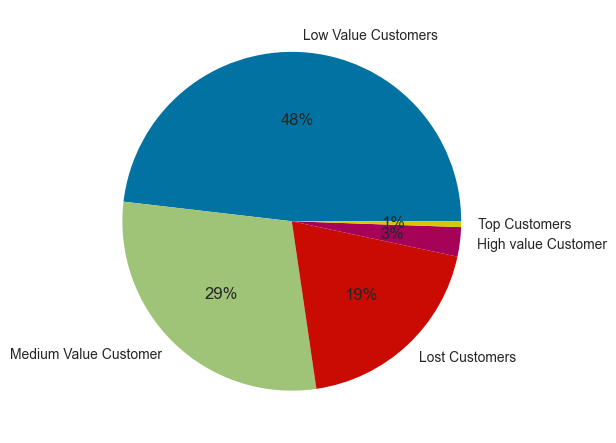

In [146]:
plt.pie(
    df_rfm.Customer_segment.value_counts(),
    labels=df_rfm.Customer_segment.value_counts().index,
    autopct="%.0f%%",
)
plt.show()

In [147]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93342 entries, 89080 to 287
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93342 non-null  object 
 1   Recency             93342 non-null  float64
 2   Frequency           93342 non-null  int64  
 3   Monetary            93342 non-null  float64
 4   Monetary_mean       93342 non-null  float64
 5   R_rank_norm         93342 non-null  float64
 6   F_rank_norm         93342 non-null  float64
 7   M_rank_norm         93342 non-null  float64
 8   RFM_Score           93342 non-null  float64
 9   Customer_segment    93342 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.8+ MB


### <a name="C417">4.1.7 Intégration de RFM au dataframe final</a>

In [148]:
# Suppression des colonnes sources
df_rfm.drop(columns="R_rank_norm", axis=1, inplace=True)
df_rfm.drop(columns="F_rank_norm", axis=1, inplace=True)
df_rfm.drop(columns="M_rank_norm", axis=1, inplace=True)

In [149]:
# Intégration de df_rfm à df_customers_orders_reviews_items
df_customers_orders_reviews_items_geolocation_sellers_rfm = pd.merge(
    df_customers_orders_reviews_items_geolocation_sellers,
    df_rfm,
    left_on="customer_unique_id",
    right_on="customer_unique_id",
    how="left",
)
df_customers_orders_reviews_items_geolocation_sellers_rfm.drop(
    columns="order_purchase_timestamp", axis=1, inplace=True
)  # Suppression de cette colonne qui a servi au calcul RFM
df_customers_orders_reviews_items_geolocation_sellers_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_id                         99441 non-null  object 
 1   customer_unique_id                  99441 non-null  object 
 2   customer_zip_code_prefix            99441 non-null  object 
 3   customer_city                       99441 non-null  object 
 4   customer_state                      99441 non-null  object 
 5   order_id                            96461 non-null  object 
 6   order_status                        96461 non-null  object 
 7   s1_duree_approbation                96461 non-null  float64
 8   s2_attente_prise_transport          96461 non-null  float64
 9   s3_duree_transport                  96461 non-null  float64
 10  s123_duree_attente_client           96461 non-null  float64
 11  retard_livraison                    96461

In [150]:
df_final = df_customers_orders_reviews_items_geolocation_sellers_rfm.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_id                         99441 non-null  object 
 1   customer_unique_id                  99441 non-null  object 
 2   customer_zip_code_prefix            99441 non-null  object 
 3   customer_city                       99441 non-null  object 
 4   customer_state                      99441 non-null  object 
 5   order_id                            96461 non-null  object 
 6   order_status                        96461 non-null  object 
 7   s1_duree_approbation                96461 non-null  float64
 8   s2_attente_prise_transport          96461 non-null  float64
 9   s3_duree_transport                  96461 non-null  float64
 10  s123_duree_attente_client           96461 non-null  float64
 11  retard_livraison                    96461

In [151]:
# Passage de customer_id en index
df_final.set_index("customer_id", inplace=True)

In [152]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_unique_id                  99441 non-null  object 
 1   customer_zip_code_prefix            99441 non-null  object 
 2   customer_city                       99441 non-null  object 
 3   customer_state                      99441 non-null  object 
 4   order_id                            96461 non-null  object 
 5   order_status                        96461 non-null  object 
 6   s1_duree_approbation                96461 non-null  float64
 7   s2_attente_prise_transport          96461 non-null  float64
 8   s3_duree_transport                  96461 non-null  float64
 9   s123_duree_attente_client           96461 non-null  float64
 10  retard_livraison                    96461 non-null  f

# 7 Analyses

## <a name="C71">7.1 Analyses multivarées</a>

### <a name="C711">7.1.1 Variables numériques </a>

#### <a name="C7111">7.1.1.1 Corrélation </a>

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4952\111956438.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


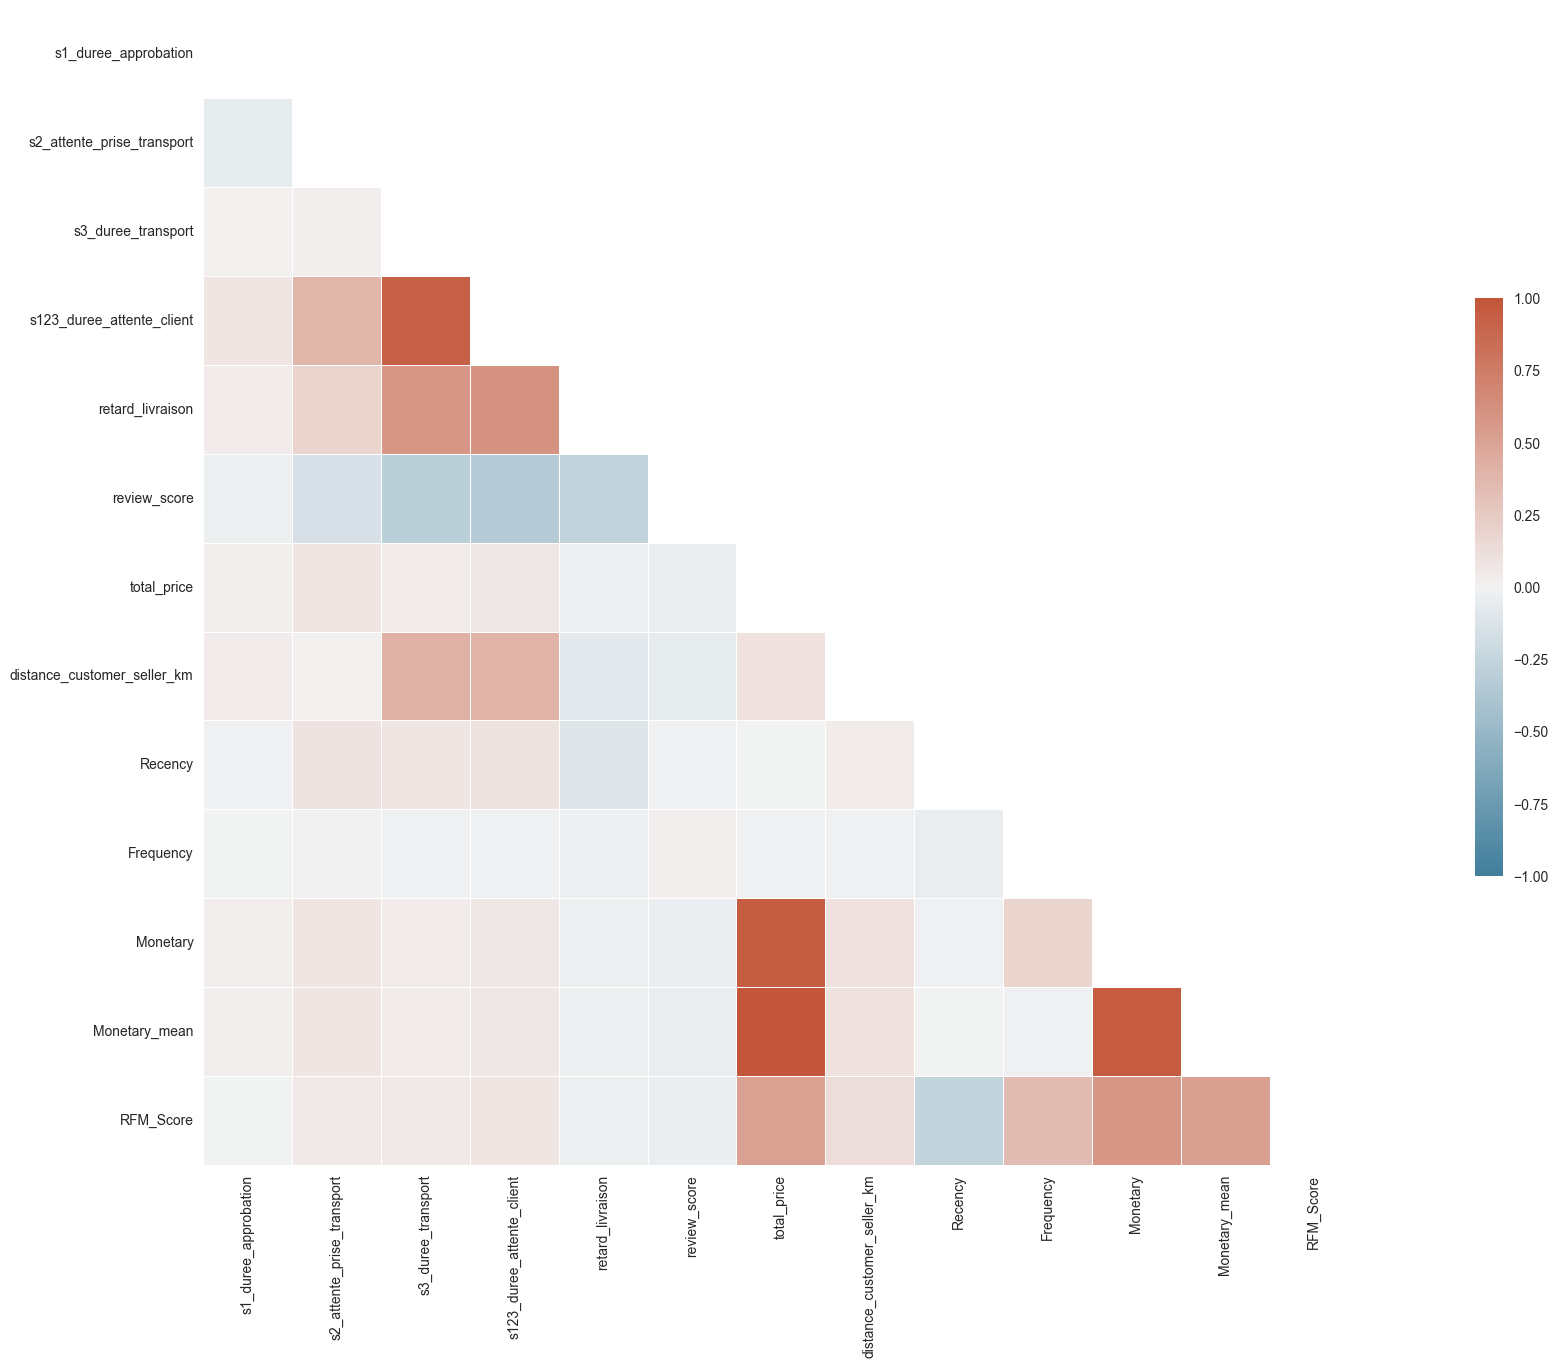

In [153]:
correlation(df_final)

#### <a name="C7112">7.1.1.2 PCA </a>

In [154]:
# Selection des variables numériques
df_final_num = df_final.select_dtypes(include=["int64", "float64"])

In [155]:
df_final_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   s1_duree_approbation         96461 non-null  float64
 1   s2_attente_prise_transport   96461 non-null  float64
 2   s3_duree_transport           96461 non-null  float64
 3   s123_duree_attente_client    96461 non-null  float64
 4   retard_livraison             96461 non-null  float64
 5   review_score                 95815 non-null  float64
 6   total_price                  96461 non-null  float64
 7   distance_customer_seller_km  94716 non-null  float64
 8   Recency                      96667 non-null  float64
 9   Frequency                    96667 non-null  float64
 10  Monetary                     96667 non-null  float64
 11  Monetary_mean                96667 non-null  float64
 12  RFM_Score            

In [156]:
# Supression des NaN
df_final_num.dropna(axis=0, inplace=True)

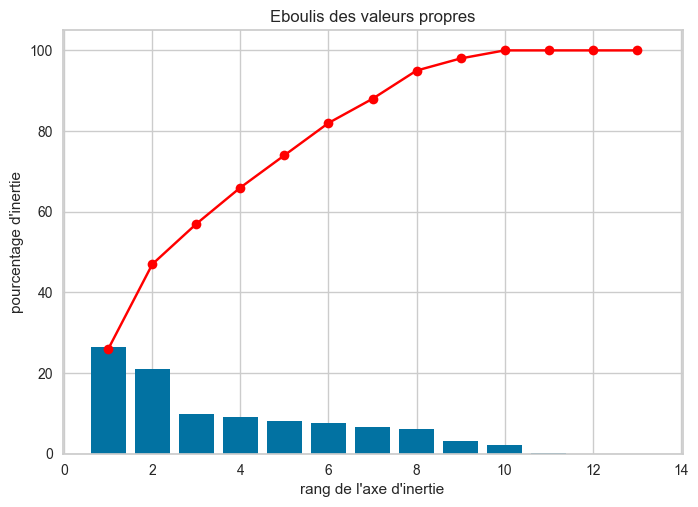

array([0.26, 0.21, 0.1 , 0.09, 0.08, 0.08, 0.07, 0.06, 0.03, 0.02, 0.  ,
       0.  , 0.  ])

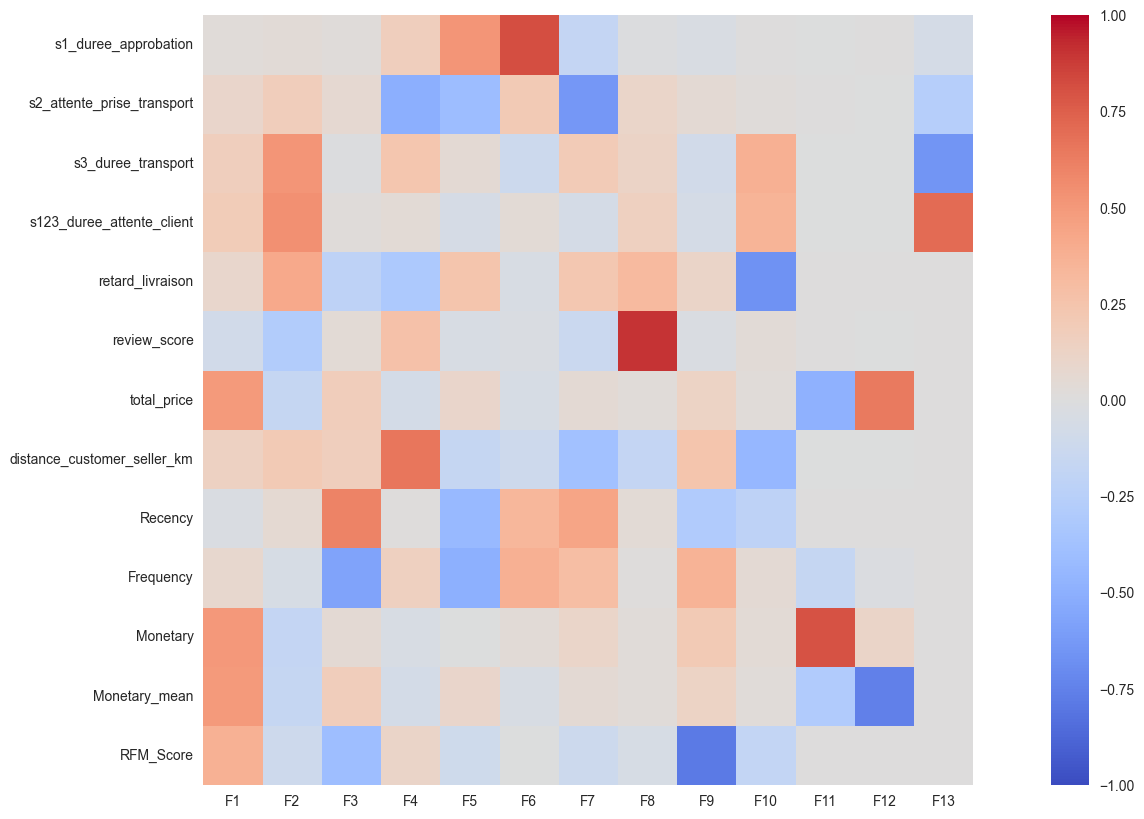

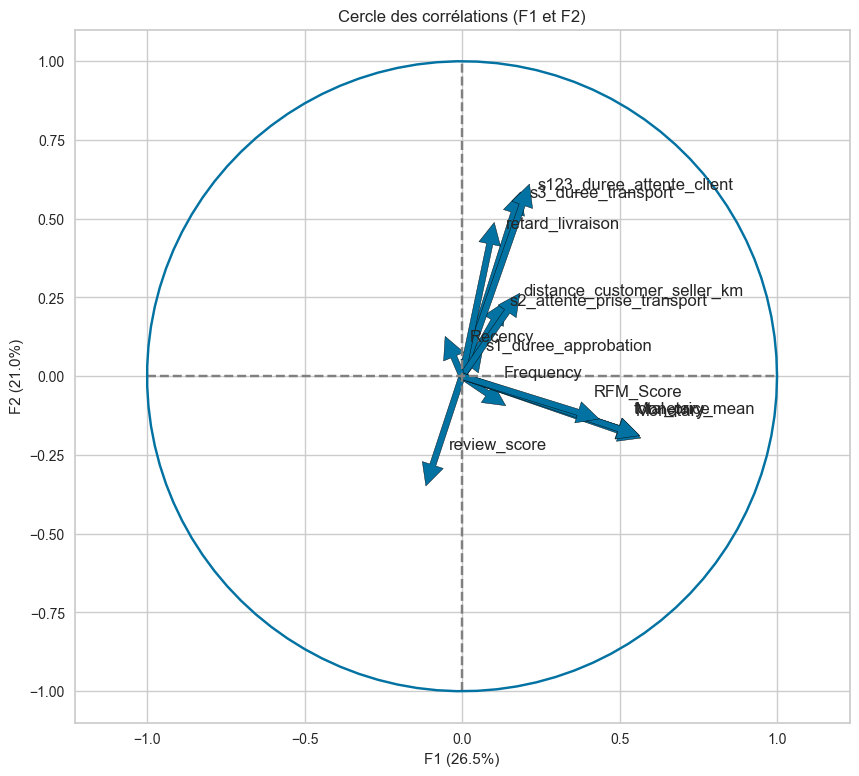

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4952\3343622405.py:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_[:, x], X_[:, y], alpha=alpha, c=c, cmap="Set1", marker=marker)


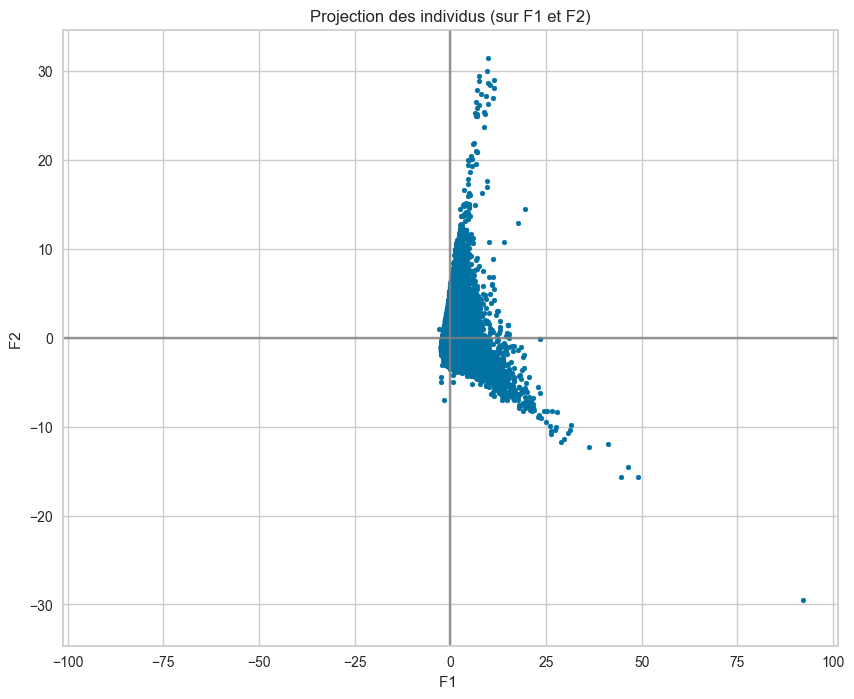

In [157]:
# Nombre de composant choisi
n_components = 13

# Numéro des composantes à choisir pour le cercle des corrélations
c1 = 0
c2 = 1

pcs = ACP(df_final_num, n_components, c1, c2)

#### <a name="C7113">7.1.1.3 df_customers</a>

Pas de variables numérique dans ce dataframe

#### <a name="C7114">7.1.1.4 df_geolocation </a>

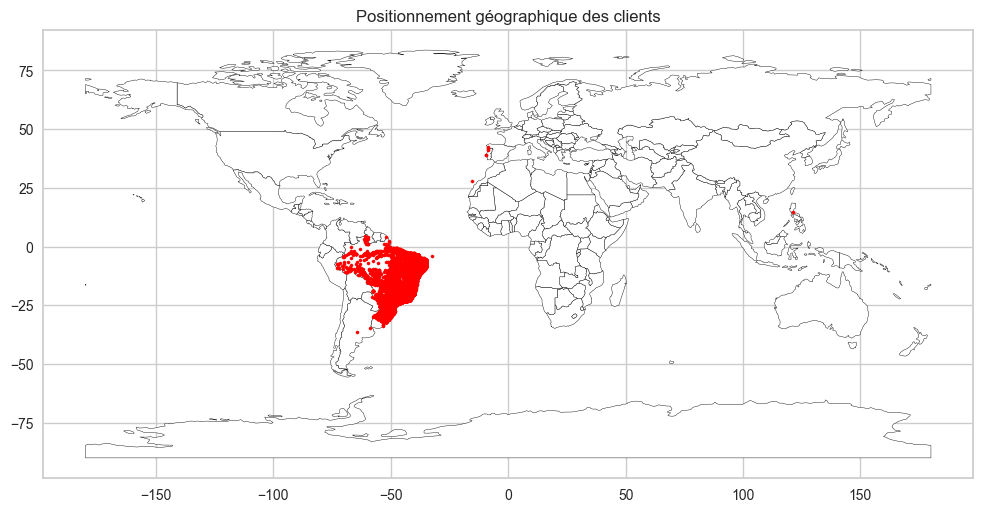

In [158]:
# Création d'une carte du monde avec la position GPS des points fournies dans le dataframe
geo_df = df_geolocation.copy()
geo_df = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.geolocation_lng, geo_df.geolocation_lat)
)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect("equal")
world.plot(ax=ax, color="white", edgecolor="black")
geo_df.plot(ax=ax, marker="o", color="red", markersize=5)
ax.set_title("Positionnement géographique des clients");

#### <a name="C7115">7.1.1.5 df_order_items</a>

In [159]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_unit_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


In [160]:
df_tmp2 = (
    df_order_items.groupby(["order_id"])["total_unit_price"].sum().reset_index()
)  # agrégation
df_tmp2.columns = ["order_id", "total_price"]
df_tmp2.head()

,order_id,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [161]:
print("moy:\n", df_tmp2["total_price"].mean())
print("med:\n", df_tmp2["total_price"].median())
print("mod:\n", df_tmp2["total_price"].mode())

moy:
 160.57763809214927
med:
 105.29
mod:
 0    77.57
Name: total_price, dtype: float64


In [162]:
# Mesure de dispersion :
print("Ecart type:\n", df_tmp2["total_price"].std(ddof=0))  # Ecart type empirique
print("Var:\n", df_tmp2["total_price"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_tmp2["total_price"].std() / df_tmp2["total_price"].mean(),
)

Ecart type:
 220.46496927761578
Var:
 48604.80267858007
Coefficient de variation CV : 1.3729563414568866


In [163]:
tmp = df_tmp2["total_price"]
tmp.describe()

count    98666.000000
mean       160.577638
std        220.466087
min          9.590000
25%         61.980000
50%        105.290000
75%        176.870000
max      13664.080000
Name: total_price, dtype: float64

In [164]:
# Selection des prix totaux inférieurs à 1000 pour ne pas écraser le graphe de répartition vers la gauche
df_tmp3 = df_tmp2.loc[df_tmp2["total_price"] < 1000]

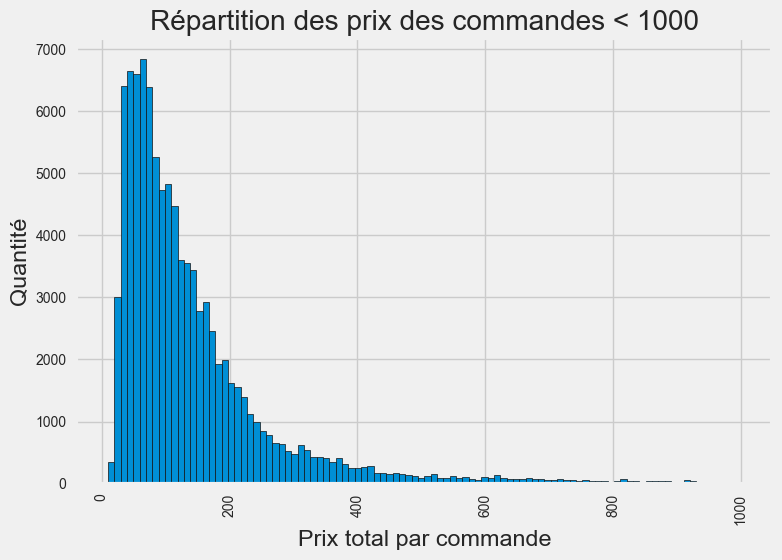

In [165]:
plt.style.use("fivethirtyeight")
# Visualisation de la distribution
plt.hist(df_tmp3["total_price"], edgecolor="k", bins=100)
plt.xticks(rotation="vertical")
plt.title("Répartition des prix des commandes < 1000")
plt.xlabel("Prix total par commande")
plt.ylabel("Quantité");

In [166]:
df_tmp = df_order_items.groupby(["order_id"]).size().reset_index()  # agrégation
df_tmp.columns = ["order_id", "nb_product_by_order"]
df_tmp_sort = df_tmp.sort_values(
    "nb_product_by_order"
)  # trie de la quantité par ordre croissant

# Pour l'affichage du tableau dans l'ordre décroissant :
df_tmp_sort = df_tmp_sort.sort_values(
    "nb_product_by_order", ascending=False
).reset_index(
    drop=True
)  # trie de la quantité par ordre croissant
df_tmp_sort.head()

,order_id,nb_product_by_order
0,8272b63d03f5f79c56e9e4120aec44ef,21
1,ab14fdcfbe524636d65ee38360e22ce8,20
2,1b15974a0141d54e36626dca3fdc731a,20
3,9ef13efd6949e4573a18964dd1bbe7f5,15
4,428a2f660dc84138d969ccd69a0ab6d5,15


In [167]:
df_tmp = df_tmp_sort.groupby("nb_product_by_order").size().reset_index()  # agrégation
df_tmp.columns = ["nb_product_by_order", "nb_order"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values("nb_product_by_order", ascending=True).reset_index(
    drop=True
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round((df_tmp_sort["nb_order"] / df_tmp["nb_order"].sum()) * 100, 2)
df_tmp_sort.head(30)

,nb_product_by_order,nb_order,%
0,1,88863,90.06
1,2,7516,7.62
2,3,1322,1.34
3,4,505,0.51
4,5,204,0.21
5,6,198,0.20
6,7,22,0.02
7,8,8,0.01
8,9,3,0.00
9,10,8,0.01


[Text(0, 0, '88863'),
 Text(0, 0, '7516'),
 Text(0, 0, '1322'),
 Text(0, 0, '505'),
 Text(0, 0, '204'),
 Text(0, 0, '198'),
 Text(0, 0, '22'),
 Text(0, 0, '8'),
 Text(0, 0, '3'),
 Text(0, 0, '8'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

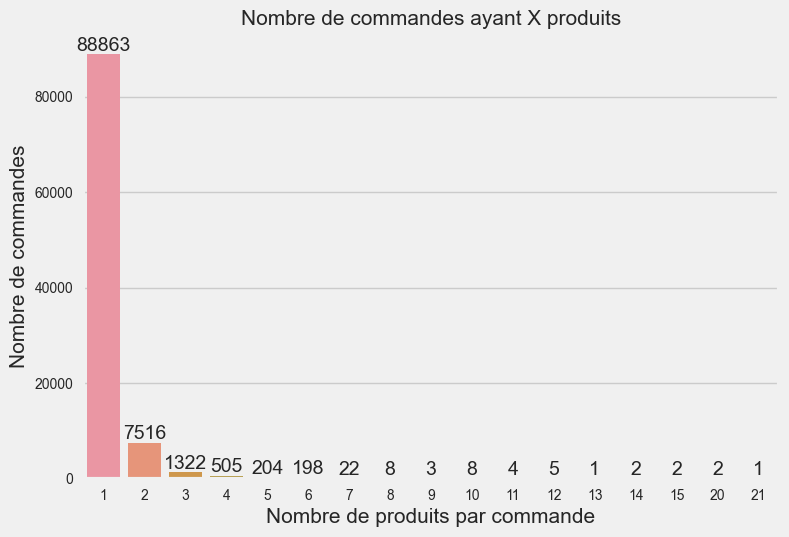

In [168]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(
    data=df_tmp_sort, x="nb_product_by_order", y="nb_order"
)  # Création du barplot
plt.title("Nombre de commandes ayant X produits", fontsize=15)
plt.ylabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de produits par commande", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '90.06'),
 Text(0, 0, '7.62'),
 Text(0, 0, '1.34'),
 Text(0, 0, '0.51'),
 Text(0, 0, '0.21'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.02'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

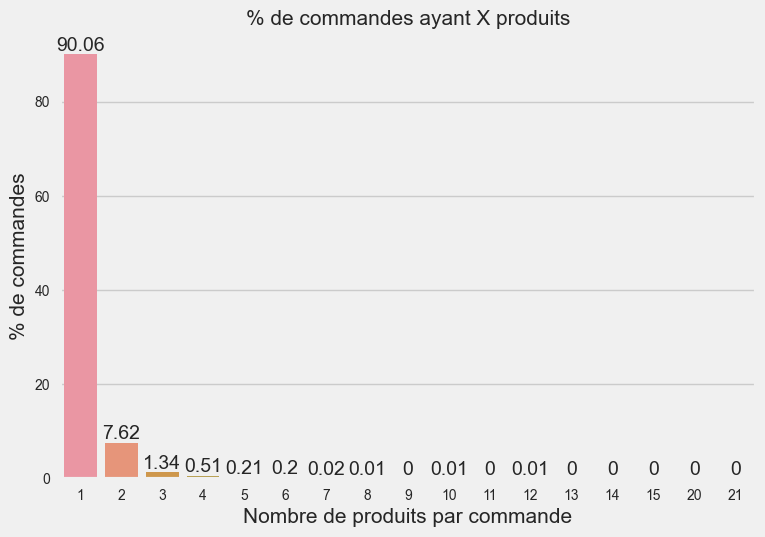

In [169]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(
    data=df_tmp_sort, x="nb_product_by_order", y="%"
)  # Création du barplot
plt.title("% de commandes ayant X produits", fontsize=15)
plt.ylabel("% de commandes", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de produits par commande", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

#### <a name="C7116">7.1.1.6 df_products</a>

In [170]:
# affichage3D(df,x,y,z,color)
affichage3D(
    df_products,
    "product_length_cm",
    "product_width_cm",
    "product_height_cm",
    "product_weight_g",
)

In [171]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


### <a name="C712">7.1.2 Variables catégorielles</a>

In [172]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_unique_id                  99441 non-null  object 
 1   customer_zip_code_prefix            99441 non-null  object 
 2   customer_city                       99441 non-null  object 
 3   customer_state                      99441 non-null  object 
 4   order_id                            96461 non-null  object 
 5   order_status                        96461 non-null  object 
 6   s1_duree_approbation                96461 non-null  float64
 7   s2_attente_prise_transport          96461 non-null  float64
 8   s3_duree_transport                  96461 non-null  float64
 9   s123_duree_attente_client           96461 non-null  float64
 10  retard_livraison                    96461 non-null  f

#### <a name="C7121">7.1.2.1 df_geolocation</a>

Pas d'information utile à étudier sur les "objets" sur ce dataframe isolé

#### <a name="C7122">7.1.2.2 df_order_items</a>

In [173]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_unit_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


In [174]:
# Calcul du motant total de vente par vendeur
df_tmp = df_order_items.groupby("seller_id")["total_unit_price"].sum().reset_index()
df_tmp.columns = ["seller_id", "sommes_ventes"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values(
    "sommes_ventes", ascending=False
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round(
    (df_tmp_sort["sommes_ventes"] / df_tmp_sort["sommes_ventes"].sum()) * 100, 2
)
df_tmp_sort.head()

,seller_id,sommes_ventes,%
857,4869f7a5dfa277a7dca6462dcf3b52b2,249640.70,1.58
1535,7c67e1448b00f6e969d365cea6b010ab,239536.44,1.51
1013,53243585a1d6dc2643021fd1853d8905,235856.68,1.49
881,4a3ca9315b744ce9f8e9374361493884,235539.96,1.49
3024,fa1c13f2614d7b5c4749cbc52fecda94,204084.73,1.29


In [175]:
# Calcul du prix total par commande
df_tmp = df_order_items.groupby("order_id")["total_unit_price"].sum().reset_index()
df_tmp.columns = ["order_id", "sommes_ventes"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values(
    "sommes_ventes", ascending=False
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round(
    (df_tmp_sort["sommes_ventes"] / df_tmp_sort["sommes_ventes"].sum()) * 100, 2
)
df_tmp_sort.head()

,order_id,sommes_ventes,%
1455,03caa2c082116e1d31e67e9ae3700499,13664.08,0.09
44467,736e1922ae60d0d6a89247b851902527,7274.88,0.05
3130,0812eb902a67711a1cb742b3cdaa65ae,6929.31,0.04
98298,fefacc66af859508bf1a7934eab1e97f,6922.21,0.04
94439,f5136e38d1a14a4dbd87dff67da82701,6726.66,0.04


In [176]:
# Calcul du panier moyen par commande
df_tmp = df_order_items.groupby("order_id")["total_unit_price"].mean().reset_index()
df_tmp.columns = ["order_id", "moyennes_ventes"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values(
    "moyennes_ventes", ascending=False
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round(
    (df_tmp_sort["moyennes_ventes"] / df_tmp_sort["moyennes_ventes"].sum()) * 100, 2
)
df_tmp_sort.head()

,order_id,moyennes_ventes,%
3130,0812eb902a67711a1cb742b3cdaa65ae,6929.31,0.05
98298,fefacc66af859508bf1a7934eab1e97f,6922.21,0.05
94439,f5136e38d1a14a4dbd87dff67da82701,6726.66,0.05
65046,a96610ab360d42a2e5335a3998b4718a,4950.34,0.03
9868,199af31afc78c699f0dbf71fb178d4d4,4764.34,0.03


#### <a name="C7123">7.1.2.3 df_order_payments</a>

In [177]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [178]:
df_tmp = df_order_payments.groupby("payment_type").sum()
df_tmp.head()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4952\1822572290.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,payment_sequential,payment_installments,payment_value
payment_type,,,
boleto,19785,19784,2869361.27
credit_card,77115,269332,12542084.19
debit_card,1582,1529,217989.79
not_defined,3,3,0.00
voucher,15029,5775,379436.87


### <a name="C713">7.1.3 Variables numériques vs catégorielle</a>

#### <a name="C7131">7.1.3.1 Distance vendeurs/clients et score</a>

<AxesSubplot: title={'center': 'Distance client vendeurs et scores'}, xlabel='review_score', ylabel='distance_customer_seller_km'>

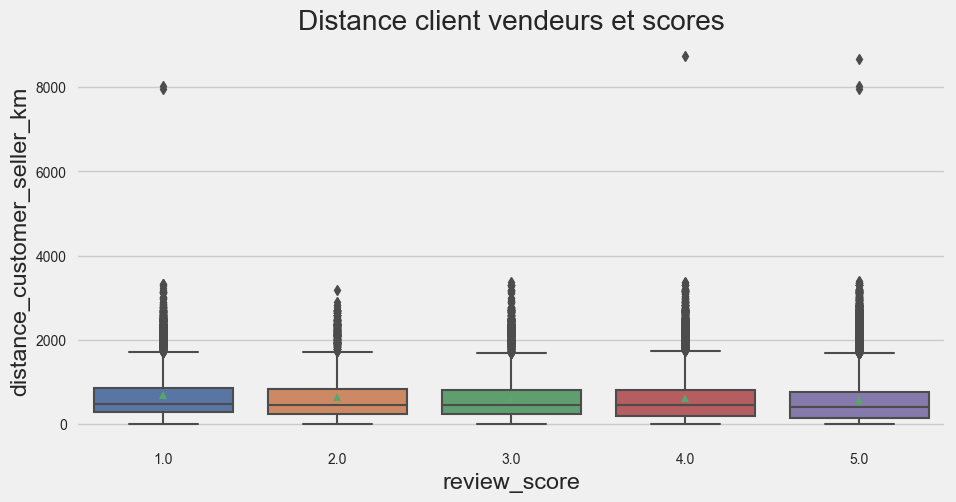

In [179]:
plt.figure(figsize=(10, 5))
plt.title("Distance client vendeurs et scores")
sns.set(style="whitegrid")
sns.boxplot(
    x="review_score",
    y="distance_customer_seller_km",
    data=df_customers_orders_reviews_items_geolocation_sellers,
    showmeans=True,
)

#### <a name="C7132">7.1.3.2 Retard de livraison et score</a>

<AxesSubplot: title={'center': 'Retard de livraison et score'}, xlabel='review_score', ylabel='retard_livraison_class'>

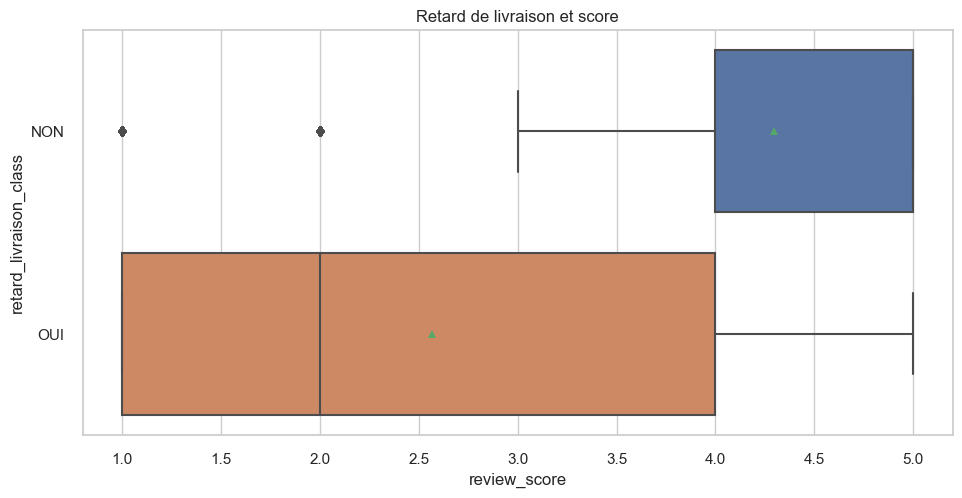

In [180]:
plt.figure(figsize=(10, 5))
plt.title("Retard de livraison et score")
sns.set(style="whitegrid")
sns.boxplot(
    x="review_score",
    y="retard_livraison_class",
    data=df_customers_orders_reviews,
    showmeans=True,
)

In [181]:
# ANNOVA
df_customers_orders_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customer_id                 99441 non-null  object        
 1   customer_unique_id          99441 non-null  object        
 2   customer_zip_code_prefix    99441 non-null  object        
 3   customer_city               99441 non-null  object        
 4   customer_state              99441 non-null  object        
 5   order_id                    96461 non-null  object        
 6   order_status                96461 non-null  object        
 7   order_purchase_timestamp    96461 non-null  datetime64[ns]
 8   s1_duree_approbation        96461 non-null  float64       
 9   s2_attente_prise_transport  96461 non-null  float64       
 10  s3_duree_transport          96461 non-null  float64       
 11  s123_duree_attente_client   96461 non-null  float64   

In [182]:
df_tmp = df_customers_orders_reviews[["review_score", "retard_livraison_class"]].copy()
df_tmp.dropna(axis=0, inplace=True)
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95815 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review_score            95815 non-null  float64
 1   retard_livraison_class  95815 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [183]:
# Calcul ANNOVA
eta_squared(df_tmp["review_score"], df_tmp["retard_livraison_class"])

0.1332087869591925

retard_livraison_class,NON,OUI,Total
review_score,,,
1.0,5815,3540,9355
2.0,2318,602,2920
3.0,7043,873,7916
4.0,17940,944,18884
5.0,55038,1702,56740
Total,88154,7661,95815


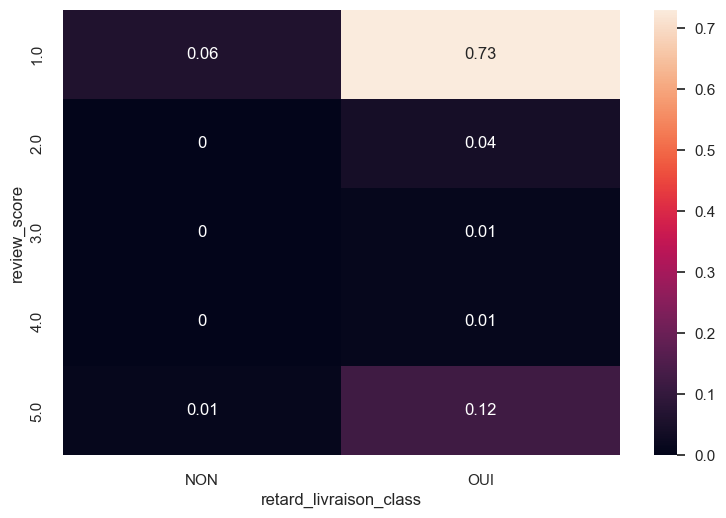

In [184]:
# test Chi2 en passant la variable score en objet
df_tmp["review_score"] = df_tmp["review_score"].astype("object")
chi02(df_tmp, "review_score", "retard_livraison_class")
df_tmp["review_score"] = df_tmp["review_score"].astype("float64")

#### <a name="C7133">7.1.3.3 RFM et score</a>

<AxesSubplot: title={'center': 'Customer_segment rfm et score'}, xlabel='review_score', ylabel='Customer_segment'>

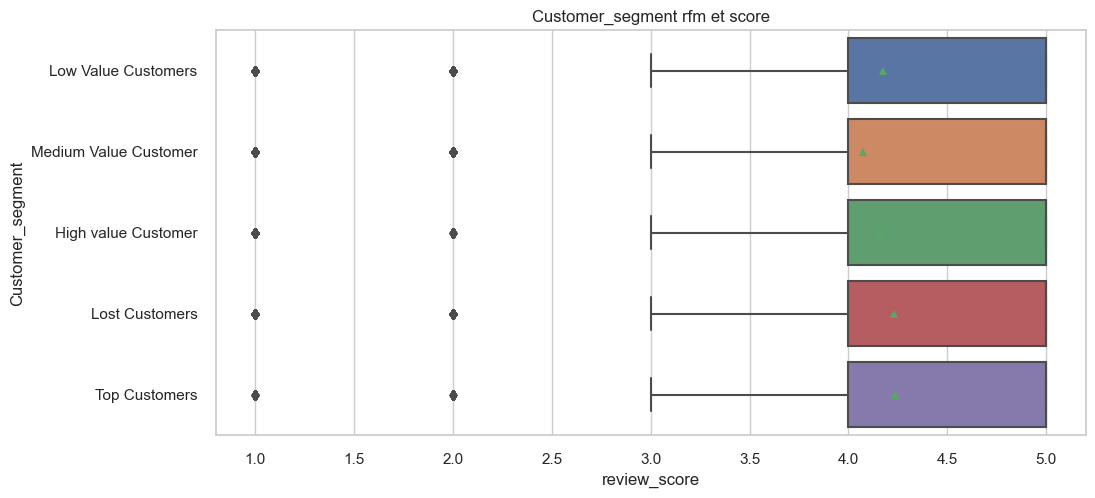

In [185]:
plt.figure(figsize=(10, 5))
plt.title("Customer_segment rfm et score")
sns.set(style="whitegrid")
sns.boxplot(
    x="review_score",
    y="Customer_segment",
    data=df_customers_orders_reviews_items_geolocation_sellers_rfm,
    showmeans=True,
)

## <a name="C72">7.2 Analyses univariées </a>

### <a name="C721">7.2.1 Variables numériques</a>

#### <a name="C7211">7.2.1.1 df_customers</a>

Pas de variables numériques

#### <a name="C4712">7.2.1.2 df_geolocation</a>

Pas de variables numériques unitaires pertinentes à analyser en analyse univariée

#### <a name="C4713">7.2.1.3 df_order_items</a>

##### <a name="C42131">7.2.1.3.1 price</a>

In [186]:
# Mesure de tendances centrales
print("moy:\n", df_order_items["price"].mean())
print("med:\n", df_order_items["price"].median())
print("mod:\n", df_order_items["price"].mode())

moy:
 120.65373901464716
med:
 74.99
mod:
 0    59.9
Name: price, dtype: float64


In [187]:
# Mesure de dispersion :
print("Ecart type:\n", df_order_items["price"].std(ddof=0))  # Ecart type empirique
print("Var:\n", df_order_items["price"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_items["price"].std() / df_order_items["price"].mean(),
)

Ecart type:
 183.63311298441124
Var:
 33721.12018434555
Coefficient de variation CV : 1.5219911919013678


In [188]:
data_tmp = df_order_items["price"]
data_tmp.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

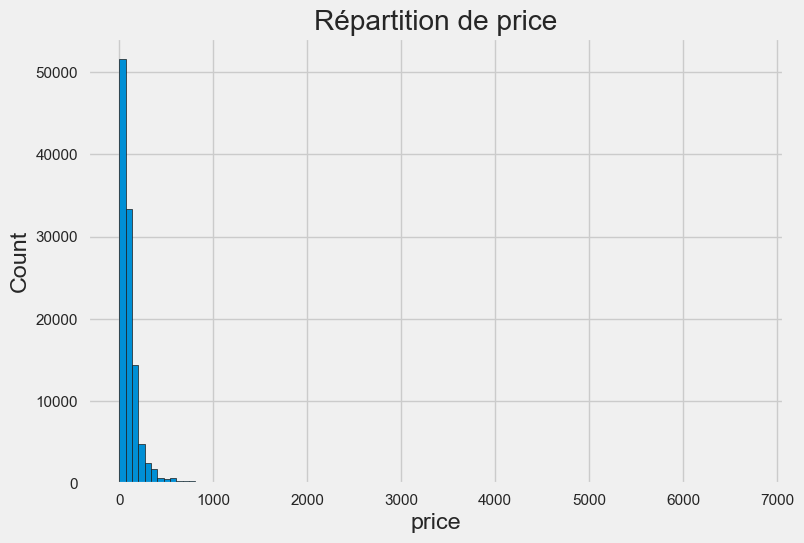

In [189]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_items["price"], edgecolor="k", bins=100)
plt.title("Répartition de price")
plt.xlabel("price")
plt.ylabel("Count");

##### <a name="C72132">7.2.1.3.2 freight value</a>

In [190]:
# Mesure de tendances centrales
print("moy:\n", df_order_items["freight_value"].mean())
print("med:\n", df_order_items["freight_value"].median())
print("mod:\n", df_order_items["freight_value"].mode())

moy:
 19.990319928983578
med:
 16.26
mod:
 0    15.1
Name: freight_value, dtype: float64


In [191]:
# Mesure de dispersion :
print(
    "Ecart type:\n", df_order_items["freight_value"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_order_items["freight_value"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_items["freight_value"].std() / df_order_items["freight_value"].mean(),
)

Ecart type:
 15.806335254993527
Var:
 249.8402341932513
Coefficient de variation CV : 0.7907029736617512


In [192]:
data_tmp = df_order_items["freight_value"]
data_tmp.describe()

count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

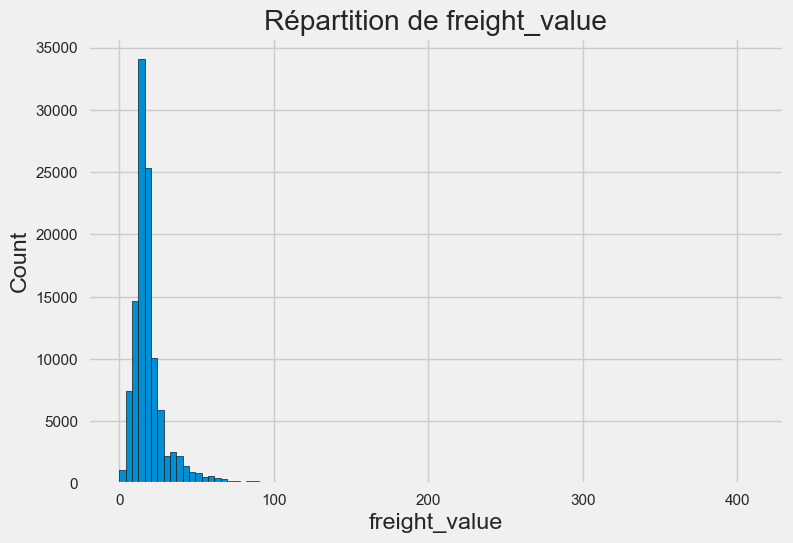

In [193]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_items["freight_value"], edgecolor="k", bins=100)
plt.title("Répartition de freight_value")
plt.xlabel("freight_value")
plt.ylabel("Count");

##### <a name="C72133">7.2.1.3.3 total_unit_price</a>

In [194]:
# Mesure de tendances centrales
print("moy:\n", df_order_items["total_unit_price"].mean())
print("med:\n", df_order_items["total_unit_price"].median())
print("mod:\n", df_order_items["total_unit_price"].mode())

moy:
 140.6440589436307
med:
 92.32000000000001
mod:
 0    77.57
Name: total_unit_price, dtype: float64


In [195]:
# Mesure de dispersion :
print(
    "Ecart type:\n", df_order_items["total_unit_price"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_order_items["total_unit_price"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_items["total_unit_price"].std()
    / df_order_items["total_unit_price"].mean(),
)

Ecart type:
 190.72354749460217
Var:
 36375.47156892577
Coefficient de variation CV : 1.3560785678702707


In [196]:
data_tmp = df_order_items["total_unit_price"]
data_tmp.describe()

count    112650.000000
mean        140.644059
std         190.724394
min           6.080000
25%          55.220000
50%          92.320000
75%         157.937500
max        6929.310000
Name: total_unit_price, dtype: float64

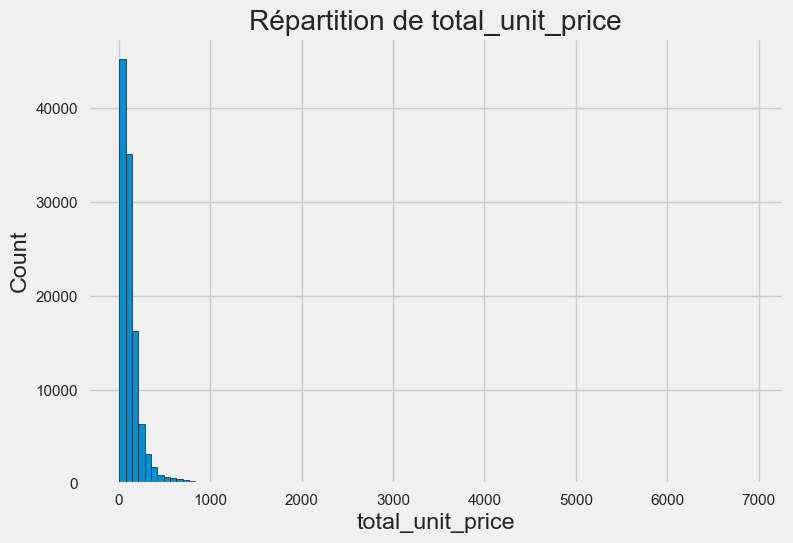

In [197]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_items["total_unit_price"], edgecolor="k", bins=100)
plt.title("Répartition de total_unit_price")
plt.xlabel("total_unit_price")
plt.ylabel("Count");

#### <a name="C7214">7.2.1.4 df_order_payments</a>

##### <a name="C72141">7.2.1.4.1 payment_sequential</a>

In [198]:
# Mesure de tendances centrales
print("moy:\n", df_order_payments["payment_sequential"].mean())
print("med:\n", df_order_payments["payment_sequential"].median())
print("mod:\n", df_order_payments["payment_sequential"].mode())

moy:
 1.0926785129853878
med:
 1.0
mod:
 0    1
Name: payment_sequential, dtype: int64


In [199]:
# Mesure de dispersion :
print(
    "Ecart type:\n", df_order_payments["payment_sequential"].std(ddof=0)
)  # Ecart type empirique
print(
    "Var:\n", df_order_payments["payment_sequential"].var(ddof=0)
)  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_payments["payment_sequential"].std()
    / df_order_payments["payment_sequential"].mean(),
)

Ecart type:
 0.7065803784216499
Var:
 0.49925583117048195
Coefficient de variation CV : 0.6466529457639703


In [200]:
data_tmp = df_order_payments["payment_sequential"]
data_tmp.describe()

count    103886.000000
mean          1.092679
std           0.706584
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          29.000000
Name: payment_sequential, dtype: float64

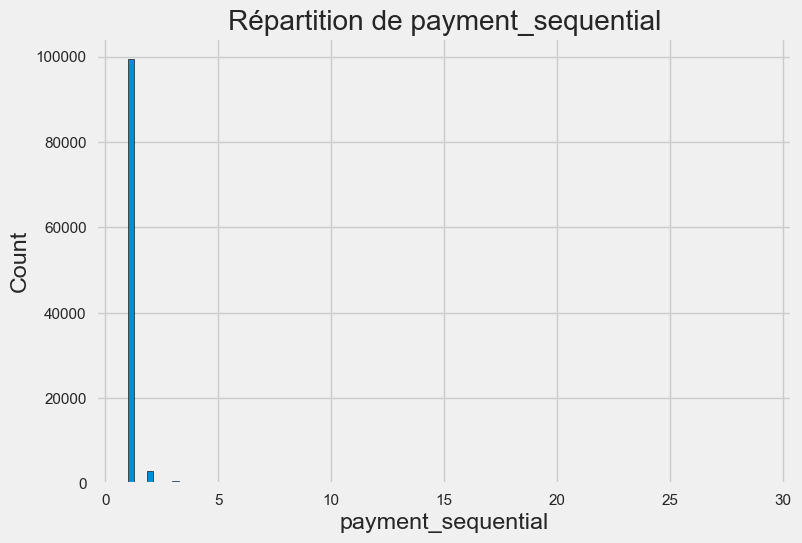

In [201]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_payments["payment_sequential"], edgecolor="k", bins=100)
plt.title("Répartition de payment_sequential")
plt.xlabel("payment_sequential")
plt.ylabel("Count");

##### <a name="C72142">7.2.1.4.2 payment_installments</a>

In [202]:
# Mesures de tendances centrales
print("moy:\n", df_order_payments["payment_installments"].mean())
print("med:\n", df_order_payments["payment_installments"].median())
print("mod:\n", df_order_payments["payment_installments"].mode())

moy:
 2.853348863176944
med:
 1.0
mod:
 0    1
Name: payment_installments, dtype: int64


In [203]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_order_payments["payment_installments"].std(ddof=0)
)  # Ecart type empirique
print(
    "Var:\n", df_order_payments["payment_installments"].var(ddof=0)
)  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_payments["payment_installments"].std()
    / df_order_payments["payment_installments"].mean(),
)

Ecart type:
 2.6870377411362854
Var:
 7.22017182229079
Coefficient de variation CV : 0.9417182415138307


In [204]:
data_tmp = df_order_payments["payment_installments"]
data_tmp.describe()

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

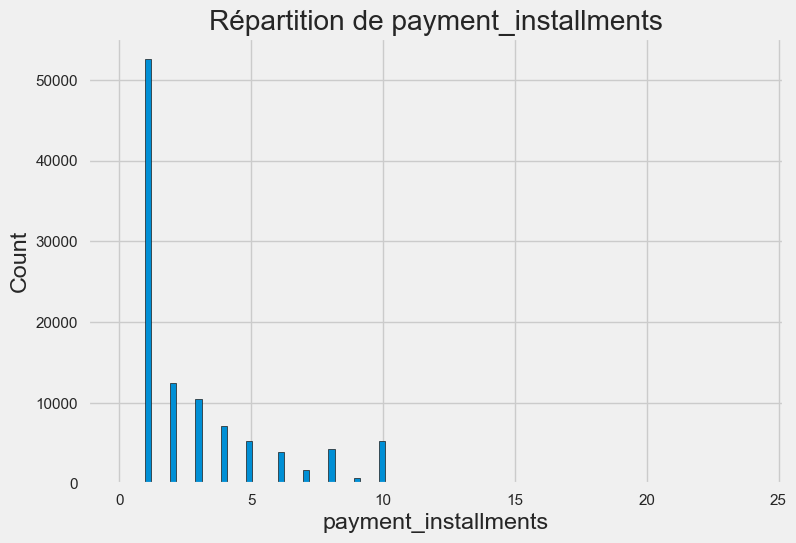

In [205]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_payments["payment_installments"], edgecolor="k", bins=100)
plt.title("Répartition de payment_installments")
plt.xlabel("payment_installments")
plt.ylabel("Count");

##### <a name="C72143">7.2.1.4.3 payment_value</a>

In [206]:
# Mesures de tendances centrales
print("moy:\n", df_order_payments["payment_value"].mean())
print("med:\n", df_order_payments["payment_value"].median())
print("mod:\n", df_order_payments["payment_value"].mode())

moy:
 154.10038041699553
med:
 100.0
mod:
 0    50.0
Name: payment_value, dtype: float64


In [207]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_order_payments["payment_value"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_order_payments["payment_value"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_payments["payment_value"].std()
    / df_order_payments["payment_value"].mean(),
)

Ecart type:
 217.49301707022238
Var:
 47303.21247430804
Coefficient de variation CV : 1.41137914959188


In [208]:
data_tmp = df_order_payments["payment_value"]
data_tmp.describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

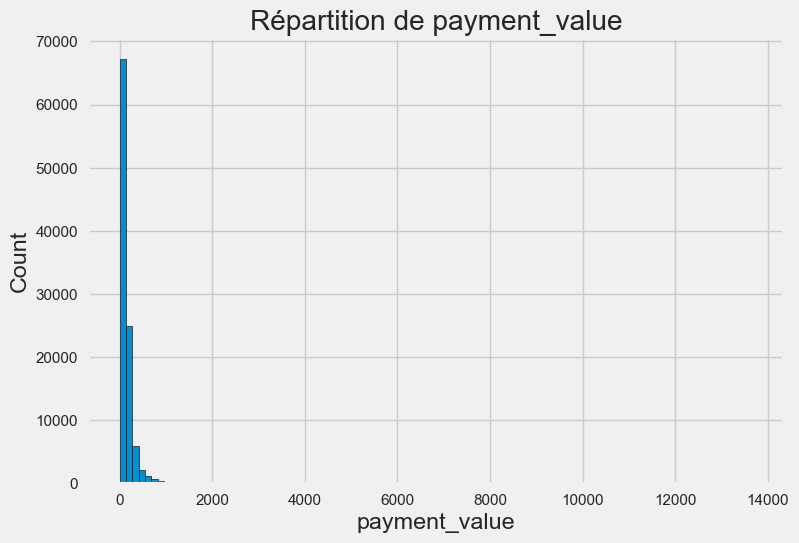

In [209]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_order_payments["payment_value"], edgecolor="k", bins=100)
plt.title("Répartition de payment_value")
plt.xlabel("payment_value")
plt.ylabel("Count");

#### <a name="C7215">7.2.1.5 df_order_reviews</a>

##### <a name="C72151">7.2.1.5.1 review_score</a>

In [210]:
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 80582 to 37547
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                98673 non-null  object        
 1   order_id                 98673 non-null  object        
 2   review_score             98673 non-null  int64         
 3   review_comment_title     98673 non-null  object        
 4   review_comment_message   98673 non-null  object        
 5   review_creation_date     98673 non-null  datetime64[ns]
 6   review_answer_timestamp  98673 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 6.0+ MB


In [211]:
# Mesures de tendances centrales
print("moy:\n", df_order_reviews["review_score"].mean())
print("med:\n", df_order_reviews["review_score"].median())
print("mod:\n", df_order_reviews["review_score"].mode())

moy:
 4.086386346822333
med:
 5.0
mod:
 0    5
Name: review_score, dtype: int64


In [212]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_order_reviews["review_score"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_order_reviews["review_score"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_order_reviews["review_score"].std() / df_order_reviews["review_score"].mean(),
)

Ecart type:
 1.3476110284761251
Var:
 1.81605548407048
Coefficient de variation CV : 0.32978229242753376


In [213]:
data_tmp = df_order_reviews["review_score"]
data_tmp.describe()

count    98673.000000
mean         4.086386
std          1.347618
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

In [214]:
df_tmp = df_order_reviews["review_score"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["review_score", "nb_customers"]
df_tmp_sort = df_tmp.sort_values(by="review_score", ascending=True)
df_tmp_sort["%"] = (df_tmp_sort["nb_customers"] / df_order_reviews.shape[0]) * 100
df_tmp_sort["%"] = round(df_tmp_sort["%"], 1)
df_tmp_sort.head(20)

,review_score,nb_customers,%
2,1,11363,11.5
4,2,3131,3.2
3,3,8133,8.2
1,4,19038,19.3
0,5,57008,57.8


[Text(0, 0, '11363'),
 Text(0, 0, '3131'),
 Text(0, 0, '8133'),
 Text(0, 0, '19038'),
 Text(0, 0, '57008')]

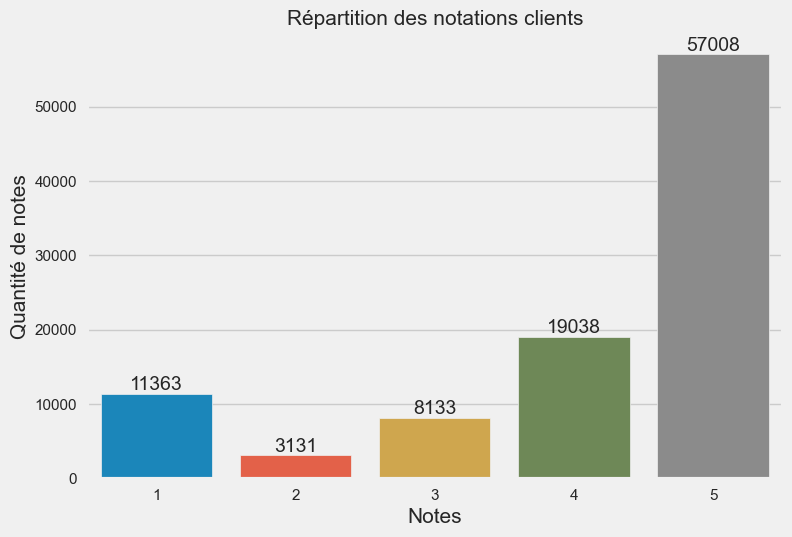

In [215]:
ax = sns.barplot(data=df_tmp_sort, x="review_score", y="nb_customers")
plt.title("Répartition des notations clients", fontsize=15)
plt.ylabel("Quantité de notes", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Notes", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '11.5'),
 Text(0, 0, '3.2'),
 Text(0, 0, '8.2'),
 Text(0, 0, '19.3'),
 Text(0, 0, '57.8')]

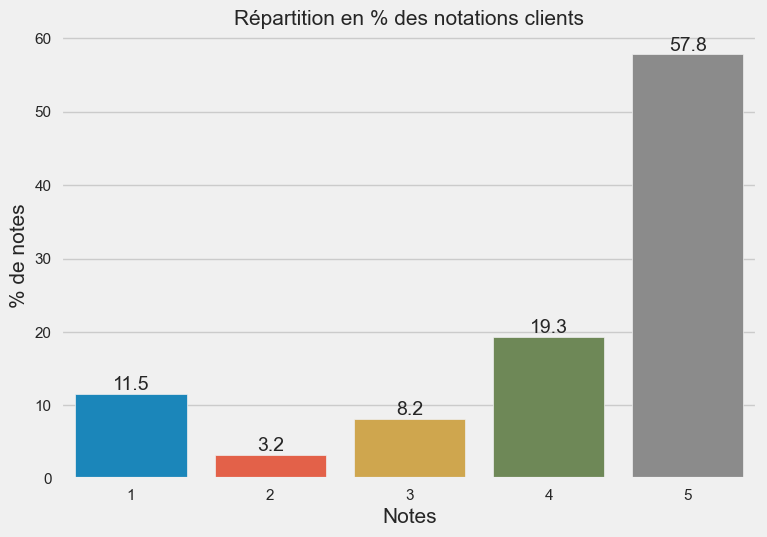

In [216]:
ax = sns.barplot(data=df_tmp_sort, x="review_score", y="%")
plt.title("Répartition en % des notations clients", fontsize=15)
plt.ylabel("% de notes", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Notes", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

#### <a name="C7216">7.2.1.6 df_orders</a>

##### <a name="C72161">7.2.1.6.1 s1_duree_approbation</a>

In [217]:
# Mesures de tendances centrales
print("moy:\n", df_orders["s1_duree_approbation"].mean())
print("med:\n", df_orders["s1_duree_approbation"].median())
print("mod:\n", df_orders["s1_duree_approbation"].mode())

moy:
 0 days 10:16:39.837893034
med:
 0 days 00:20:36
mod:
 0   0 days
Name: s1_duree_approbation, dtype: timedelta64[ns]


In [218]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_orders["s1_duree_approbation"].std(ddof=0)
)  # Ecart type empirique
# print("Var:\n",df_orders['1_duree_approbation'].var(ddof=0)) #Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_orders["s1_duree_approbation"].std() / df_orders["s1_duree_approbation"].mean(),
)

Ecart type:
 0 days 20:32:07.760860539
Coefficient de variation CV : 1.998066701738132


In [219]:
data_tmp = df_orders["s1_duree_approbation"]
data_tmp.describe()

count                        96461
mean     0 days 10:16:39.837893034
std      0 days 20:32:08.144063780
min                0 days 00:00:00
25%                0 days 00:12:55
50%                0 days 00:20:36
75%                0 days 14:31:05
max               30 days 21:26:37
Name: s1_duree_approbation, dtype: object

In [220]:
# Conversion en minute
df_tmp = pd.to_timedelta(
    df_orders["s1_duree_approbation"] / pd.Timedelta("60s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s1_duree_approbation = df_tmp.s1_duree_approbation.astype("int64")
data_tmp = df_tmp["s1_duree_approbation"]
data_tmp.describe()

count    96461.000000
mean       616.178777
std       1232.131340
min          0.000000
25%         12.000000
50%         20.000000
75%        871.000000
max      44486.000000
Name: s1_duree_approbation, dtype: float64

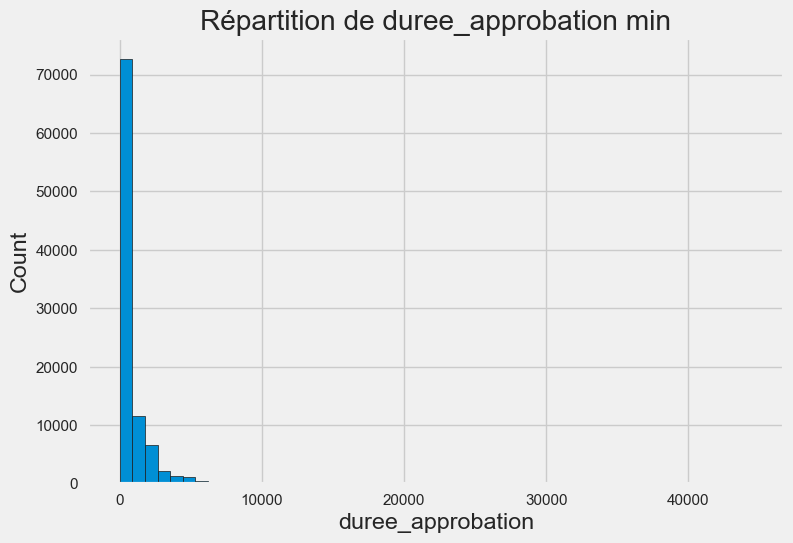

In [221]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s1_duree_approbation"], edgecolor="k", bins=50)
plt.title("Répartition de duree_approbation min")
plt.xlabel("duree_approbation")
plt.ylabel("Count");

In [222]:
# Conversion en heure
df_tmp = pd.to_timedelta(
    df_orders["s1_duree_approbation"] / pd.Timedelta("3600s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s1_duree_approbation = df_tmp.s1_duree_approbation.astype("int64")
data_tmp = df_tmp["s1_duree_approbation"]
data_tmp.describe()

count    96461.000000
mean         9.922767
std         20.465772
min          0.000000
25%          0.000000
50%          0.000000
75%         14.000000
max        741.000000
Name: s1_duree_approbation, dtype: float64

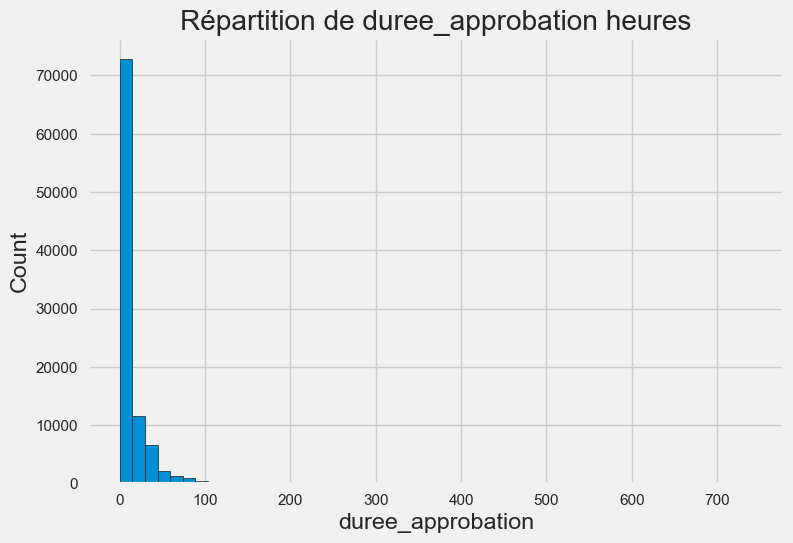

In [223]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s1_duree_approbation"], edgecolor="k", bins=50)
plt.title("Répartition de duree_approbation heures")
plt.xlabel("duree_approbation")
plt.ylabel("Count");

In [224]:
# Conversion en jours
df_tmp = pd.to_timedelta(
    df_orders["s1_duree_approbation"] / pd.Timedelta("86400s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s1_duree_approbation = df_tmp.s1_duree_approbation.astype("int64")
data_tmp = df_tmp["s1_duree_approbation"]
data_tmp.describe()

count    96461.000000
mean         0.264345
std          0.729936
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: s1_duree_approbation, dtype: float64

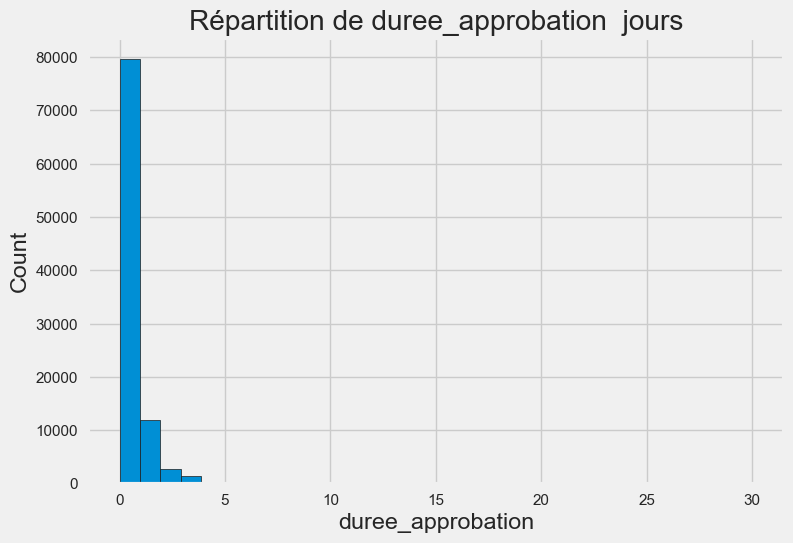

In [225]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s1_duree_approbation"], edgecolor="k", bins=31)
plt.title("Répartition de duree_approbation  jours")
plt.xlabel("duree_approbation")
plt.ylabel("Count");

##### <a name="C72162">7.2.1.6.2 s2_attente_prise_transport</a>

In [226]:
# Mesures de tendances centrales
print("moy:\n", df_orders["s2_attente_prise_transport"].mean())
print("med:\n", df_orders["s2_attente_prise_transport"].median())
print("mod:\n", df_orders["s2_attente_prise_transport"].mode())

moy:
 2 days 19:10:58.028685168
med:
 1 days 19:34:50
mod:
 0   4 days 00:00:01
Name: s2_attente_prise_transport, dtype: timedelta64[ns]


In [227]:
df_orders["s2_attente_prise_transport"].describe()

count                        96461
mean     2 days 19:10:58.028685168
std      3 days 12:54:06.348358820
min            -172 days +18:44:38
25%                0 days 20:59:05
50%                1 days 19:34:50
75%                3 days 13:48:18
max              125 days 18:18:06
Name: s2_attente_prise_transport, dtype: object

In [228]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_orders["s2_attente_prise_transport"].std(ddof=0)
)  # Ecart type empirique
# print("Var:\n",df_orders['1_duree_approbation'].var(ddof=0)) #Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_orders["s2_attente_prise_transport"].std()
    / df_orders["s2_attente_prise_transport"].mean(),
)

Ecart type:
 3 days 12:54:04.764054591
Coefficient de variation CV : 1.2637428247490046


In [229]:
# Conversion en minutes
df_tmp = pd.to_timedelta(
    df_orders["s2_attente_prise_transport"] / pd.Timedelta("60s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s2_attente_prise_transport = df_tmp.s2_attente_prise_transport.astype("int64")
data_tmp = df_tmp["s2_attente_prise_transport"]
data_tmp.describe()

count     96461.000000
mean       4030.472574
std        5094.093453
min     -246555.000000
25%        1259.000000
50%        2614.000000
75%        5148.000000
max      181098.000000
Name: s2_attente_prise_transport, dtype: float64

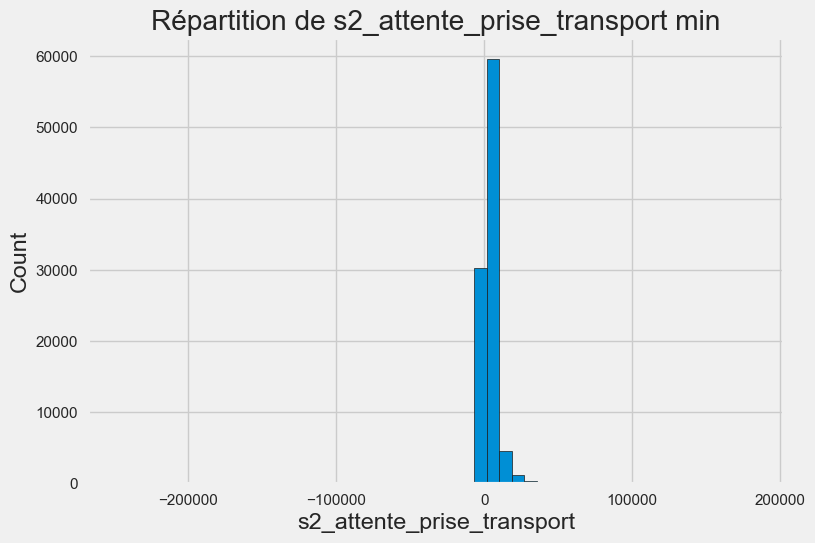

In [230]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s2_attente_prise_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s2_attente_prise_transport min")
plt.xlabel("s2_attente_prise_transport")
plt.ylabel("Count");

In [231]:
# Conversion en heures
df_tmp = pd.to_timedelta(
    df_orders["s2_attente_prise_transport"] / pd.Timedelta("3600s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s2_attente_prise_transport = df_tmp.s2_attente_prise_transport.astype("int64")
data_tmp = df_tmp["s2_attente_prise_transport"]
data_tmp.describe()

count    96461.000000
mean        66.696541
std         84.888210
min      -4109.000000
25%         20.000000
50%         43.000000
75%         85.000000
max       3018.000000
Name: s2_attente_prise_transport, dtype: float64

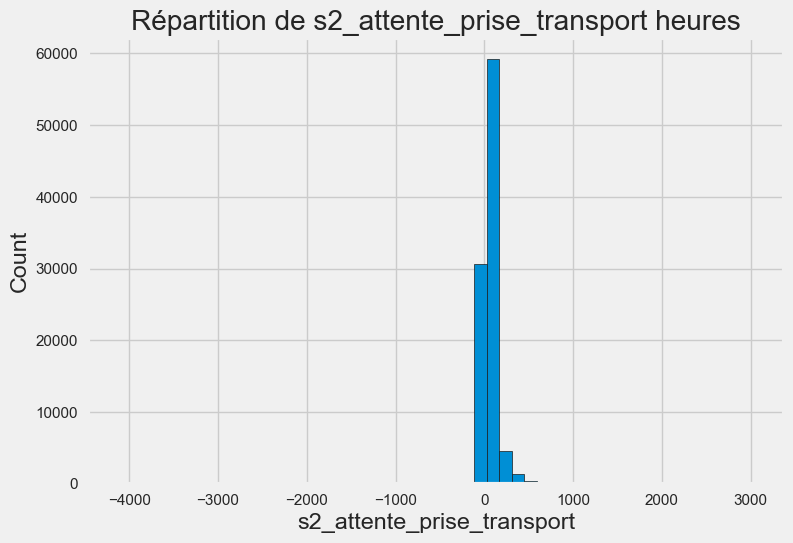

In [232]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s2_attente_prise_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s2_attente_prise_transport heures")
plt.xlabel("s2_attente_prise_transport")
plt.ylabel("Count");

In [233]:
# Conversion en jours
df_tmp = pd.to_timedelta(
    df_orders["s2_attente_prise_transport"] / pd.Timedelta("86400s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s2_attente_prise_transport = df_tmp.s2_attente_prise_transport.astype("int64")
data_tmp = df_tmp["s2_attente_prise_transport"]
data_tmp.describe()

count    96461.000000
mean         2.309918
std          3.534370
min       -171.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: s2_attente_prise_transport, dtype: float64

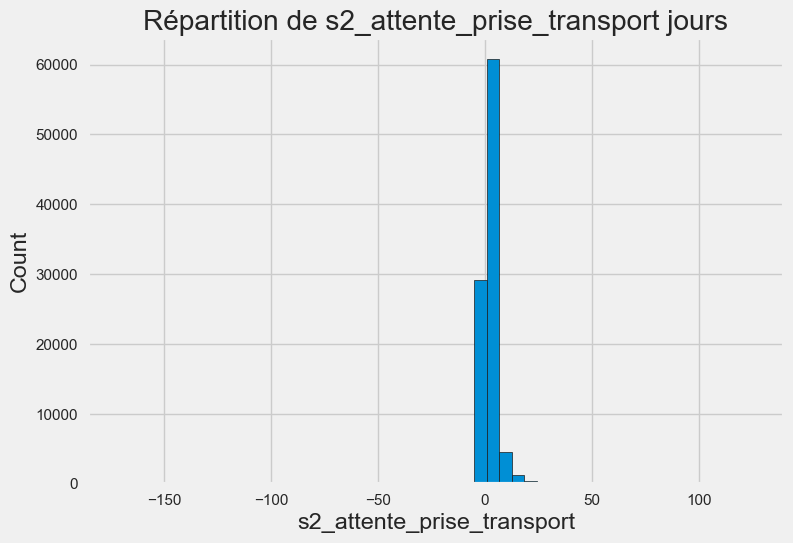

In [234]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s2_attente_prise_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s2_attente_prise_transport jours")
plt.xlabel("s2_attente_prise_transport")
plt.ylabel("Count");

##### <a name="C72163">7.2.1.6.3 s3_duree_transport</a>

In [235]:
# Mesures de tendances centrales
print("moy:\n", df_orders["s3_duree_transport"].mean())
print("med:\n", df_orders["s3_duree_transport"].median())
print("mod:\n", df_orders["s3_duree_transport"].mode())

moy:
 9 days 07:56:08.719275147
med:
 7 days 02:23:34
mod:
 0   3 days
Name: s3_duree_transport, dtype: timedelta64[ns]


In [236]:
df_orders["s3_duree_transport"].describe()

count                        96461
mean     9 days 07:56:08.719275147
std      8 days 18:15:24.626362231
min             -17 days +21:41:31
25%                4 days 02:23:26
50%                7 days 02:23:34
75%               12 days 00:42:14
max              205 days 04:35:00
Name: s3_duree_transport, dtype: object

In [237]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_orders["s3_duree_transport"].std(ddof=0)
)  # Ecart type empirique
# print("Var:\n",df_orders['1_duree_approbation'].var(ddof=0)) #Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_orders["s3_duree_transport"].std() / df_orders["s3_duree_transport"].mean(),
)

Ecart type:
 8 days 18:15:20.702877154
Coefficient de variation CV : 0.9389158972116991


In [238]:
# Conversion en minutes
df_tmp = pd.to_timedelta(
    df_orders["s3_duree_transport"] / pd.Timedelta("60s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s3_duree_transport = df_tmp.s3_duree_transport.astype("int64")
data_tmp = df_tmp["s3_duree_transport"]
data_tmp.describe()

count     96461.000000
mean      13435.626637
std       12615.419339
min      -23178.000000
25%        5903.000000
50%       10223.000000
75%       17322.000000
max      295475.000000
Name: s3_duree_transport, dtype: float64

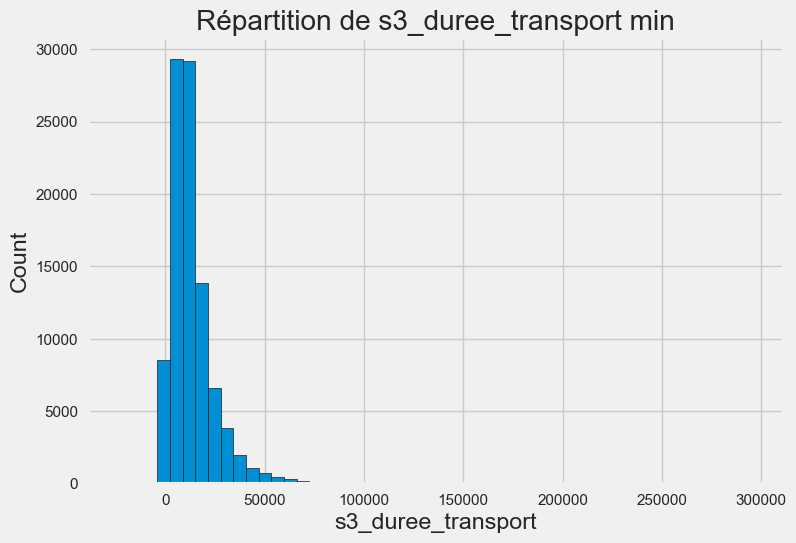

In [239]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s3_duree_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s3_duree_transport min")
plt.xlabel("s3_duree_transport")
plt.ylabel("Count");

In [240]:
# Conversion en heures
df_tmp = pd.to_timedelta(
    df_orders["s3_duree_transport"] / pd.Timedelta("3600s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s3_duree_transport = df_tmp.s3_duree_transport.astype("int64")
data_tmp = df_tmp["s3_duree_transport"]
data_tmp.describe()

count    96461.000000
mean       223.435057
std        210.256729
min       -386.000000
25%         98.000000
50%        170.000000
75%        288.000000
max       4924.000000
Name: s3_duree_transport, dtype: float64

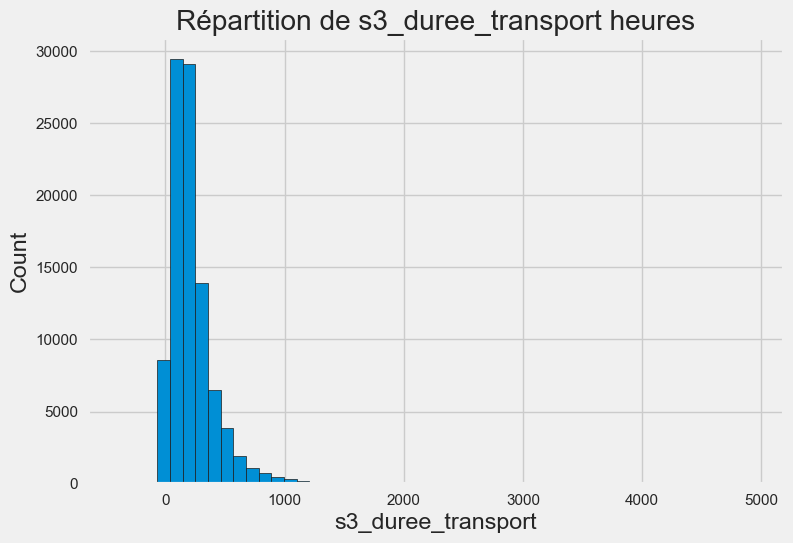

In [241]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s3_duree_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s3_duree_transport heures")
plt.xlabel("s3_duree_transport")
plt.ylabel("Count");

In [242]:
# Conversion en  jours
df_tmp = pd.to_timedelta(
    df_orders["s3_duree_transport"] / pd.Timedelta("86400s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s3_duree_transport = df_tmp.s3_duree_transport.astype("int64")
data_tmp = df_tmp["s3_duree_transport"]
data_tmp.describe()

count    96461.000000
mean         8.878635
std          8.746341
min        -16.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        205.000000
Name: s3_duree_transport, dtype: float64

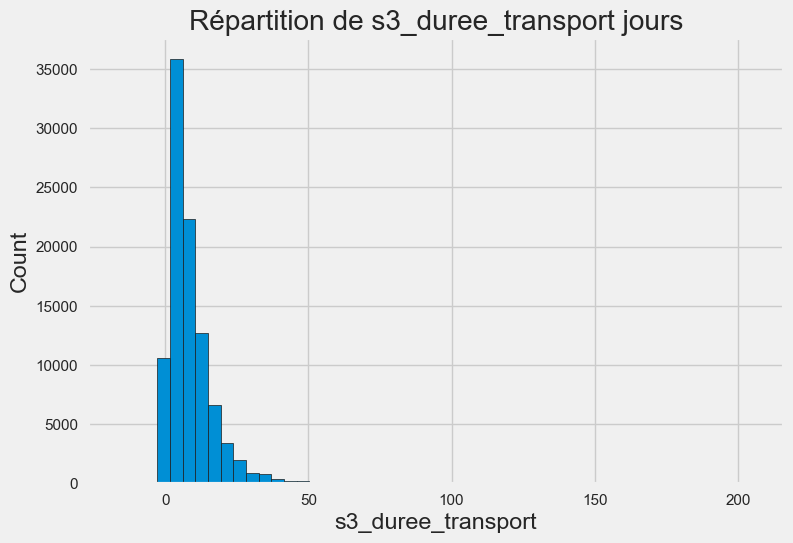

In [243]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s3_duree_transport"], edgecolor="k", bins=50)
plt.title("Répartition de s3_duree_transport jours")
plt.xlabel("s3_duree_transport")
plt.ylabel("Count");

##### <a name="C72164">7.2.1.6.4 s123_duree_attente_client</a>

In [244]:
# Mesures de tendances centrales
print("moy:\n", df_orders["s123_duree_attente_client"].mean())
print("med:\n", df_orders["s123_duree_attente_client"].median())
print("mod:\n", df_orders["s123_duree_attente_client"].mode())

moy:
 12 days 13:23:46.585853350
med:
 10 days 05:11:29
mod:
 0     2 days 01:39:27
1     2 days 08:17:19
2     2 days 21:11:15
3     3 days 04:05:41
4     4 days 02:53:59
5     5 days 05:18:32
6     5 days 06:12:31
7     5 days 08:17:27
8     5 days 19:57:44
9     5 days 21:09:39
10    5 days 23:59:25
11    6 days 01:43:37
12    6 days 01:46:31
13    6 days 04:44:59
14    6 days 07:12:18
15    6 days 07:45:25
16    6 days 21:54:05
17    6 days 22:16:12
18    7 days 00:51:09
19    7 days 01:13:41
20    7 days 02:09:11
21    7 days 02:59:00
22    7 days 03:22:34
23    7 days 20:20:47
24    7 days 21:19:47
25    8 days 00:00:30
26    8 days 00:43:54
27    8 days 05:10:59
28    8 days 06:01:33
29    8 days 19:21:50
30    8 days 22:22:36
31    9 days 00:03:05
32    9 days 00:31:15
33    9 days 19:13:08
34    9 days 21:37:14
35   10 days 01:37:10
36   10 days 01:52:22
37   10 days 20:27:54
38   10 days 21:19:30
39   10 days 22:32:07
40   11 days 02:47:53
41   11 days 03:59:08
42   11 days 0

In [245]:
df_orders["s123_duree_attente_client"].describe()

count                         96461
mean     12 days 13:23:46.585853350
std       9 days 13:06:45.121880865
min                 0 days 12:48:07
25%                 6 days 18:22:50
50%                10 days 05:11:29
75%                15 days 17:17:10
max               209 days 15:05:12
Name: s123_duree_attente_client, dtype: object

In [246]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_orders["s123_duree_attente_client"].std(ddof=0)
)  # Ecart type empirique
# print("Var:\n",df_orders['1_duree_approbation'].var(ddof=0)) #Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_orders["s123_duree_attente_client"].std()
    / df_orders["s123_duree_attente_client"].mean(),
)

Ecart type:
 9 days 13:06:40.846540264
Coefficient de variation CV : 0.7601704258999088


In [247]:
# Conversion en minutes
df_tmp = pd.to_timedelta(
    df_orders["s123_duree_attente_client"] / pd.Timedelta("60s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s123_duree_attente_client = df_tmp.s123_duree_attente_client.astype("int64")
data_tmp = df_tmp["s123_duree_attente_client"]
data_tmp.describe()

count     96461.000000
mean      18083.284726
std       13746.753370
min         768.000000
25%        9742.000000
50%       14711.000000
75%       22637.000000
max      301865.000000
Name: s123_duree_attente_client, dtype: float64

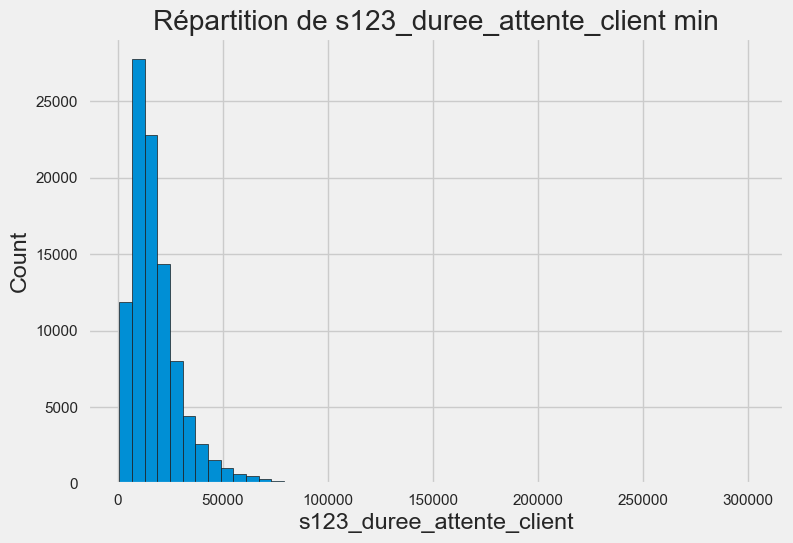

In [248]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s123_duree_attente_client"], edgecolor="k", bins=50)
plt.title("Répartition de s123_duree_attente_client min")
plt.xlabel("s123_duree_attente_client")
plt.ylabel("Count");

In [249]:
# Conversion en heures
df_tmp = pd.to_timedelta(
    df_orders["s123_duree_attente_client"] / pd.Timedelta("3600s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s123_duree_attente_client = df_tmp.s123_duree_attente_client.astype("int64")
data_tmp = df_tmp["s123_duree_attente_client"]
data_tmp.describe()

count    96461.000000
mean       300.896321
std        229.114413
min         12.000000
25%        162.000000
50%        245.000000
75%        377.000000
max       5031.000000
Name: s123_duree_attente_client, dtype: float64

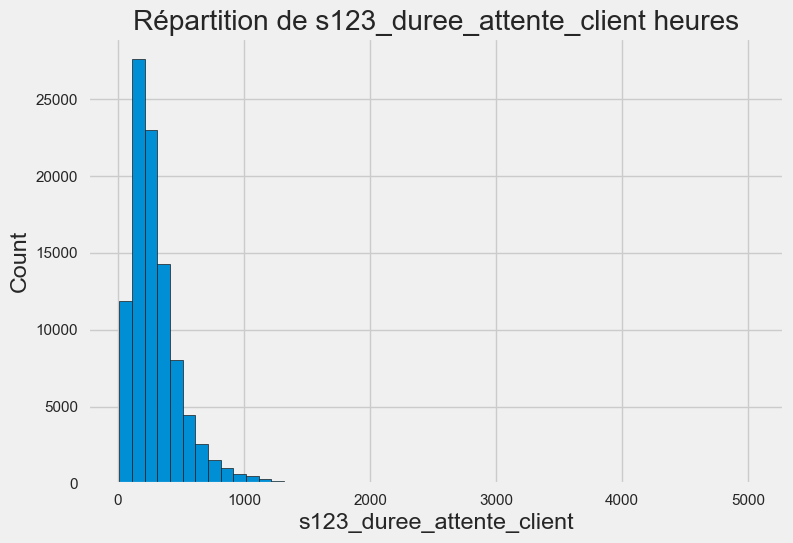

In [250]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s123_duree_attente_client"], edgecolor="k", bins=50)
plt.title("Répartition de s123_duree_attente_client heures")
plt.xlabel("s123_duree_attente_client")
plt.ylabel("Count");

In [251]:
# Conversion en jours
df_tmp = pd.to_timedelta(
    df_orders["s123_duree_attente_client"] / pd.Timedelta("86400s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.s123_duree_attente_client = df_tmp.s123_duree_attente_client.astype("int64")
data_tmp = df_tmp["s123_duree_attente_client"]
data_tmp.describe()

count    96461.000000
mean        12.093582
std          9.551576
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: s123_duree_attente_client, dtype: float64

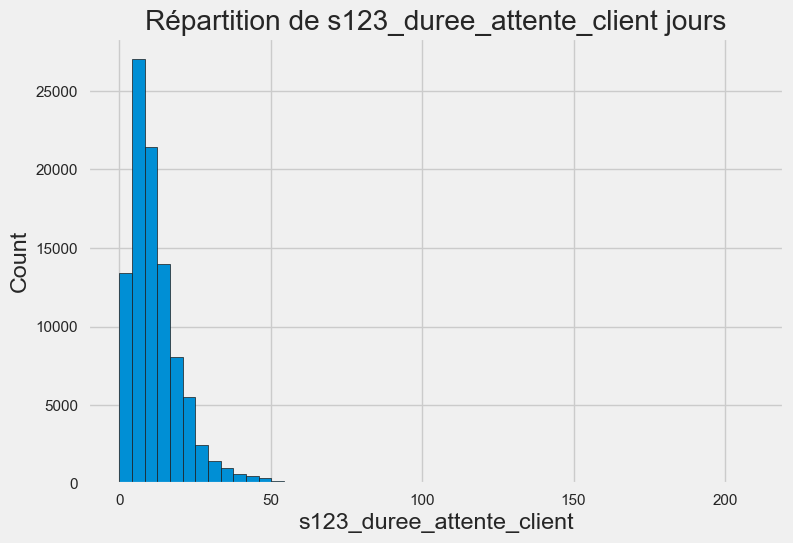

In [252]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["s123_duree_attente_client"], edgecolor="k", bins=50)
plt.title("Répartition de s123_duree_attente_client jours")
plt.xlabel("s123_duree_attente_client")
plt.ylabel("Count");

##### <a name="C72165">7.2.1.6.5 retard_livraison</a>

In [253]:
# Mesures de tendances centrales
print("moy:\n", df_orders["retard_livraison"].mean())
print("med:\n", df_orders["retard_livraison"].median())
print("mod:\n", df_orders["retard_livraison"].mode())

moy:
 -12 days +19:43:58.992090068
med:
 -12 days +01:18:36
mod:
 0   -13 days +14:44:44
Name: retard_livraison, dtype: timedelta64[ns]


In [254]:
df_orders["retard_livraison"].describe()

count                           96461
mean     -12 days +19:43:58.992090068
std        10 days 04:27:25.366427548
min               -147 days +23:36:47
25%                -17 days +18:08:53
50%                -12 days +01:18:36
75%                 -7 days +14:39:25
max                 188 days 23:24:07
Name: retard_livraison, dtype: object

In [255]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_orders["retard_livraison"].std(ddof=0)
)  # Ecart type empirique
# print("Var:\n",df_orders['1_duree_approbation'].var(ddof=0)) #Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_orders["retard_livraison"].std() / df_orders["retard_livraison"].mean(),
)

Ecart type:
 10 days 04:27:20.804751600
Coefficient de variation CV : -0.9112454936776885


In [256]:
# Conversion en jours
df_tmp = pd.to_timedelta(
    df_orders["retard_livraison"] / pd.Timedelta("86400s")
).reset_index(drop=True)
df_tmp = pd.DataFrame(df_tmp)
df_tmp.retard_livraison = df_tmp.retard_livraison.astype("int64")
data_tmp = df_tmp["retard_livraison"]
data_tmp.describe()

count    96461.000000
mean       -10.956708
std         10.020571
min       -146.000000
25%        -16.000000
50%        -11.000000
75%         -6.000000
max        188.000000
Name: retard_livraison, dtype: float64

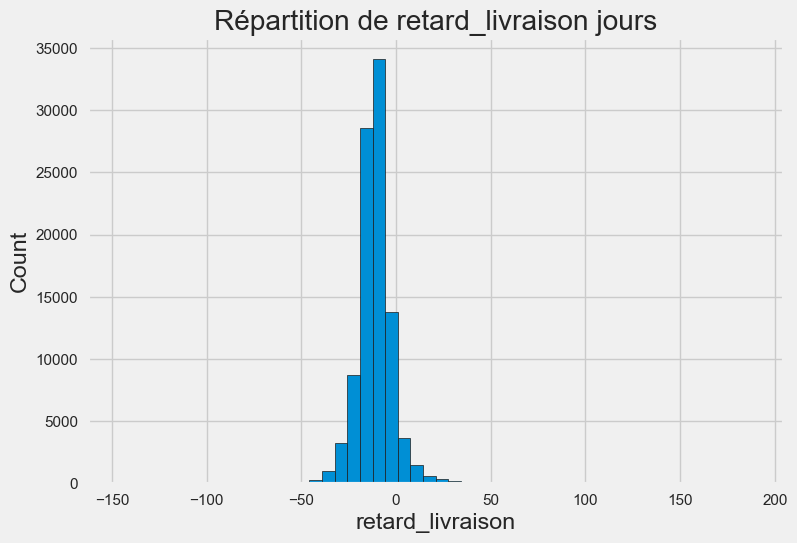

In [257]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_tmp["retard_livraison"], edgecolor="k", bins=50)
plt.title("Répartition de retard_livraison jours")
plt.xlabel("retard_livraison")
plt.ylabel("Count");

In [258]:
df_tmp = df_tmp.loc[df_tmp["retard_livraison"] > 0]

In [259]:
df_tmp["retard_livraison"].describe()

count    6534.000000
mean       10.621059
std        14.644853
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       188.000000
Name: retard_livraison, dtype: float64

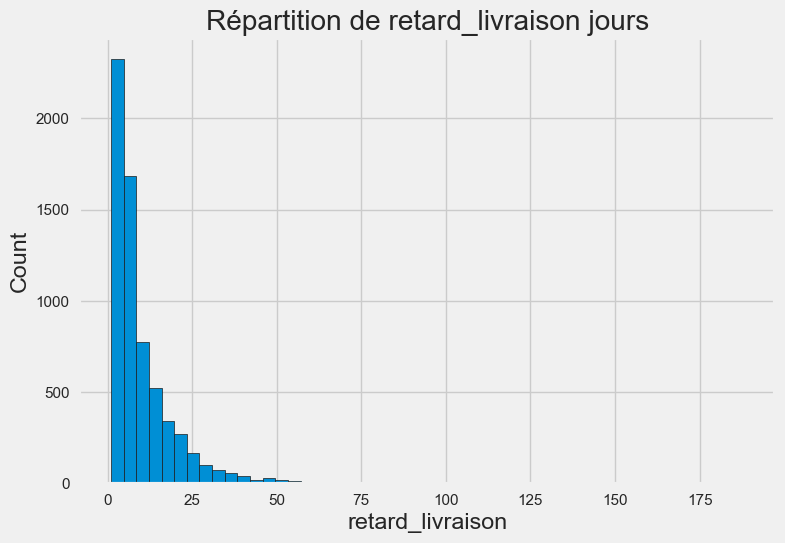

In [260]:
# Visualisation de la distribution
plt.style.use("fivethirtyeight")
plt.hist(df_tmp["retard_livraison"], edgecolor="k", bins=50)
plt.title("Répartition de retard_livraison jours")
plt.xlabel("retard_livraison")
plt.ylabel("Count");

#### <a name="C7217">7.2.1.7 df_products</a>

##### <a name="C72171">7.2.1.7.1 product_photos_qty</a>

In [261]:
# Mesures de tendances centrales
print("moy:\n", df_products["product_photos_qty"].mean())
print("med:\n", df_products["product_photos_qty"].median())
print("mod:\n", df_products["product_photos_qty"].mode())

moy:
 2.1889610389610388
med:
 1.0
mod:
 0    1.0
Name: product_photos_qty, dtype: float64


In [262]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_products["product_photos_qty"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_products["product_photos_qty"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_products["product_photos_qty"].std() / df_products["product_photos_qty"].mean(),
)

Ecart type:
 1.7367597824918952
Var:
 3.0163345420812955
Coefficient de variation CV : 0.7934296699554795


In [263]:
data_tmp = df_products["product_photos_qty"]
data_tmp.describe()

count    32340.000000
mean         2.188961
std          1.736787
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: product_photos_qty, dtype: float64

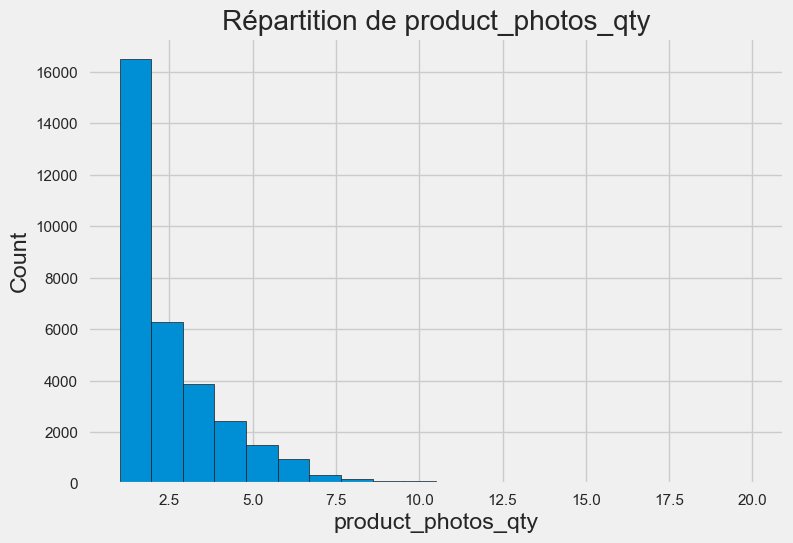

In [264]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_products["product_photos_qty"], edgecolor="k", bins=20)
plt.title("Répartition de product_photos_qty")
plt.xlabel("product_photos_qty")
plt.ylabel("Count");

In [265]:
df_products["product_photos_qty"].value_counts(normalize=True)

1.0     0.509864
2.0     0.193661
3.0     0.119326
4.0     0.075077
5.0     0.045887
6.0     0.029932
7.0     0.010606
8.0     0.005937
9.0     0.003247
10.0    0.002938
11.0    0.001422
12.0    0.001082
13.0    0.000278
15.0    0.000247
17.0    0.000216
14.0    0.000155
18.0    0.000062
20.0    0.000031
19.0    0.000031
Name: product_photos_qty, dtype: float64

##### <a name="C72172">7.2.1.7.2 product_weight_g </a>

In [266]:
# Mesures de tendances centrales
print("moy:\n", df_products["product_weight_g"].mean())
print("med:\n", df_products["product_weight_g"].median())
print("mod:\n", df_products["product_weight_g"].mode())

moy:
 2276.956586270872
med:
 700.0
mod:
 0    200.0
Name: product_weight_g, dtype: float64


In [267]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_products["product_weight_g"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_products["product_weight_g"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_products["product_weight_g"].std() / df_products["product_weight_g"].mean(),
)

Ecart type:
 4279.225683404267
Var:
 18311772.449506715
Coefficient de variation CV : 1.879391056769744


In [268]:
data_tmp = df_products["product_weight_g"]
data_tmp.describe()

count    32340.000000
mean      2276.956586
std       4279.291845
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64

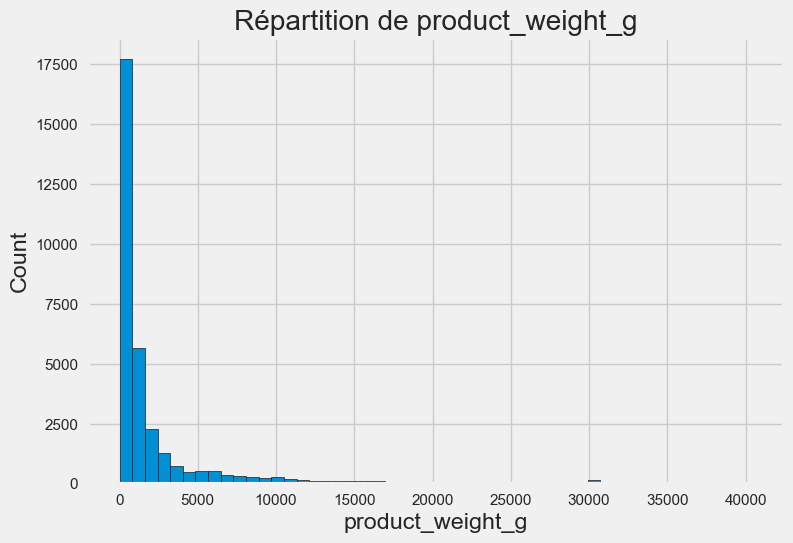

In [269]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_products["product_weight_g"], edgecolor="k", bins=50)
plt.title("Répartition de product_weight_g")
plt.xlabel("product_weight_g")
plt.ylabel("Count");

##### <a name="C72173">7.2.1.7.3 product_length_cm </a>

In [270]:
# Mesures de tendances centrales
print("moy:\n", df_products["product_length_cm"].mean())
print("med:\n", df_products["product_length_cm"].median())
print("mod:\n", df_products["product_length_cm"].mode())

moy:
 30.854545454545455
med:
 25.0
mod:
 0    16.0
Name: product_length_cm, dtype: float64


In [271]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_products["product_length_cm"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_products["product_length_cm"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_products["product_length_cm"].std() / df_products["product_length_cm"].mean(),
)

Ecart type:
 16.955702573999336
Var:
 287.4958497779277
Coefficient de variation CV : 0.5495451149197275


In [272]:
data_tmp = df_products["product_length_cm"]
data_tmp.describe()

count    32340.000000
mean        30.854545
std         16.955965
min          7.000000
25%         18.000000
50%         25.000000
75%         38.000000
max        105.000000
Name: product_length_cm, dtype: float64

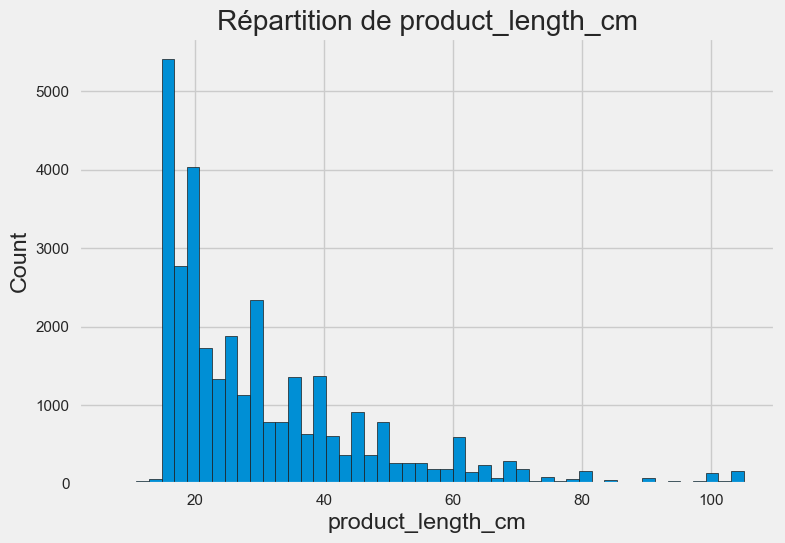

In [273]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_products["product_length_cm"], edgecolor="k", bins=50)
plt.title("Répartition de product_length_cm")
plt.xlabel("product_length_cm")
plt.ylabel("Count");

##### <a name="C72174">7.2.1.7.4 product_height_cm  </a>

In [274]:
# Mesures de tendances centrales
print("moy:\n", df_products["product_height_cm"].mean())
print("med:\n", df_products["product_height_cm"].median())
print("mod:\n", df_products["product_height_cm"].mode())

moy:
 16.958812615955473
med:
 13.0
mod:
 0    10.0
Name: product_height_cm, dtype: float64


In [275]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_products["product_height_cm"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_products["product_height_cm"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_products["product_height_cm"].std() / df_products["product_height_cm"].mean(),
)

Ecart type:
 13.635904189585174
Var:
 185.9378830675465
Coefficient de variation CV : 0.8040725093379849


In [276]:
data_tmp = df_products["product_height_cm"]
data_tmp.describe()

count    32340.000000
mean        16.958813
std         13.636115
min          2.000000
25%          8.000000
50%         13.000000
75%         21.000000
max        105.000000
Name: product_height_cm, dtype: float64

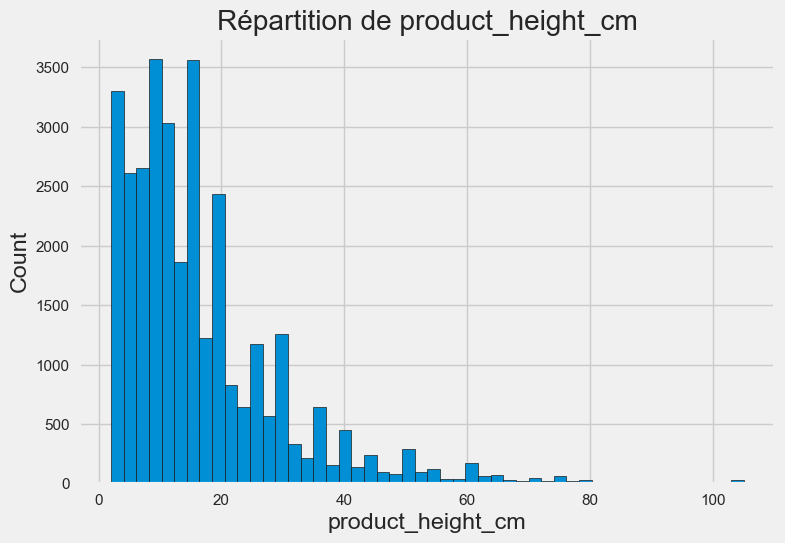

In [277]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_products["product_height_cm"], edgecolor="k", bins=50)
plt.title("Répartition de product_height_cm")
plt.xlabel("product_height_cm")
plt.ylabel("Count");

##### <a name="C72175">7.2.1.7.5 product_width_cm  </a>

In [278]:
# Mesures de tendances centrales
print("moy:\n", df_products["product_width_cm"].mean())
print("med:\n", df_products["product_width_cm"].median())
print("mod:\n", df_products["product_width_cm"].mode())

moy:
 23.208596165739024
med:
 20.0
mod:
 0    11.0
Name: product_width_cm, dtype: float64


In [279]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_products["product_width_cm"].std(ddof=0)
)  # Ecart type empirique
print("Var:\n", df_products["product_width_cm"].var(ddof=0))  # Variance empirique
print(
    "Coefficient de variation CV :",
    df_products["product_width_cm"].std() / df_products["product_width_cm"].mean(),
)

Ecart type:
 12.078575473752558
Var:
 145.89198547513683
Coefficient de variation CV : 0.5204434656631873


In [280]:
data_tmp = df_products["product_width_cm"]
data_tmp.describe()

count    32340.000000
mean        23.208596
std         12.078762
min          6.000000
25%         15.000000
50%         20.000000
75%         30.000000
max        118.000000
Name: product_width_cm, dtype: float64

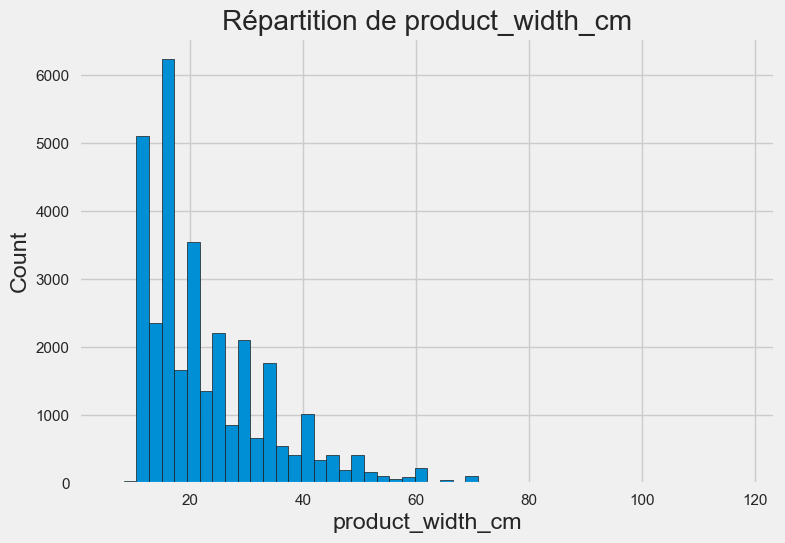

In [281]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_products["product_width_cm"], edgecolor="k", bins=50)
plt.title("Répartition de product_width_cm")
plt.xlabel("product_width_cm")
plt.ylabel("Count");

#### <a name="C7218">7.2.1.8 df_sellers</a>

Pas de variables numériques

#### <a name="C7219">7.2.1.9 df_product_category_name_translation </a>

Pas de variables numériques

#### <a name="C72110">7.2.1.10 distance entre vendeurs et clients </a>

In [282]:
# Mesures de tendances centrales
print(
    "moy:\n",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].mean(),
)
print(
    "med:\n",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].median(),
)
print(
    "mod:\n",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].mode(),
)

moy:
 601.6847058575108
med:
 433.96500000000003
mod:
 0    0.0
Name: distance_customer_seller_km, dtype: float64


In [283]:
# Mesures de dispersion :
print(
    "Ecart type:\n",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].std(ddof=0),
)  # Ecart type empirique
print(
    "Var:\n",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].var(ddof=0),
)  # Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].std()
    / df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ].mean(),
)

Ecart type:
 596.8482740587067
Var:
 356227.862246857
Coefficient de variation CV : 0.9919670867464552


In [284]:
df_customers_orders_reviews_items_geolocation_sellers[
    "distance_customer_seller_km"
].describe()

count    94716.000000
mean       601.684706
std        596.851425
min          0.000000
25%        184.307500
50%        433.965000
75%        799.495000
max       8736.950000
Name: distance_customer_seller_km, dtype: float64

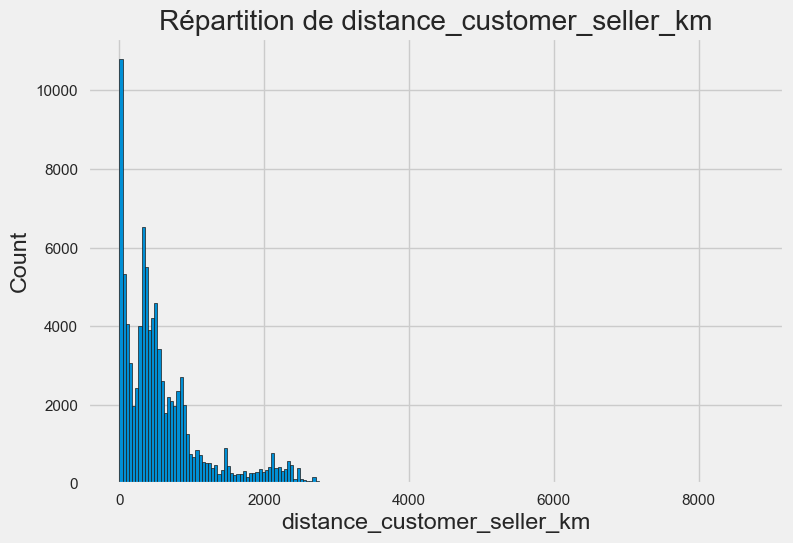

In [285]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(
    df_customers_orders_reviews_items_geolocation_sellers[
        "distance_customer_seller_km"
    ],
    edgecolor="k",
    bins=200,
)
plt.title("Répartition de distance_customer_seller_km")
plt.xlabel("distance_customer_seller_km")
plt.ylabel("Count");

#### <a name="C72111">7.2.1.11 Récence </a>

In [286]:
# Mesures de tendances centrales
print("moy:\n", df_recency["Recency"].mean())
print("med:\n", df_recency["Recency"].median())
print("mod:\n", df_recency["Recency"].mode())

moy:
 236.92763171991172
med:
 218.0
mod:
 0    277.0
Name: Recency, dtype: float64


In [287]:
# Mesures de dispersion :
print("Ecart type:\n", df_recency["Recency"].std(ddof=0))  # Ecart type empirique
print(
    "Var:\n", df_recency["Recency"].var(ddof=0)
)  # Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_recency["Recency"].std() / df_recency["Recency"].mean(),
)

Ecart type:
 152.58339238025147
Var:
 23281.69163026578
Coefficient de variation CV : 0.644011880819094


In [288]:
df_recency["Recency"].describe()

count    93342.000000
mean       236.927632
std        152.584210
min          0.000000
25%        113.000000
50%        218.000000
75%        345.000000
max        713.000000
Name: Recency, dtype: float64

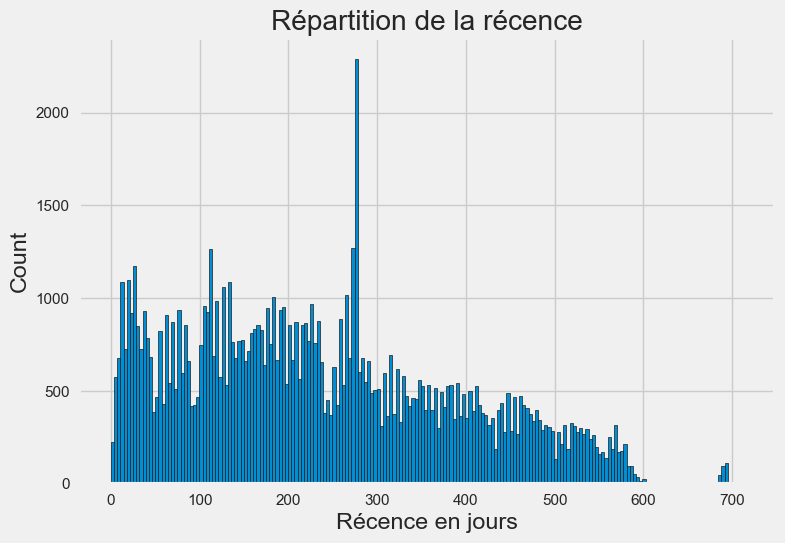

In [289]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_recency["Recency"], edgecolor="k", bins=200)
plt.title("Répartition de la récence")
plt.xlabel("Récence en jours")
plt.ylabel("Count");

#### <a name="C72112">7.2.1.12 Fréquence </a>

In [290]:
# Mesures de tendances centrales
print("moy:\n", df_frequency["Frequency"].mean())
print("med:\n", df_frequency["Frequency"].median())
print("mod:\n", df_frequency["Frequency"].mode())

moy:
 1.003798285048285
med:
 1.0
mod:
 0    1
Name: Frequency, dtype: int64


In [291]:
# Mesures de dispersion :
print("Ecart type:\n", df_frequency["Frequency"].std(ddof=0))  # Ecart type empirique
print(
    "Var:\n", df_frequency["Frequency"].var(ddof=0)
)  # Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_frequency["Frequency"].std() / df_frequency["Frequency"].mean(),
)

Ecart type:
 0.26869055433664374
Var:
 0.0721946139897329
Coefficient de variation CV : 0.2676752454967274


In [292]:
df_frequency["Frequency"].describe()

count    96096.000000
mean         1.003798
std          0.268692
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frequency, dtype: float64

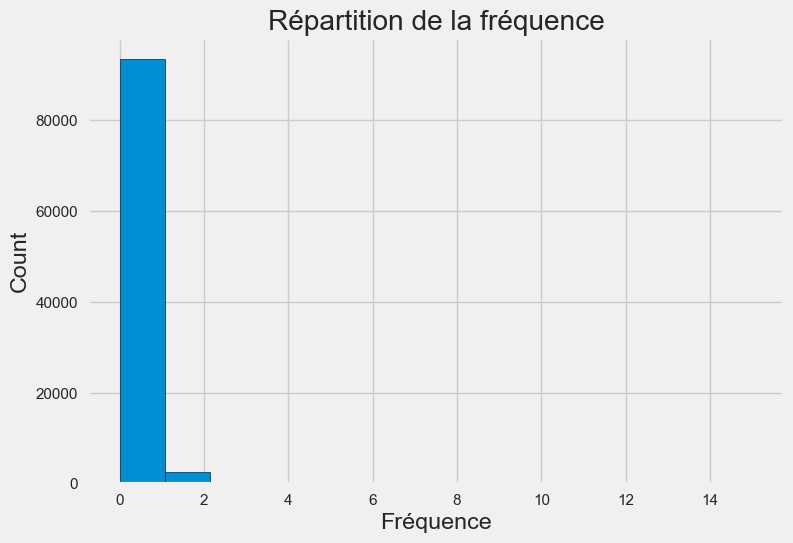

In [293]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_frequency["Frequency"], edgecolor="k", bins=14)
plt.title("Répartition de la fréquence")
plt.xlabel("Fréquence")
plt.ylabel("Count");

In [294]:
df_tmp = df_frequency["Frequency"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["Frequency", "nb_customers"]
df_tmp_sort = df_tmp.sort_values(by="Frequency", ascending=True)
df_tmp_sort["%"] = (df_tmp_sort["nb_customers"] / df_frequency.shape[0]) * 100
df_tmp_sort["%"] = round(df_tmp_sort["%"], 1)
df_tmp_sort.head(20)

,Frequency,nb_customers,%
1,0,2754,2.9
0,1,90542,94.2
2,2,2572,2.7
3,3,181,0.2
4,4,28,0.0
5,5,9,0.0
6,6,5,0.0
7,7,3,0.0
9,9,1,0.0
8,15,1,0.0


[Text(0, 0, '2754'),
 Text(0, 0, '90542'),
 Text(0, 0, '2572'),
 Text(0, 0, '181'),
 Text(0, 0, '28'),
 Text(0, 0, '9'),
 Text(0, 0, '5'),
 Text(0, 0, '3'),
 Text(0, 0, '1'),
 Text(0, 0, '1')]

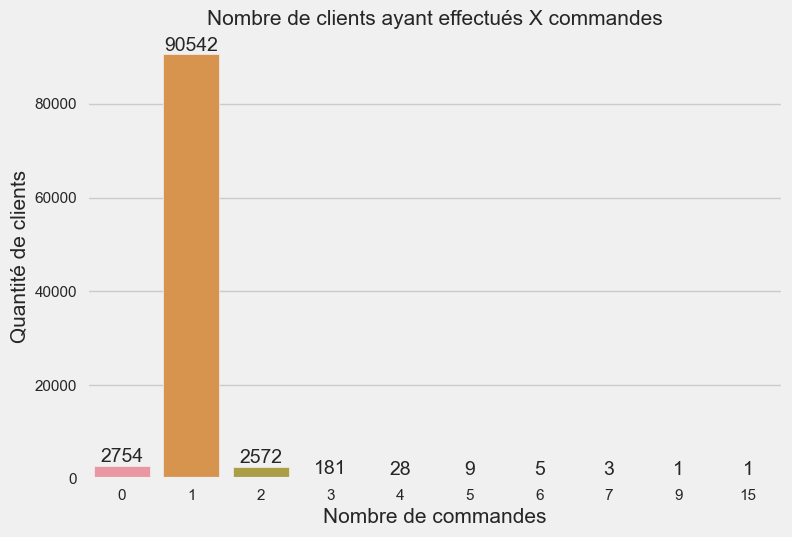

In [295]:
ax = sns.barplot(data=df_tmp_sort, x="Frequency", y="nb_customers")
plt.title("Nombre de clients ayant effectués X commandes", fontsize=15)
plt.ylabel(
    "Quantité de clients", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '2.9'),
 Text(0, 0, '94.2'),
 Text(0, 0, '2.7'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

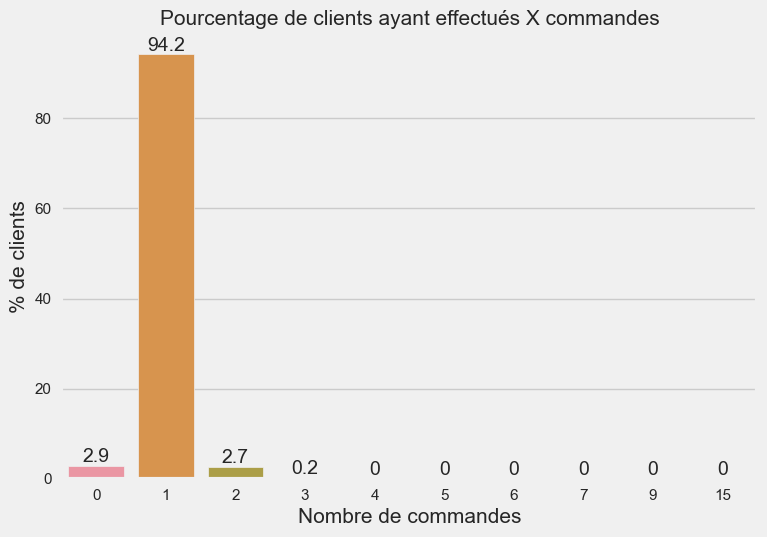

In [296]:
ax = sns.barplot(data=df_tmp_sort, x="Frequency", y="%")
plt.title("Pourcentage de clients ayant effectués X commandes", fontsize=15)
plt.ylabel("% de clients", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

#### <a name="C72113">7.2.1.13 Monétaire </a>

##### <a name="C721131">7.2.1.13.1 Monetary </a>

In [297]:
# Mesures de tendances centrales
print("moy:\n", df_monetary["Monetary"].mean())
print("med:\n", df_monetary["Monetary"].median())
print("mod:\n", df_monetary["Monetary"].mode())

moy:
 160.43326288295037
med:
 104.865
mod:
 0    0.0
Name: Monetary, dtype: float64


In [298]:
# Mesures de dispersion :
print("Ecart type:\n", df_monetary["Monetary"].std(ddof=0))  # Ecart type empirique
print(
    "Var:\n", df_monetary["Monetary"].var(ddof=0)
)  # Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_monetary["Monetary"].std() / df_monetary["Monetary"].mean(),
)

Ecart type:
 224.7354868132626
Var:
 50506.03903319414
Coefficient de variation CV : 1.4008108550055014


In [299]:
df_monetary["Monetary"].describe()

count    96096.000000
mean       160.433263
std        224.736656
min          0.000000
25%         59.397500
50%        104.865000
75%        178.462500
max      13664.080000
Name: Monetary, dtype: float64

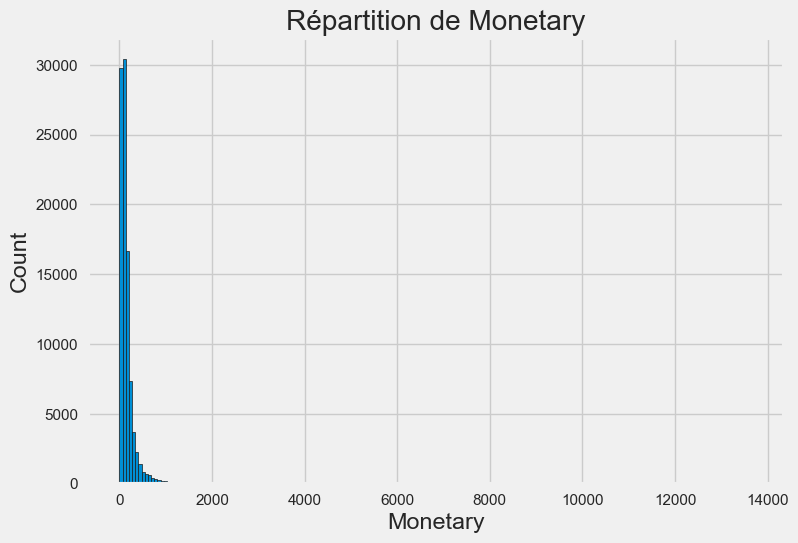

In [300]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_monetary["Monetary"], edgecolor="k", bins=200)
plt.title("Répartition de Monetary")
plt.xlabel("Monetary")
plt.ylabel("Count");

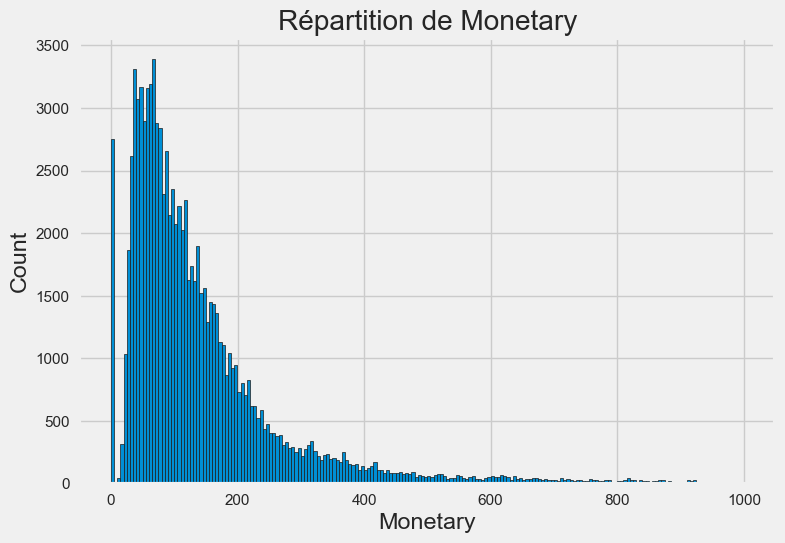

In [301]:
# Zoom sur les valeurs x<1000
plt.style.use("fivethirtyeight")
df_tmp = df_monetary.loc[df_monetary["Monetary"] < 1000]
# Visualisation de la distribution
plt.hist(df_tmp["Monetary"], edgecolor="k", bins=200)
plt.title("Répartition de Monetary")
plt.xlabel("Monetary")
plt.ylabel("Count");

##### <a name="C721132">7.2.1.13.2 Monetary_mean </a>

In [302]:
# Mesures de tendances centrales
print("moy:\n", df_panier_moyen["Monetary_mean"].mean())
print("med:\n", df_panier_moyen["Monetary_mean"].median())
print("mod:\n", df_panier_moyen["Monetary_mean"].mode())

moy:
 160.2867729509301
med:
 105.62
mod:
 0    77.57
Name: Monetary_mean, dtype: float64


In [303]:
# Mesures de dispersion :
print(
    "Ecart type:\n", df_panier_moyen["Monetary_mean"].std(ddof=0)
)  # Ecart type empirique
print(
    "Var:\n", df_panier_moyen["Monetary_mean"].var(ddof=0)
)  # Variance empirique --> var non supporter par datetime type
print(
    "Coefficient de variation CV :",
    df_panier_moyen["Monetary_mean"].std() / df_panier_moyen["Monetary_mean"].mean(),
)

Ecart type:
 219.56814876634763
Var:
 48210.17195268096
Coefficient de variation CV : 1.3698530507675926


In [304]:
df_panier_moyen["Monetary_mean"].describe()

count    93342.000000
mean       160.286773
std        219.569325
min          9.590000
25%         62.330000
50%        105.620000
75%        176.560000
max      13664.080000
Name: Monetary_mean, dtype: float64

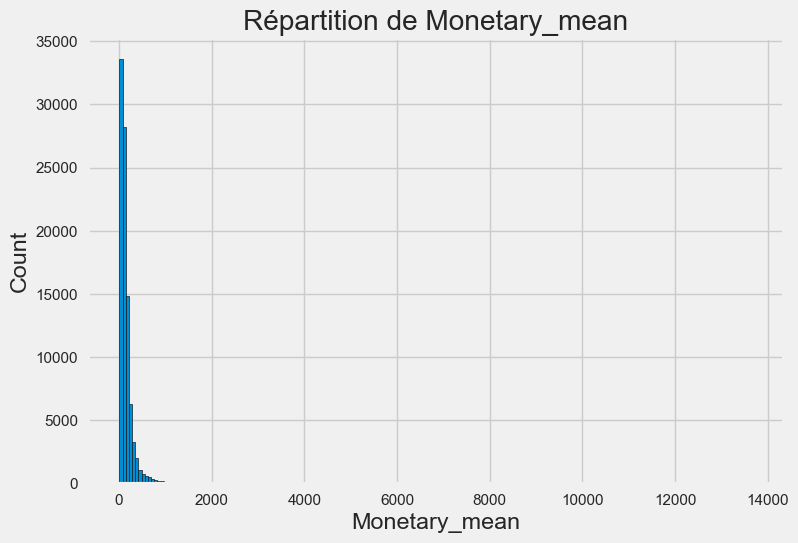

In [305]:
plt.style.use("fivethirtyeight")

# Visualisation de la distribution
plt.hist(df_panier_moyen["Monetary_mean"], edgecolor="k", bins=200)
plt.title("Répartition de Monetary_mean")
plt.xlabel("Monetary_mean")
plt.ylabel("Count");

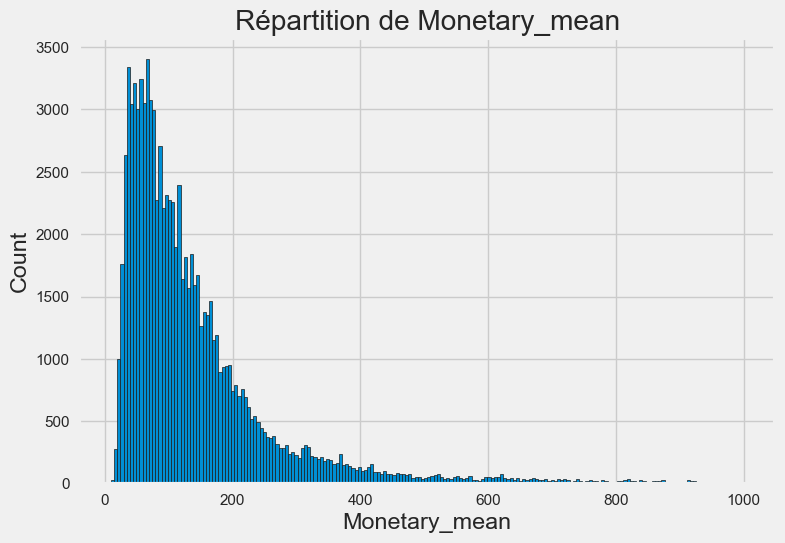

In [306]:
# Zoom sur les valeurs x<1000
plt.style.use("fivethirtyeight")
df_tmp = df_panier_moyen.loc[df_panier_moyen["Monetary_mean"] < 1000]
# Visualisation de la distribution
plt.hist(df_tmp["Monetary_mean"], edgecolor="k", bins=200)
plt.title("Répartition de Monetary_mean")
plt.xlabel("Monetary_mean")
plt.ylabel("Count");

#### <a name="C72114">7.2.1.14 Autres variables numériques</a>

In [307]:
# Prise en compte de df final

df_final_num = df_final.select_dtypes(include=["int64", "float64"])
liste = df_final_num.columns
print(liste)

Index(['s1_duree_approbation', 's2_attente_prise_transport',
       's3_duree_transport', 's123_duree_attente_client', 'retard_livraison',
       'review_score', 'total_price', 'distance_customer_seller_km', 'Recency',
       'Frequency', 'Monetary', 'Monetary_mean', 'RFM_Score'],
      dtype='object')


s1_duree_approbation
moy:
 36999.83789303449
med:
 1236.0
mod:
 0    0.0
Name: s1_duree_approbation, dtype: float64
Ecart type:
 73927.76086053968
Var:
 5465313825.853143
Coefficient de variation CV : 1.9980667017381246
count    9.646100e+04
mean     3.699984e+04
std      7.392814e+04
min      0.000000e+00
25%      7.750000e+02
50%      1.236000e+03
75%      5.226500e+04
max      2.669197e+06
Name: s1_duree_approbation, dtype: float64


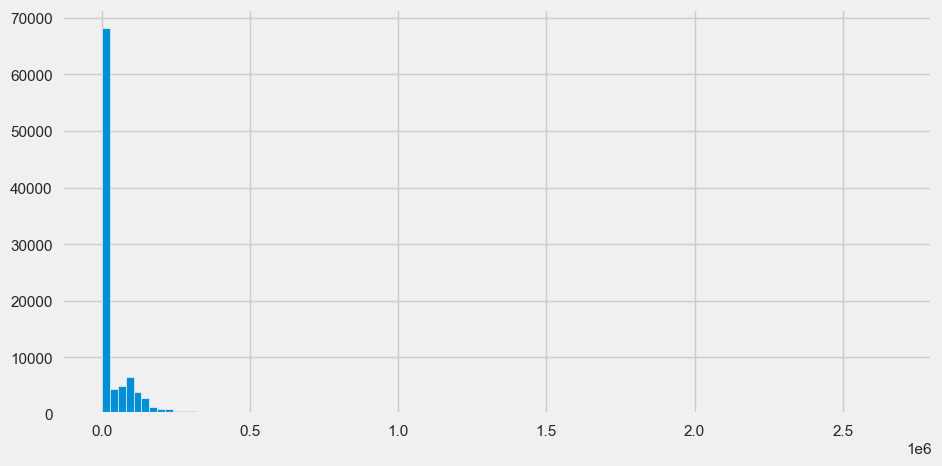

---------------------------------------
s2_attente_prise_transport
moy:
 241858.0286851681
med:
 156890.0
mod:
 0    345601.0
Name: s2_attente_prise_transport, dtype: float64
Ecart type:
 305644.76405459165
Var:
 93418721793.987
Coefficient de variation CV : 1.263742824749008
count    9.646100e+04
mean     2.418580e+05
std      3.056463e+05
min     -1.479332e+07
25%      7.554500e+04
50%      1.568900e+05
75%      3.088980e+05
max      1.086589e+07
Name: s2_attente_prise_transport, dtype: float64


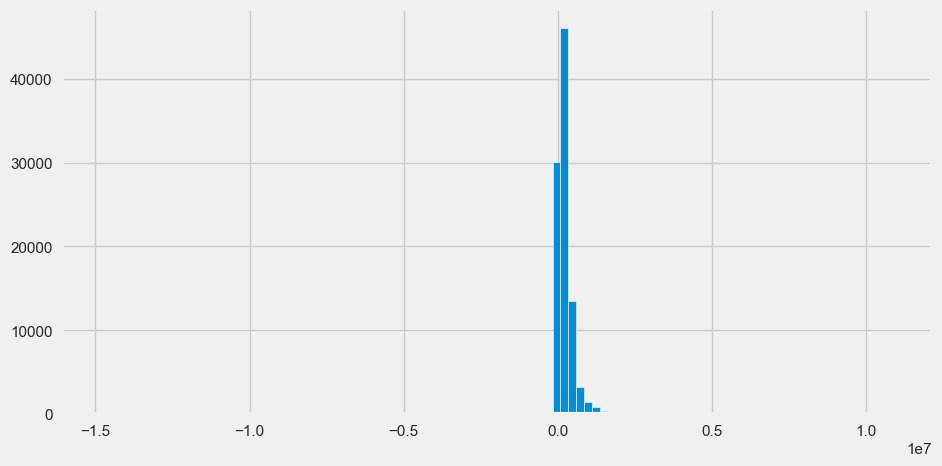

---------------------------------------
s3_duree_transport
moy:
 806168.7192751474
med:
 613414.0
mod:
 0    259200.0
Name: s3_duree_transport, dtype: float64
Ecart type:
 756920.7028771545
Var:
 572928950444.0455
Coefficient de variation CV : 0.9389158972116997
count    9.646100e+04
mean     8.061687e+05
std      7.569246e+05
min     -1.390709e+06
25%      3.542060e+05
50%      6.134140e+05
75%      1.039334e+06
max      1.772850e+07
Name: s3_duree_transport, dtype: float64


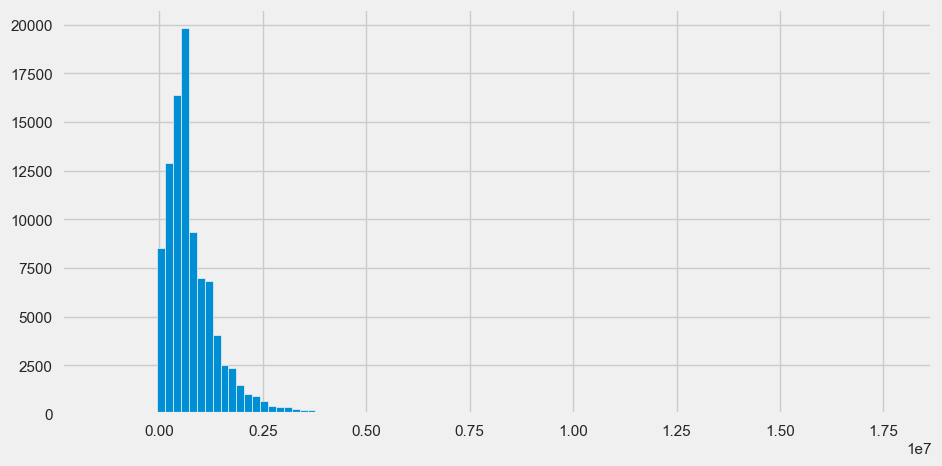

---------------------------------------
s123_duree_attente_client
moy:
 1085026.58585335
med:
 882689.0
mod:
 0      178767.0
1      202639.0
2      249075.0
3      273941.0
4      356039.0
5      451112.0
6      454351.0
7      461847.0
8      503864.0
9      508179.0
10     518365.0
11     524617.0
12     524791.0
13     535499.0
14     544338.0
15     546325.0
16     597245.0
17     598572.0
18     607869.0
19     609221.0
20     612551.0
21     615540.0
22     616954.0
23     678047.0
24     681587.0
25     691230.0
26     693834.0
27     709859.0
28     712893.0
29     760910.0
30     771756.0
31     777785.0
32     779475.0
33     846788.0
34     855434.0
35     869830.0
36     870742.0
37     937674.0
38     940770.0
39     945127.0
40     960473.0
41     964748.0
42     972734.0
43     987852.0
44    1010560.0
45    1015940.0
46    1029399.0
47    1039877.0
48    1066420.0
49    1135791.0
50    1146972.0
51    1212734.0
52    1305157.0
53    1503383.0
54    1844249.0
55    2342

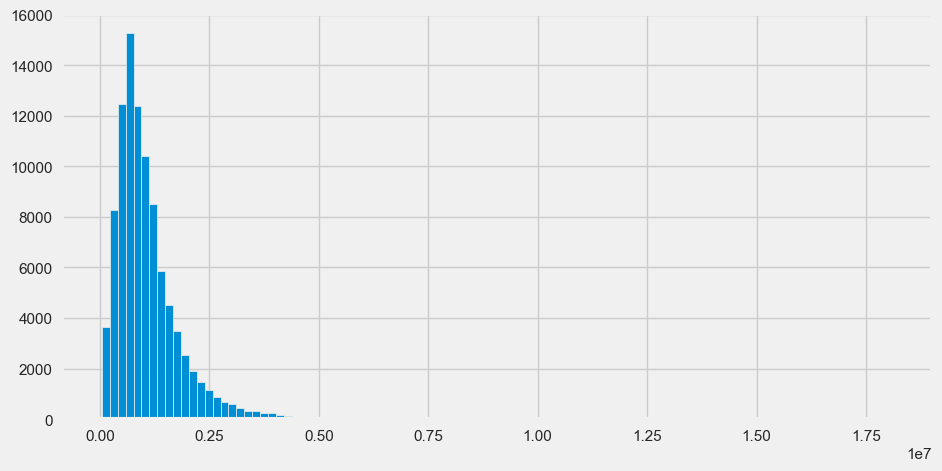

---------------------------------------
retard_livraison
moy:
 -965761.0079099325
med:
 -1032084.0
mod:
 0   -1070116.0
Name: retard_livraison, dtype: float64
Ecart type:
 880040.8047516004
Var:
 774471818027.8445
Coefficient de variation CV : -0.9112454936776886
count    9.646100e+04
mean    -9.657610e+05
std      8.800454e+05
min     -1.261579e+07
25%     -1.403467e+06
50%     -1.032084e+06
75%     -5.520350e+05
max      1.632745e+07
Name: retard_livraison, dtype: float64


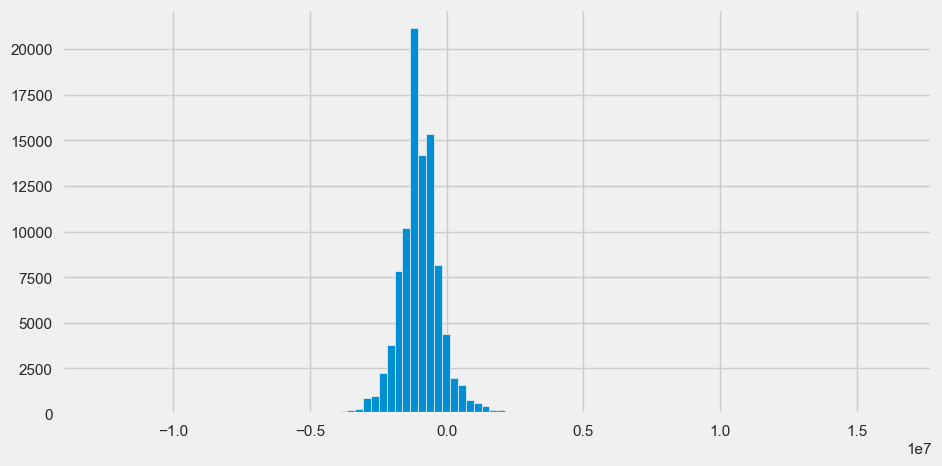

---------------------------------------
review_score
moy:
 4.155706309033032
med:
 5.0
mod:
 0    5.0
Name: review_score, dtype: float64
Ecart type:
 1.2849833262254868
Var:
 1.6511821486775158
Coefficient de variation CV : 0.30921098274642145
count    95815.000000
mean         4.155706
std          1.284990
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


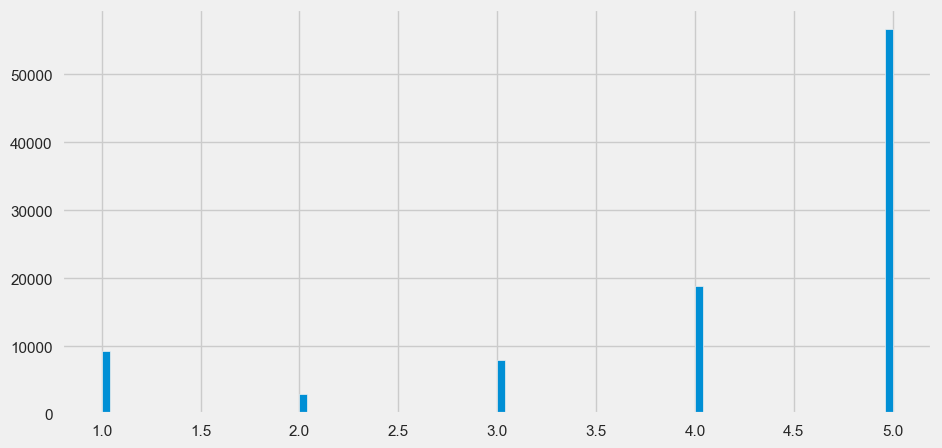

---------------------------------------
total_price
moy:
 159.82619742693942
med:
 105.28
mod:
 0    77.57
Name: total_price, dtype: float64
Ecart type:
 218.80841201005435
Var:
 47877.1211663617
Coefficient de variation CV : 1.3690468128644042
count    96461.000000
mean       159.826197
std        218.809546
min          9.590000
25%         61.850000
50%        105.280000
75%        176.260000
max      13664.080000
Name: total_price, dtype: float64


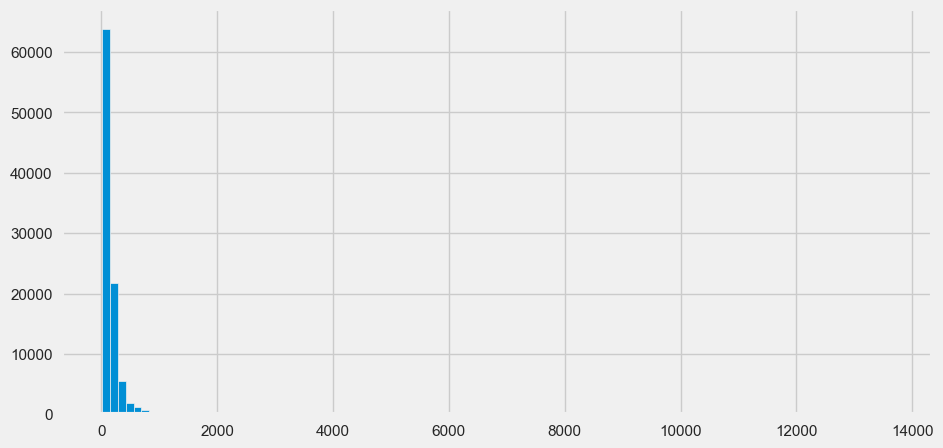

---------------------------------------
distance_customer_seller_km
moy:
 601.6847058575108
med:
 433.96500000000003
mod:
 0    0.0
Name: distance_customer_seller_km, dtype: float64
Ecart type:
 596.8482740587067
Var:
 356227.862246857
Coefficient de variation CV : 0.9919670867464552
count    94716.000000
mean       601.684706
std        596.851425
min          0.000000
25%        184.307500
50%        433.965000
75%        799.495000
max       8736.950000
Name: distance_customer_seller_km, dtype: float64


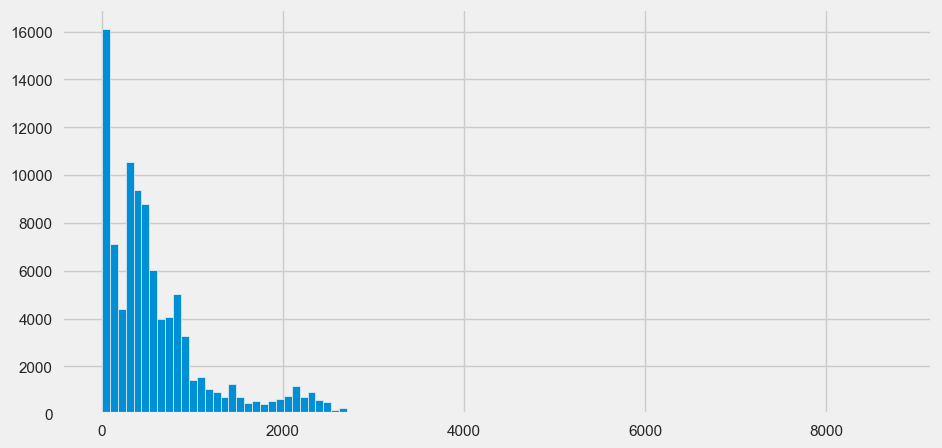

---------------------------------------
Recency
moy:
 236.24858534970568
med:
 217.0
mod:
 0    277.0
Name: Recency, dtype: float64
Ecart type:
 152.41345464660833
Var:
 23229.861157313735
Coefficient de variation CV : 0.6451435159700579
count    96667.000000
mean       236.248585
std        152.414243
min          0.000000
25%        113.000000
50%        217.000000
75%        344.000000
max        713.000000
Name: Recency, dtype: float64


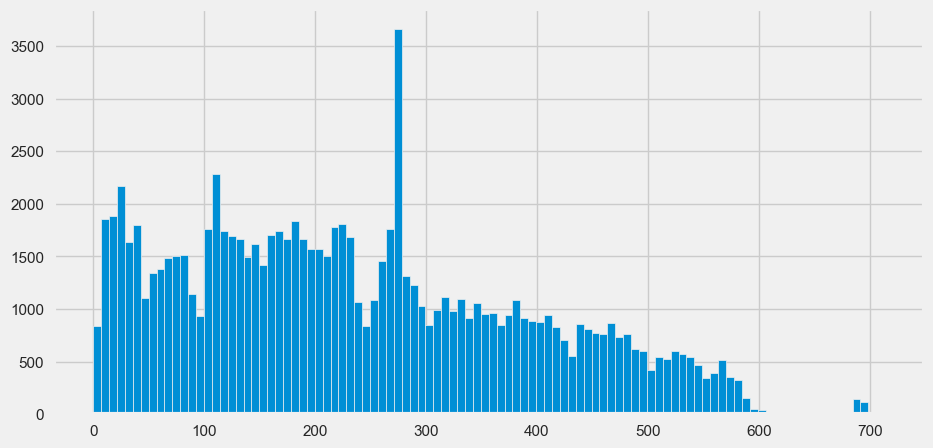

---------------------------------------
Frequency
moy:
 1.0761066341150547
med:
 1.0
mod:
 0    1.0
Name: Frequency, dtype: float64
Ecart type:
 0.3797326931041979
Var:
 0.14419691821216693
Coefficient de variation CV : 0.35287827916753023
count    96667.000000
mean         1.076107
std          0.379735
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frequency, dtype: float64


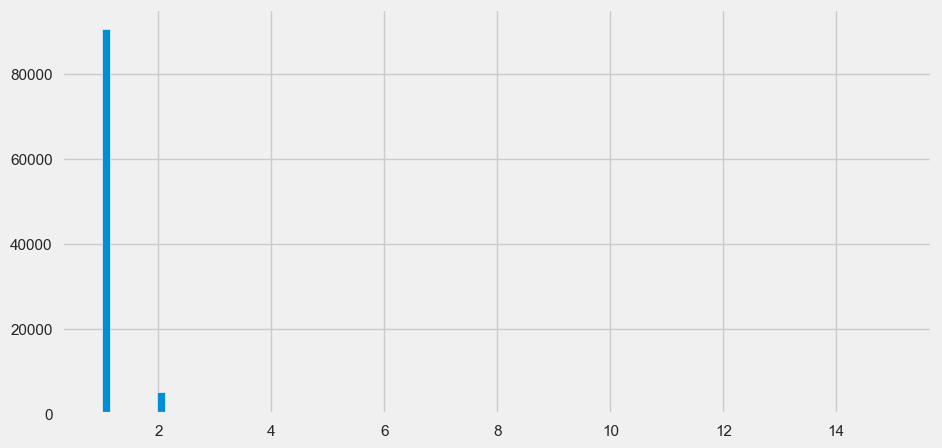

---------------------------------------
Monetary
moy:
 170.88448912245127
med:
 111.02
mod:
 0    77.57
Name: Monetary, dtype: float64
Ecart type:
 233.89399387274577
Var:
 54706.400369744035
Coefficient de variation CV : 1.3687327906447813
count    96667.000000
mean       170.884489
std        233.895204
min          9.590000
25%         64.030000
50%        111.020000
75%        188.790000
max      13664.080000
Name: Monetary, dtype: float64


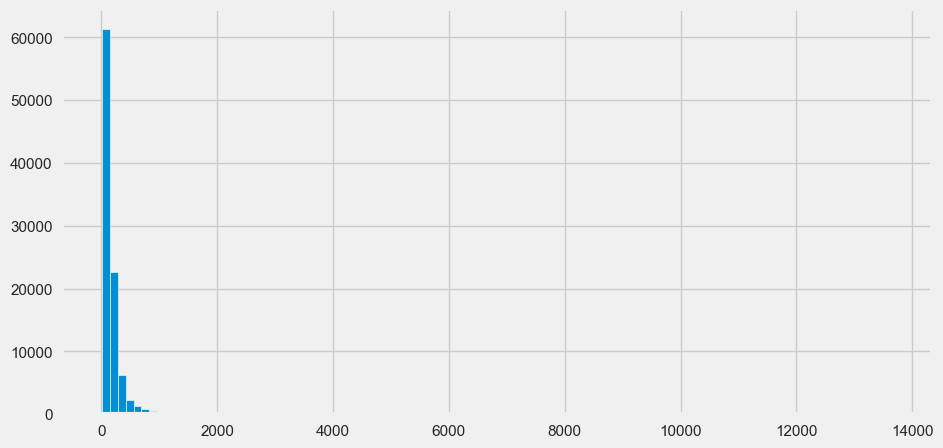

---------------------------------------
Monetary_mean
moy:
 159.9305780669722
med:
 105.78
mod:
 0    77.57
Name: Monetary_mean, dtype: float64
Ecart type:
 218.03575326755072
Var:
 47539.58970294825
Coefficient de variation CV : 1.3633220343407046
count    96667.000000
mean       159.930578
std        218.036881
min          9.590000
25%         62.650000
50%        105.780000
75%        176.340000
max      13664.080000
Name: Monetary_mean, dtype: float64


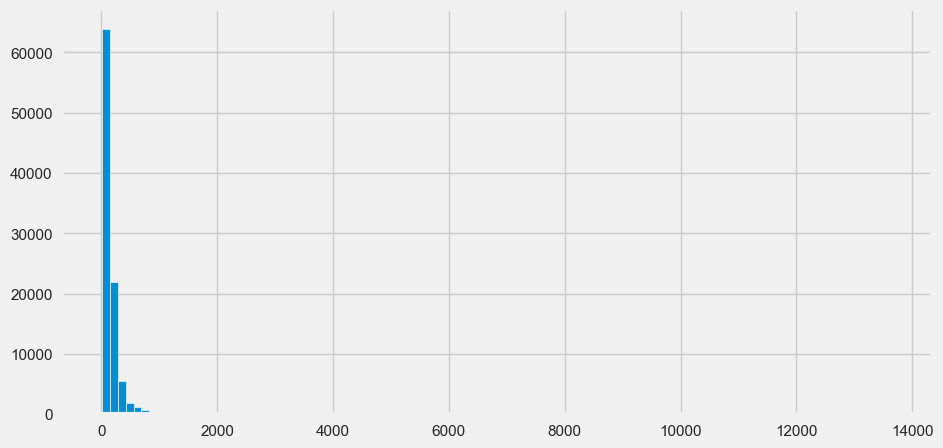

---------------------------------------
RFM_Score
moy:
 2.5489703828607495
med:
 2.54
mod:
 0    1.74
Name: RFM_Score, dtype: float64
Ecart type:
 0.9136869546961672
Var:
 0.834823851181956
Coefficient de variation CV : 0.3584551969796112
count    96667.000000
mean         2.548970
std          0.913692
min          0.680000
25%          1.780000
50%          2.540000
75%          3.280000
max          4.970000
Name: RFM_Score, dtype: float64


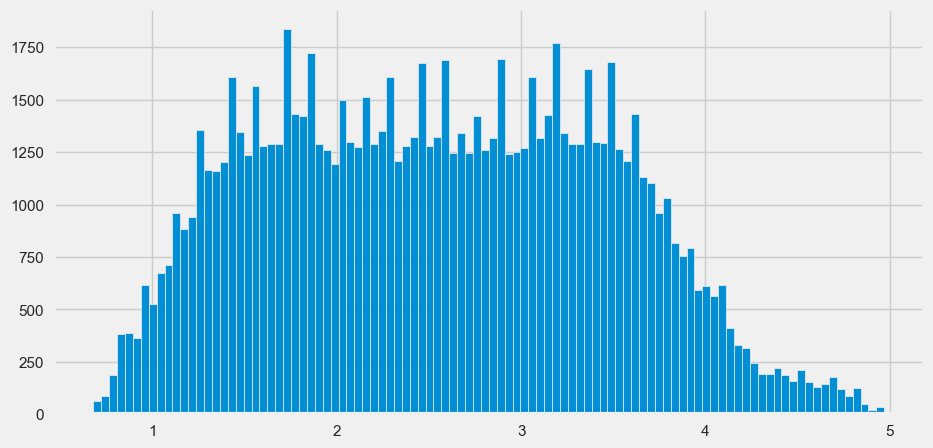

---------------------------------------


In [308]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print("moy:\n", df_final_num[liste[ele]].mean())
    print("med:\n", df_final_num[liste[ele]].median())
    print("mod:\n", df_final_num[liste[ele]].mode())
    # Mesure de dispersion :
    print("Ecart type:\n", df_final_num[liste[ele]].std(ddof=0))  # Ecart type empirique
    print("Var:\n", df_final_num[liste[ele]].var(ddof=0))  # Variance empirique
    print(
        "Coefficient de variation CV :",
        df_final_num[liste[ele]].std() / df_final_num[liste[ele]].mean(),
    )

    df_tmp = df_final_num[liste[ele]]
    print(df_tmp.describe())

    plt.figure(figsize=(10, 5))
    plt.hist(df_final_num[liste[ele]], bins=100)
    plt.show()
    print("---------------------------------------")

### <a name="C722">7.2.2 Variables catégorielles </a>

#### <a name="C7221">7.2.2.1 df_customers </a>

##### <a name="C72211">7.2.2.1.1 customer_unique_id </a>

In [309]:
df_customers["customer_unique_id"].nunique()

96096

In [310]:
# Affichage de la proportion du nombre de "commandes"

df_tmp = df_customers["customer_unique_id"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["customer_unique_id", "nb_commandes"]
df_tmp.head()

,customer_unique_id,nb_commandes
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,ca77025e7201e3b30c44b472ff346268,7
4,6469f99c1f9dfae7733b25662e7f1782,7


In [311]:
# Affichage de la proportion du nombre de commandes

df_tmp2 = df_tmp.groupby("nb_commandes").size().reset_index()  # agrégation
df_tmp2.columns = [
    "nb_commandes par client",
    "nb_clients_diff",
]  # renommage des colonnes
df_tmp2_sort = df_tmp2.sort_values(
    "nb_clients_diff"
)  # trie de la quantité par ordre croissant
df_tmp2_sort["%"] = round((df_tmp2_sort["nb_clients_diff"] / df_tmp.shape[0]) * 100, 2)

# Pour l'affichage du tableau dans l'ordre décroissant :
df_tmp2_sort2 = df_tmp2_sort.sort_values(
    "nb_clients_diff", ascending=False
).reset_index(
    drop=True
)  # trie de la quantité par ordre croissant
df_tmp2_sort2.head(10)

,nb_commandes par client,nb_clients_diff,%
0,1,93099,96.88
1,2,2745,2.86
2,3,203,0.21
3,4,30,0.03
4,5,8,0.01
5,6,6,0.01
6,7,3,0.00
7,9,1,0.00
8,17,1,0.00


[Text(0, 0, '93099'),
 Text(0, 0, '2745'),
 Text(0, 0, '203'),
 Text(0, 0, '30'),
 Text(0, 0, '8'),
 Text(0, 0, '6'),
 Text(0, 0, '3'),
 Text(0, 0, '1'),
 Text(0, 0, '1')]

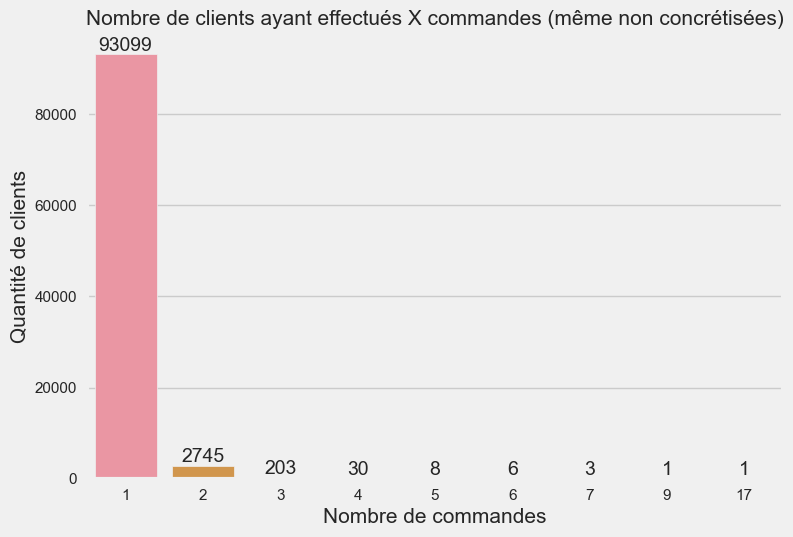

In [312]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(
    data=df_tmp2_sort2, x="nb_commandes par client", y="nb_clients_diff"
)  # Création du barplot
plt.title(
    "Nombre de clients ayant effectués X commandes (même non concrétisées)", fontsize=15
)
plt.ylabel(
    "Quantité de clients", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '96.88'),
 Text(0, 0, '2.86'),
 Text(0, 0, '0.21'),
 Text(0, 0, '0.03'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0.01'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

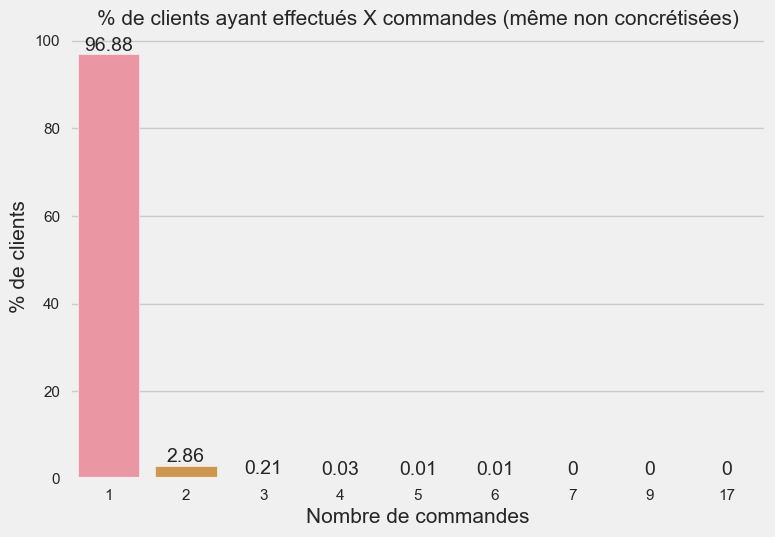

In [313]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(
    data=df_tmp2_sort2, x="nb_commandes par client", y="%"
)  # Création du barplot
plt.title(
    "% de clients ayant effectués X commandes (même non concrétisées)", fontsize=15
)
plt.ylabel("% de clients", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

##### <a name="C72212">7.2.2.1.2 customer_city </a>

In [314]:
# Affichage des villes les plus représentées au niveau des commandes
df_tmp = df_customers.groupby("customer_city").size().reset_index()  # agrégation
df_tmp.columns = ["customer_city", "nb_customer_id"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values("nb_customer_id", ascending=False).reset_index(
    drop=True
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round(
    (df_tmp_sort["nb_customer_id"] / df_customers.shape[0]) * 100, 2
)
df_tmp_sort.head(20)

,customer_city,nb_customer_id,%
0,sao paulo,15540,15.63
1,rio de janeiro,6882,6.92
2,belo horizonte,2773,2.79
3,brasilia,2131,2.14
4,curitiba,1521,1.53
5,campinas,1444,1.45
6,porto alegre,1379,1.39
7,salvador,1245,1.25
8,guarulhos,1189,1.20
9,sao bernardo do campo,938,0.94


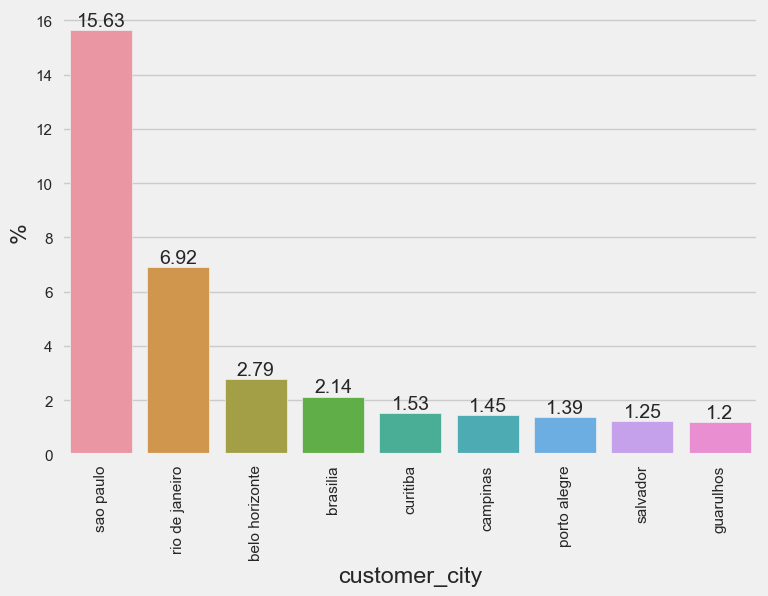

In [315]:
df_tmp_sort = df_tmp_sort.loc[df_tmp_sort["nb_customer_id"] > 1000]
plt.xticks(rotation=90)  # Rotation de 90°de l'axe des abscisses
ax = sns.barplot(data=df_tmp_sort, x="customer_city", y="%")  # Création du barplot

for i in ax.containers:
    ax.bar_label(
        i,
    )

#### <a name="C7222">7.2.2.2 df_geolocation </a>

Pas de variables catégorielles unitaires pertinentes à analyser en analyse univariée.

#### <a name="C7223">7.2.2.3 df_order_items </a>

Pas de variables catégorielles unitaires pertinentes à analyser en analyse univariée.

#### <a name="C7224">7.2.2.4 df_order_payments </a>

##### <a name="C7224">7.2.2.4.1 payment_type </a>

In [316]:
df_tmp = df_order_payments["payment_type"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["payment_type", "payments"]
df_tmp.head()
df_tmp_sort = df_tmp.sort_values(by="payments", ascending=False)
df_tmp_sort["%"] = (df_tmp["payments"] / df_tmp["payments"].sum()) * 100
df_tmp_sort["%"] = round(df_tmp_sort["%"], 1)
df_tmp_sort.head(20)

,payment_type,payments,%
0,credit_card,76795,73.9
1,boleto,19784,19.0
2,voucher,5775,5.6
3,debit_card,1529,1.5
4,not_defined,3,0.0


[Text(0, 0, '76795'),
 Text(0, 0, '19784'),
 Text(0, 0, '5775'),
 Text(0, 0, '1529'),
 Text(0, 0, '3')]

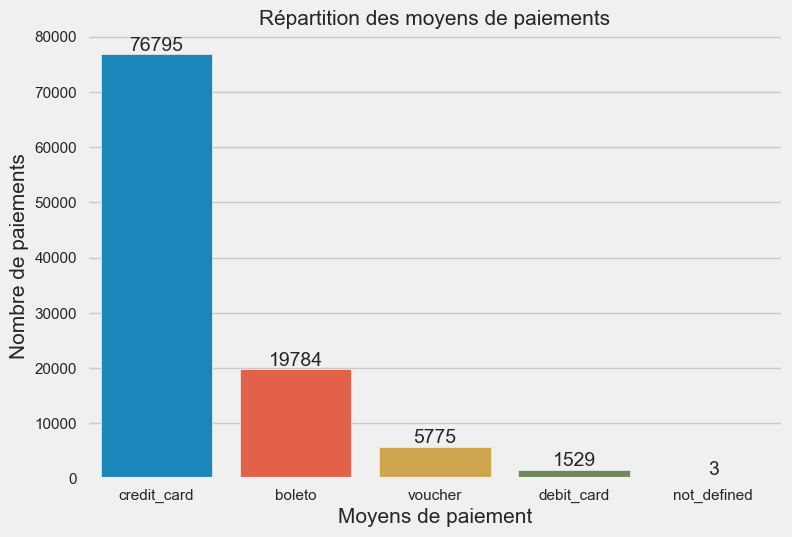

In [317]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(
    data=df_tmp_sort, x="payment_type", y="payments"
)  # Création du barplot
plt.title("Répartition des moyens de paiements", fontsize=15)
plt.ylabel(
    "Nombre de paiements", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Moyens de paiement", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '73.9'),
 Text(0, 0, '19'),
 Text(0, 0, '5.6'),
 Text(0, 0, '1.5'),
 Text(0, 0, '0')]

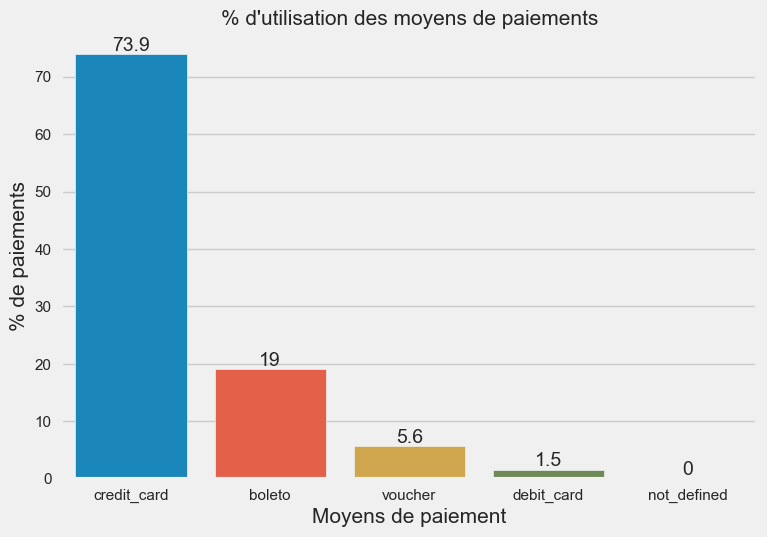

In [318]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(data=df_tmp_sort, x="payment_type", y="%")  # Création du barplot
plt.title("% d'utilisation des moyens de paiements", fontsize=15)
plt.ylabel("% de paiements", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel(
    "Moyens de paiement", fontsize=15
)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

#### <a name="C7225">7.2.2.5 df_order_reviews </a>

Pas de variables catégorielles unitaires pertinentes à analyser en solitaire

#### <a name="C7226">7.2.2.6 df_orders </a>

##### <a name="C72261">7.2.2.6.1 order_status </a>

In [319]:
df_tmp = df_orders["order_status"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["order_status", "nb_commandes"]
df_tmp.head()

,order_status,nb_commandes
0,delivered,96455
1,canceled,6


In [320]:
# Affichage de la proportion du nombre de commandes

df_tmp["%"] = round((df_tmp["nb_commandes"] / df_orders.shape[0]) * 100, 2)
df_tmp.head(10)

,order_status,nb_commandes,%
0,delivered,96455,99.99
1,canceled,6,0.01


[Text(0, 0, '96455'), Text(0, 0, '6')]

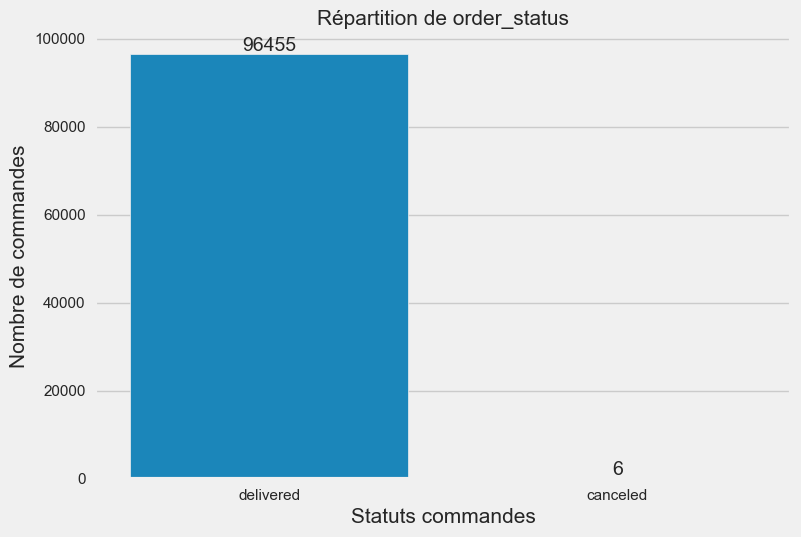

In [321]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(data=df_tmp, x="order_status", y="nb_commandes")  # Création du barplot
plt.title("Répartition de order_status", fontsize=15)
plt.ylabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Statuts commandes", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '99.99'), Text(0, 0, '0.01')]

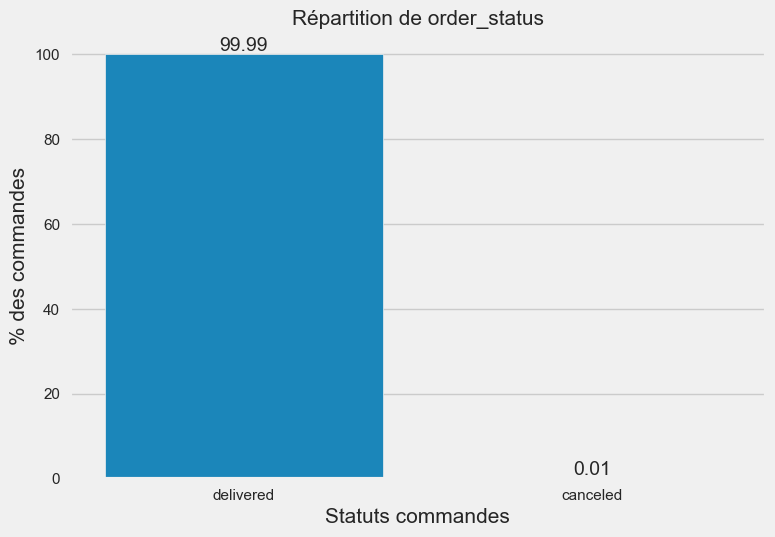

In [322]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(data=df_tmp, x="order_status", y="%")  # Création du barplot
plt.title("Répartition de order_status", fontsize=15)
plt.ylabel("% des commandes", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Statuts commandes", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

##### <a name="C72262">7.2.2.6.2 retard livraison class </a>

In [323]:
df_tmp = df_orders["retard_livraison_class"].value_counts().reset_index()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.columns = ["retard", "nb_commandes"]
df_tmp.head()

,retard,nb_commandes
0,NON,88635
1,OUI,7826


In [324]:
df_tmp["%"] = round((df_tmp["nb_commandes"] / df_orders.shape[0]) * 100, 2)
df_tmp.head(10)

,retard,nb_commandes,%
0,NON,88635,91.89
1,OUI,7826,8.11


[Text(0, 0, '88635'), Text(0, 0, '7826')]

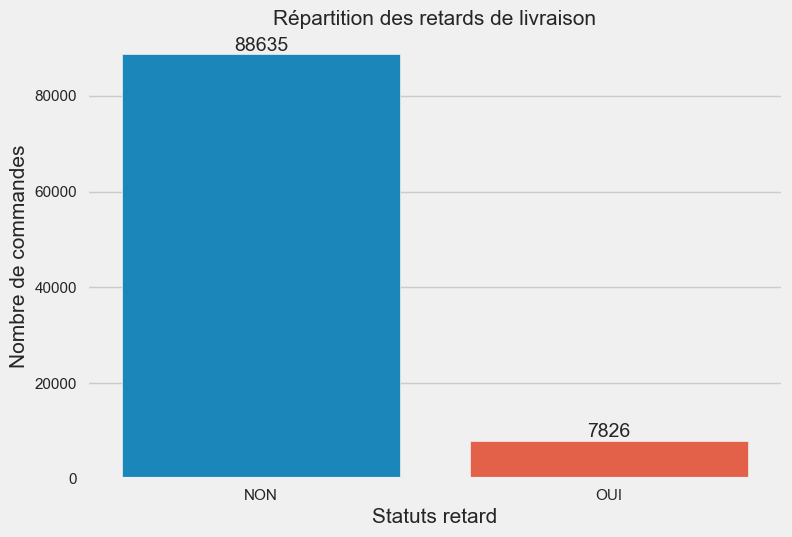

In [325]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(data=df_tmp, x="retard", y="nb_commandes")  # Création du barplot
plt.title("Répartition des retards de livraison", fontsize=15)
plt.ylabel(
    "Nombre de commandes", fontsize=15
)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Statuts retard", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

[Text(0, 0, '91.89'), Text(0, 0, '8.11')]

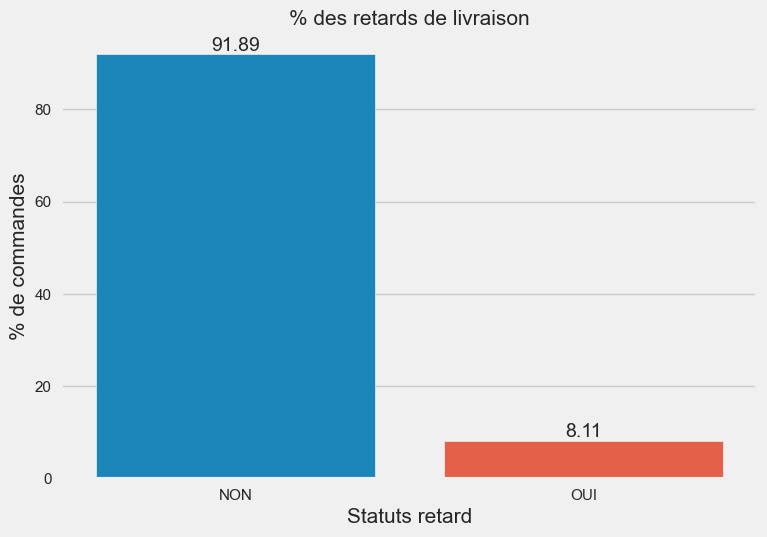

In [326]:
# plt.figure(figsize=(10,10)) #taille de la fenetre pour le barplot
ax = sns.barplot(data=df_tmp, x="retard", y="%")  # Création du barplot
plt.title("% des retards de livraison", fontsize=15)
plt.ylabel("% de commandes", fontsize=15)  # Titre de l'axe des ordonnées en taille x
plt.xlabel("Statuts retard", fontsize=15)  # Titre de l'axe des abscisses en taille x
ax.bar_label(ax.containers[0])

#### <a name="C7227">7.2.2.7 df_products </a>

In [327]:
df_products["product_category_name"].value_counts(normalize=True)

cama_mesa_banho                                   0.093661
esporte_lazer                                     0.088652
moveis_decoracao                                  0.082158
beleza_saude                                      0.075572
utilidades_domesticas                             0.072202
automotivo                                        0.058751
informatica_acessorios                            0.050680
brinquedos                                        0.043630
relogios_presentes                                0.041095
telefonia                                         0.035065
bebes                                             0.028386
perfumaria                                        0.026840
papelaria                                         0.026252
fashion_bolsas_e_acessorios                       0.026252
cool_stuff                                        0.024397
ferramentas_jardim                                0.023284
pet_shop                                          0.0222

In [328]:
df_products["product_category_name"].value_counts()

cama_mesa_banho                                   3029
esporte_lazer                                     2867
moveis_decoracao                                  2657
beleza_saude                                      2444
utilidades_domesticas                             2335
automotivo                                        1900
informatica_acessorios                            1639
brinquedos                                        1411
relogios_presentes                                1329
telefonia                                         1134
bebes                                              918
perfumaria                                         868
papelaria                                          849
fashion_bolsas_e_acessorios                        849
cool_stuff                                         789
ferramentas_jardim                                 753
pet_shop                                           719
eletronicos                                        517
construcao

#### <a name="C7228">7.2.2.8 df_sellers </a>

#### <a name="C72281">7.2.2.8.1 seller_city </a>

In [329]:
# Affichage des villes les plus représentées au niveau des commandes
df_tmp = df_sellers.groupby("seller_city").size().reset_index()  # agrégation
df_tmp.columns = ["seller_city", "nb_seller_id"]  # renommage des colonnes
df_tmp_sort = df_tmp.sort_values("nb_seller_id", ascending=False).reset_index(
    drop=True
)  # trie de la quantité par ordre croissant
df_tmp_sort["%"] = round((df_tmp_sort["nb_seller_id"] / df_sellers.shape[0]) * 100, 2)
df_tmp_sort.head(20)

,seller_city,nb_seller_id,%
0,sao paulo,694,22.42
1,curitiba,127,4.10
2,rio de janeiro,96,3.10
3,belo horizonte,68,2.20
4,ribeirao preto,52,1.68
5,guarulhos,50,1.62
6,ibitinga,49,1.58
7,santo andre,45,1.45
8,campinas,41,1.32
9,maringa,40,1.29


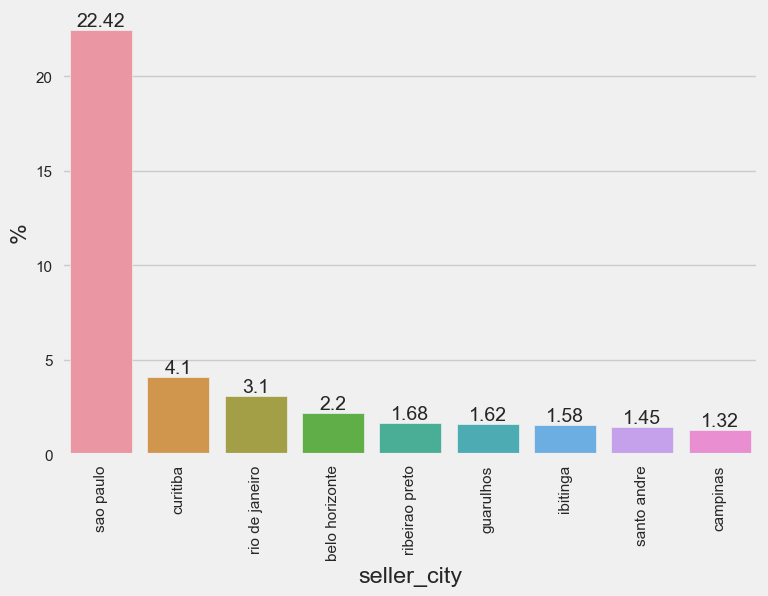

In [330]:
df_tmp_sort = df_tmp_sort.loc[df_tmp_sort["nb_seller_id"] > 40]
plt.xticks(rotation=90)  # Rotation de 90°de l'axe des abscisses
ax = sns.barplot(data=df_tmp_sort, x="seller_city", y="%")  # Création du barplot

for i in ax.containers:
    ax.bar_label(
        i,
    )

#### <a name="C7229">7.2.2.9 df_product_category_name_translation </a>

Pas de variables catégorielles pertinentes à étudier.

#### <a name="C72210">7.2.2.10 Autres variables catégorielles </a>

In [331]:
# Prise en compte de la df_finale

df_final_obj = df_final.select_dtypes(include=["object"])
liste = df_final_obj.columns
print(liste)

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_id', 'order_status', 'retard_livraison_class',
       'review_id', 'geolocation_zip_code_prefix', 'geolocation_city',
       'geolocation_state', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'geolocation_zip_code_prefix_seller',
       'geolocation_city_seller', 'geolocation_state_seller',
       'Customer_segment'],
      dtype='object')


In [332]:
for ele in range(0, len(liste)):
    print(liste[ele])
    print(df_final_obj[liste[ele]].value_counts(normalize=True))
    print("--------------------------")

customer_unique_id


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



6560211a19b47992c3666cc44a7e94c0    0.018784
4a3ca9315b744ce9f8e9374361493884    0.017576
cc419e0650a3c5ba77189a1882b7556a    0.017292
1f50f920176fa81dab994f9023523100    0.014330
da8622b14eb17ae2831f4ac5b9dab84a    0.013363
955fee9216a65b617aa5c0531780ce60    0.013153
7a67c85e85bb2ce8582c35f2203ad736    0.011735
ea8482cd71df3c1969d7b9473ff13abc    0.011724
4869f7a5dfa277a7dca6462dcf3b52b2    0.011672
3d871de0142ce09b7081e2b9d1733cb1    0.010968
7c67e1448b00f6e969d365cea6b010ab    0.010117
8b321bb669392f5163d04c59e235e066    0.009634
1025f0e2d44d7041d6cf58b6550e0bfa    0.009235
620c87c171fb2a6dd6e8bb4dec959fc6    0.007554
a1043bafd471dff536d0c462352beb48    0.007291
cca3071e3e9bb7d12640c9fbe2301306    0.006955
f8db351d8c4c4c22c6835c19a46f01b0    0.006787
e9779976487b77c6d4ac45f75ec7afe9    0.006629
fa1c13f2614d7b5c4749cbc52fecda94    0.005946
7d13fca15225358621be4086e1eb0964    0.005757
d91fb3b7d041e83b64a00a3edfb37e4f    0.005505
128639473a139ac0f3e5f5ade55873a5    0.005463
46dc3b2cc0

# FIN 

Suite : voir "Renard_Anthony_2_notebook_essais_202301.ipynb"

In [333]:
STOP

NameError: name 'STOP' is not defined